In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

# DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Save Figure
show_fig    = False       # If True : Show the figure that are plot
# save_fig    = False      # If True : Save the figure that are plot ; If show_fig == False, figure won't be save 
# save_folder = 'UC3_fig'  # Folder where the figure is saved

# All stuffs for the connection to the DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'dlt-bi.database.windows.net'
username = 'WVN-TEST'
database = 'Export Data Prod' #'DelitraiteurBI_Prod'
password = 'jYei0u22cGZiE9F4VFER'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';PORT=1433;DATABASE=' + database + 
         ';UID=' + username + 
         ';PWD=' + password)

driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

schema_Fact = 'ARC'
schema_Dim  = 'PML'


# @param DB / Table / Column Name   -> Should be changed if you change DB
"""
    Il faut ici récupérer tous les articles vendus dans la même transaction -> le même ticket.
    Pour ça, on va récupérer la clé primaire du ticket, contenu dans [Entete_Ticket.KEY].
    Le contenu du ticket est dans la table de détail du ticket : [Detail_Ticket.Article.KEY].
    
    Les tables détail et entête ne sont pas liés par des clés étrangère.
    Pour les liés, il faut que la date ET le numéro de ticket.
"""
DB            = database                                         
TABLE_ENTETE  = "Recette_entete_ticket"                                                 
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
CONSOMMATEUR  = "Consommateur"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

In [3]:
# TEST & CREATE Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_UNIVERS+".KEY] FROM ["+DB+"].["+schema_Dim+"].[Dim_"+TABLE_UNIVERS+"]", conn)
print(df)

conn.close()

   Univers.KEY
0           -1
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9


# DEFINITION DES FONCTIONS

### Prétraitements des données

In [4]:
"""
    Les Articles sont regroupés en univers.
    Les Univers possèdent 4 niveau de profondeur/précision.
    Plus la profondeur est élevés, plus il y a d'univers et plus c'est précis.
        Univers_Depth = 1 => #Univers = 16
        Univers_Depth = 4 => #Univers = 490
    
    Deux univers sont commun à N niveau près si leur N premier libellé sont commun.
    Pour obtenir les univers d'une ceraines profondeurs, on regarde alors les libellés distincts.
    
    
        @ Input : 
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où aller
        
        @ Ouput : 
            - Univers Correspondance [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Dictionnaire permettant de savoir quel univers correspond à un autre pour un certain degré de profondeur.
                L'univers Univers_Key devient Univers_Key_Correspondance pour une profondeur Univers_Depth
        
"""
def get_univers_correspondance(Univers_Depth):
    #SQL Request to select Key + 4 level of libelle of the table Dim_Univers
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].['''+schema_Dim+'''].[Dim_'''+TABLE_UNIVERS+''']'''

    #Connexion to DB and load DataFrame
    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    #Variable to return
    univers_correspondance = {}
    #Stocks Univers key which is deleted.
    deleted = set()
    
    """
        Double boucle, on vérifie pour l'univers 1 si il existe des univers commun,
        puis sur l'univers 2 si il n'est pas supprimé, 
        puis sur le 3, etc.
    """
    for item in df_univers.values:
        if item[0] in univers_correspondance.keys():
            continue
        univers_correspondance[item[0]] = item[0]
        for cor in df_univers.values: 
            # If libelle 1 to Univers_Depth of both univers are the same, they are the same
            if item[0] != cor[0] and (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
        
    return univers_correspondance

In [5]:
"""
    Charge les transactions en les groupant de trois manière :
        - Toutes les transactions chargées par la DB de manière générale;
        - Toutes les transactions chargées par la DB groupée par magasin;
        - Toutes les transactions chargées par la DB groupée par article, 
            avec en plus le CA de l'article et le CA en dehors de l'articles chargés pour chaque transactions;
            
    Pour charger les transactions, on crée juste une nouvelle transactiosn dès que la clé du ticket est différentes.
    
        @ Input : 
            - dataframe [pd.DataFrame] | column = ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
                Contient toutes les données des tickets
                Les colonnes doivent être gardés dance cette ordre (ou la fonction doit être changé)
            - univ_cor [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Correspondance des univers en fonction de la profondeur utilisée.
                output de la fonction get_univers_correspondance(Univers_Depth)
            - all_mag_key [set]
                Contient toutes les clés de magasin présente dans le dataframe
            - all_univ_key [set]
                Contient toutes les clés d'univers présente dans le dataframe
                
        @ Output : 
            - transactions [list[tupple]]
                Contient la liste du contenu de toutes les transactions
            - all_mag_tra [dict] = {(Magasin_Key : list(tupple))}
                Contient pour chaque magasin la liste du contenu de toutes les transactions de ce magasin
            - univ_transactions = {(Univers_Key : list(tupple))}
                Contient pour chaque univers la liste du contenu de toutes les transactions de cet univers
            - univ_CA
                Contient pour chaque univers le CA produit par cette univers
            - univ_CA_sans_univ
                Contient pour chaque univers le CA produit par les transctions qui contenaient l'univers moins le CA produit par l'univers
"""
def load_transactions_structure(dataframe, univ_cor, COL_FID, COL_TEMPS, COL_MAG, COL_TICKET, COL_UNIV, COL_CA):
    start = time()

    transactions_structure = {0:{}, 1:{}}
    
    for i in range(len(dataframe.values)):
        fid     = int(dataframe[COL_FID][i] > 0)
        date_k  = dataframe[COL_TEMPS][i]//100
        magasin = dataframe[COL_MAG][i]
        ticket  = dataframe[COL_TICKET][i]
        univers = univ_cor[dataframe[COL_UNIV][i]]
        recette = dataframe[COL_CA][i]
    
        if not date_k in transactions_structure[fid].keys():
            transactions_structure[fid][date_k] = {}
        if not magasin in transactions_structure[fid][date_k].keys():
            transactions_structure[fid][date_k][magasin] = {}
        if not ticket in transactions_structure[fid][date_k][magasin].keys():
            transactions_structure[fid][date_k][magasin][ticket] = []
        transactions_structure[fid][date_k][magasin][ticket].append((univers,recette))
            
    # environ 10s * #tickets / 2.000.000.
    print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    
    return transactions_structure

In [6]:
"""
    Charge les transactions en les groupant de trois manière :
        - Toutes les transactions chargées par la DB de manière générale;
        - Toutes les transactions chargées par la DB groupée par magasin;
        - Toutes les transactions chargées par la DB groupée par article, 
            avec en plus le CA de l'article et le CA en dehors de l'articles chargés pour chaque transactions;
            
    Pour charger les transactions, on crée juste une nouvelle transactiosn dès que la clé du ticket est différentes.
    
        @ Input : 
            - dataframe [pd.DataFrame] | column = ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
                Contient toutes les données des tickets
                Les colonnes doivent être gardés dance cette ordre (ou la fonction doit être changé)
            - univ_cor [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Correspondance des univers en fonction de la profondeur utilisée.
                output de la fonction get_univers_correspondance(Univers_Depth)
            - all_mag_key [set]
                Contient toutes les clés de magasin présente dans le dataframe
            - all_univ_key [set]
                Contient toutes les clés d'univers présente dans le dataframe
                
        @ Output : 
            - transactions [list[tupple]]
                Contient la liste du contenu de toutes les transactions
            - all_mag_tra [dict] = {(Magasin_Key : list(tupple))}
                Contient pour chaque magasin la liste du contenu de toutes les transactions de ce magasin
            - univ_transactions = {(Univers_Key : list(tupple))}
                Contient pour chaque univers la liste du contenu de toutes les transactions de cet univers
            - univ_CA
                Contient pour chaque univers le CA produit par cette univers
            - univ_CA_sans_univ
                Contient pour chaque univers le CA produit par les transctions qui contenaient l'univers moins le CA produit par l'univers
"""
def load_transactions(transactions_structure_month, all_mag_key, all_univ_key):
    start = time()

    # Initialisation of output variable
    transactions      = []
    
    all_mag_tra = {mag_key:[] for mag_key in all_mag_key}
    
    univ_transactions = {univ_key:[] for univ_key in all_univ_key}
    univ_CA           = {univ_key:0  for univ_key in all_univ_key}
    univ_CA_sans_univ = {univ_key:0  for univ_key in all_univ_key}
    
    
    # Variable for the loop initialisation
    CA_trans   = {}
    
    for key_mag, value_mag in transactions_structure_month.items():
        for key_tic, value_tic in value_mag.items():
            univ_trans = []
            CA_trans   = {}
            
            for key_univ, rec_lig in value_tic:
                univ_trans.append(int(key_univ))
                if not key_univ in CA_trans.keys():
                    CA_trans[key_univ] = 0
                CA_trans[key_univ] += rec_lig
                
                univ_CA[key_univ] += rec_lig
                
            l = tuple(univ_trans)
            transactions.append(l) 
            all_mag_tra[key_mag].append(l)
            
            for k in CA_trans.keys():
                univ_transactions[k].append(l)
                univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    
    # environ 10s * #tickets / 2.000.000.
    print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    
    return transactions, all_mag_tra, univ_transactions, univ_CA, univ_CA_sans_univ

In [7]:
def load_transactions_univ(trans_mag, all_univ_key):
    start = time()
    
    transactions = []
    
    univ_transactions = {univ_key:[] for univ_key in all_univ_key}
    univ_CA           = {univ_key:0  for univ_key in all_univ_key}
    univ_CA_sans_univ = {univ_key:0  for univ_key in all_univ_key}
    
    # Variable for the loop initialisation
    CA_trans   = {}

    for key_tic, value_tic in trans_mag.items():
        univ_trans = []
        CA_trans   = {}

        for key_univ, rec_lig in value_tic:
            univ_trans.append(int(key_univ))
            if not key_univ in CA_trans.keys():
                CA_trans[key_univ] = 0
            CA_trans[key_univ] += rec_lig

            univ_CA[key_univ] += rec_lig

        l = tuple(univ_trans)
        if not 490 in  CA_trans.keys():
            transactions.append(l)

            for k in CA_trans.keys():
                univ_transactions[k].append(l)
                univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    
    # environ 10s * #tickets / 2.000.000.
#     print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    
    return transactions, univ_transactions, univ_CA, univ_CA_sans_univ

### Analyses des données

In [8]:
"""
    Analyse les valeurs de seuil de support et de confidence pour l'Apriori Algorithm.
    La fonction va run l'Apriori Algorithm pour toutes les valeurs de support entre min_sup et max_sup et de confidence entre min_conf et max_conf.
    Il regarde ensuite le nombre de règles créé et le temps de run de l'algo.
    
    Une alternative plus rapide à l'algorithme ci-dessous peut être faite : 
        run l'algorithm pour max_sup et min_conf et l'Apriori Algorithm sort les stats de support et confidence pour chaque règle
        On traite chacune des règles et on regarde les stats
    Cette alternative ne permet cependant pas de ressortir les temps de runs.
    
        @ Input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_sup [float] = [0.0;1.0]
                Minimum support qui sera testé
            - max_sup [float] = [0.0;1.0]
                Maximum support qui sera testé
            - sup_iter [int] >= 0
                Nombre-1 de seuil de support qui sera testé
            - min_conf [float] = [0.0;1.0]
                Minimum confidence qui sera testé
            - max_conf [float] = [0.0;1.0]
                Maximum confidence qui sera testé
            - conf_iter [int] >= 0
                Nombre-1 de seuil de confidence qui sera testé
                
        @ Output :
            - df_rules [pd.DataFrame]
                Support en index, confidence en column, nombre de règle en value
            - df_time [pd.DataFrame]
                Support en index, confidence en column, temps de run en value

"""
def Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter):
    # initialization of output
    data_rules = {}
    data_time  = {}
    
    # Double loop to run algo on all min_sup / max_sup
    for i_support in range(sup_iter+1):
        # Setting value of min_supp
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter
        min_support = min(min_support, 1)
        
        # Algorithm can't run for min_support <= 0 ->
        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            # Setting value of min_conf
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter
            min_confidence = min(min_confidence, 1)

            print(min_confidence, end = '... ')

            #running Apriori Algorithm
            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")

    #change output to dataframe
    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)
    
    return df_rules, df_time

In [9]:
"""
    Pour un ensemble de transactions, va charger un dictionnaire contenant la fréquence à laquelle des univers apparaissent.
    Ex: Si l'univers 299 apparait dans 50% des transactions, l'output va contenir l'objet : (299:0.5)
    
    La fonction va également plot un graphique en barre des plus grande fréquence d'univers.
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - show_plot [boolean]
                True : affiche le plot
            - nbr_to_plt [int] >= 0
                Top X des fréquences qui seront plot si show_plot = True
                
        @output :
            - rec_article [dict] = {(univ_key:frequency)}
                Pour chaque univers, la fréquence à laquelle l'article apparait dans les transactions
            - nbr_univ [int]
                Nombre totale d'univers distinct dans les transactions
"""
def load_recurence(transactions, show_plot = True, nbr_to_plt = 20):
    start = time()
    rec_article = {}

    # Recup for every univers the récurence
    for t in transactions:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1
        
    # Sort DESC the recurence
    rec_article = {int(k): v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}
    nbr_univ = len(rec_article.keys())

    # plot the frequency
    if show_plot:
        fig = plt.figure(figsize=(15, 5))
        plt.bar(list(rec_article.keys())[:min(nbr_to_plt, nbr_univ)]
                    ,list(rec_article.values())[:min(nbr_to_plt, nbr_univ)],1)

        plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")

        if save_fig:
            title = save_folder+"/"+str(Univers_Depth)+"_Proportion-Article"
            if list(rec_article.values())[0] == 1:
                title += "_"+str(list(rec_article.keys())[0])
            plt.savefig(title+".jpg")
        plt.show()

    return rec_article, nbr_univ

In [10]:
"""
    Récupère pour chaque transaction le nombre d'article qui sont vendu en plus d'une liste d'univers particulier
        et le nombre d'article de la liste d'univers particulier
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - univ_keys [list(int)]
                liste de clé à filter pour les output
                
        @ output :
            - nbr_article_sans_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers non-inclu dans univ_keys est présent
            - nbr_article_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers inclu dans univ_keys est présent
"""
def get_nbr_sans_univ(transactions, univ_keys):
    #initialization of the output
    nbr_article_sans_univ = [0 for _ in range(len(transactions))]
    nbr_article_univ      = [0 for _ in range(len(transactions))]
    
    # for each transactions : inscrease nbr_article_sans_univ if article not in univ_keys else increase nbr_article_univ
    for i in range(len(transactions)):
        for item in transactions[i]:
            if not item in univ_keys:
                nbr_article_sans_univ[i] += 1
            else:
                nbr_article_univ[i] += 1
                
    return nbr_article_sans_univ, nbr_article_univ     

In [11]:
def get_metrics(all_univ_key,univ_transactions,univ_CA_sans_univ,univ_CA, show_plot = False):
    start = time()

    dico_metrics = {}
    dico_rec_art = {}

    for key in all_univ_key:
#         if not key%100:
#             print("==============" + str(key)+"===================")

        trans           = univ_transactions[key]
        CA_without_univ = univ_CA_sans_univ[key]
        CA_univ         = univ_CA[key]

        N = len(trans)

        # Load recurence and #article per transactions
        nbr_article_sans_univ, nbr_article_univ = get_nbr_sans_univ(trans, [key])
        dico_rec_art[key], _ = load_recurence(trans, show_plot)

        """
            8 metrics sont calculées :
                - "Proportion d'achat (%)" : Nombre de transactions contenant l'univers / nombre total de transactions
                - "Proportion d'achat seul": Nombre de fois que l'univers à été acheté seul / nombre de transactions contenant l'univers
                - "CA univ"       : CA totale produit par l'unif
                - "CA moyen univ" : "CA univ" / nombre de transaction contenant l'univers
                - "Nombre moyen article en plus" : Nombre d'article acheté qui ne sont pas dans l'univers dans les transactions contenant l'univers / nombre de transactions contenant l'univers
                - "CA en plus"       : CA totale des transactions contenant l'univers - "CA univ"
                - "CA moyen en plus" :"CA en plus" / nombre de transaction contenant l'univers
        """
        dico_metrics[key] = {"Nombre transaction unif": N,
                             "Nombre transaction avec univ seul": sum([1 if t == 0 else 0 for t in nbr_article_sans_univ]),
                             "Nombre d'univ vendu":sum(nbr_article_univ),
                             "Nombre article vendu en plus": sum(nbr_article_sans_univ),
                             "CA univ": CA_univ,
                             "CA en plus": CA_without_univ}

#     print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 
    
    return dico_metrics, dico_rec_art

### Apriori Algorithm - Getting Association Rules

In [12]:
"""
    Run l'Apriori Algorithm sur les transactions pour un certains support et confidence.
    L'Apriori Algorithm est un algorithme calculant les meilleurs règles d'associations entre article.
    Les règles d'associations sont sous la forme :
        "Si le client achetent de la mozzarella, alors il a 35% de chance d'acheter des tomates. 
        Cette événement s'est produit dans 1% de toutes les transactions"
    Le 35% représente ici la confidence, et le 1% représente le support.
    
    Un seuil de support et de confidence sont mis pour pas se retrouver avec 50k règles et un algo qui prends 6 ans à run.
    Sans ces seuils, la complexité est factorielle, donc je déconseille de mettre min_support à 0.
    Si le support est à 0, il est calculé automatiquement en le mettant à 1/#univers (environ 1/400)
    
    A noter que l'Apriori Algorithm ressort une solution exacte par rapport au min_support/min_confidence.
    Il ne sert donc à rien de le run plusieurs fois en espérant que ça change la solution.
    
    Pour plus d'info sur l'algorithme : https://www.youtube.com/watch?v=43CMKRHdH30
    Pour plus d'info sur la libraire  : https://efficient-apriori.readthedocs.io/en/latest/
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_support [float] = [0;1]
                Seuil de fréquence d'apparition de la règles
            - min_confidence [float] = [0;1]
                Seuil de confiance en une règle 
            - nbr_univ [int]
                Nombre d'univers distinct dans les transactions
                
        @ output : 
            - Rules [list(Rule) (voir librairie)]
                Règles ressortie par l'algorithme
"""
def get_rules(transactions, min_support, min_confidence, nbr_univ = 490):
    # Recalculate the support if min_support <= 0
    min_supp = 1/nbr_univ if min_support <= 0 else min_support

    # Run Apriori Algorithm
    _, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)
    
    return rules

In [13]:
"""
    Affiche les règles avec leur libellé plutot que les règles avec les clés d'univers.
    Prend en compte la profondeur d'univers.
    
    Si une removed_key est entrée, alors les règles contenant cette clé ne seront pas affichés.
    Cette particularité est surtout utile pour voir les règles dans le cas des transactions contenant toujours un univers (cas des transactions regroupés par univers)
    
    La rule est skip si le lift = 1 car ça n'a pas de sens de la garder par définition mathématique (proof is let to the reader).
    
        @ input : 
            - rules [list(Rule) (voir librairie)]
                Règles ressortie par l'apriori algorithm
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où les articles sont regroupés
            - conn
                connexion au serveur sql
            - removed_key [int] = -1 || [1;490]
                clé que l'on souhaite ne pas avoir dans les règles affichées.
        
        @ output :
            None
"""
def print_rules(rules, Univers_Depth, conn, removed_key = -1):
    conn = engine.connect()

    for rule in sorted(rules, key=lambda rule: rule.lift):
        # Skip rule if lift = 1 or if rule contain removed_key
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].['''+schema_Dim+'''].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].['''+schema_Dim+'''].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()

## Insert to database

In [14]:
"""
    Définition de tous les paramètres, tables et engines permettant l'insert de données.
    Les table de la DB auront le format : [DB_INSERT].[schema_INSERT].[TABLE_NAME]
"""
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

DB_INSERT     = "DelitraiteurBI_ResultML"

schema_INSERT = "PML"

TABLE_PARAMS  = "UC3_Caracteristique"    
TABLE_METRICS = "UC3_Univers_Metrics"   
TABLE_RECUR   = "UC3_Recurence_Univers"  
TABLE_RULES   = "UC3_Rules_Univers"

params        = urllib.parse.quote_plus(login)
engine_INSERT = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [15]:
# TEST Connexion
conn = engine_INSERT.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_UNIVERS+".KEY] FROM ["+DB_INSERT+"].[DWH].[Dim_"+TABLE_UNIVERS+"]", conn)
print(df)

conn.close()

   Univers.KEY
0           -1
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9


In [16]:
"""
    Insert dans la table TABLE_PARAMS.
    Calcule automatiquement la date pour la sauvgarder. Sauvegarde également la DB sur laquelle ça a run.
    Retourne la clé de la valeur qui vient d'être inséré afin qu'elle soit inséré dans les tables l'ayant en FK.
    
        @input :
            - FID [binary]
                Indicateur de fidélité, 0 si consommateurs pas fidélisés, 1 si consommateurs fidélisés
            - MONTH [int]
                Clé du mois des données, sous la forme YYYYMM
            - MAG [int or "NULL"] 
                Clé du magasin des données, peut être Null, à ce moment là, entré la valeur "NULL"
            - nbr_trans [int]
                Nombre de transactions se rapportant aux données
                
        @ output : 
            - params_key [int]
                Clé primaire de la ligne de TABLE_PARAMS qui vient d'être inséré 
    
"""
def insert_params(FID, MONTH, MAG, nbr_trans, SEGMENT_KEY = "NULL"):
    # Recuperation of today's date
    now = date.today()
    # Definition of SQL query
    sql_cmd = '''
    INSERT INTO ['''+DB_INSERT+'''].['''+schema_INSERT+'''].['''+TABLE_PARAMS+''']
         VALUES
               ('''+str(now.year*10000 + now.month*100 + now.day)+'''
               ,'''+"'"+str(DB)+"'"+'''
               ,'''+str(Univers_Depth)+'''
               ,'''+str(FID)+'''
               ,'''+str(MONTH)+'''
               ,'''+str(MAG)+'''
               ,'''+str(nbr_trans)+'''
               ,'''+str(SEGMENT_KEY)+''')
    '''
    
    # Run SQL query
    conn = engine_INSERT.connect()
    conn.execute(sql_cmd)
    
    # Recuperation of primary key of TABLE_PARAMS last elements 
    params_key = pd.read_sql("SELECT ["+TABLE_PARAMS+".KEY] FROM ["
                             +DB_INSERT+"].["+schema_INSERT+"].["+TABLE_PARAMS+"] ORDER BY 1 DESC",
                                 conn).values[0][0]
    conn.close()
    
    return params_key

In [32]:
"""
    Insert dans la table TABLE_METRICS.
    
        @input :
            - dataframe_metrics [dict] = {UNIVERS.KEY : list(UNIVERS.METRICS)}
                Dictionnaire conenant la clé de l'univers en key et une liste de metrics se rapportant à cet univers en values
                Les metrics doivent se trovuer dans le même ordre que dans la Table de metrics
            - params_key [int]
                Clé étrangère de la ligne de TABLE_PARAMS se rapportant aux données     
"""
def insert_metrics(metrics, params_key):
    conn = engine_INSERT.connect()
    
    sql_cmd = "INSERT INTO ["+DB_INSERT+"].["+schema_INSERT+"].["+TABLE_METRICS+"] VALUES" 
    if not isinstance(metrics, dict):
        metrics = metrics.to_dict('index')
    for key,val in metrics.items():
        if list(val.values())[0] <= 0:
            continue
        sql_cmd += ''' (''' + str(params_key)            + ''',
                        ''' + str(key)                   + ''',
                        ''' + str(list(val.values())[0]) + ''',
                        ''' + str(list(val.values())[1]) + ''',
                        ''' + str(list(val.values())[2]) + ''',
                        ''' + str(list(val.values())[3]) + ''',
                        ''' + str(list(val.values())[4]) + ''',
                        ''' + str(list(val.values())[5]) + '''),'''
    sql_cmd = sql_cmd[:-1]+";"
    conn.execute(sql_cmd)
    conn.close()

In [18]:
"""
    Insert dans la table TABLE_RECURENCE.
    
        @input :
            - nbr_trans [int]
                Nombre de transaction se rapportant aux données. 
                Si univ_key != "NULL", alors nbr_trans = nombre de transactions contenant l'univers
            - dico_rec_art [dict] = {UNIVERS.KEY : recurence}
                Dictionnaire conenant la clé de l'univers en key et leur récurence dans les transactions
            - params_key [int]
                Clé étrangère de la ligne de TABLE_PARAMS se rapportant aux données
            - univ_key [int or "NULL"]
                Univers contenu dans la totalité des transactions, filtre appliqué sur les transactions pour qu'elles ne contiennent que l'univers    
"""
def insert_recurence(nbr_trans, dico_rec_art, params_key, univ_key = "NULL"):
    if nbr_trans <= 0:
        return
    
    conn = engine_INSERT.connect()
    sql_cmd = "INSERT INTO ["+DB_INSERT+"].["+schema_INSERT+"].["+TABLE_RECUR+"] VALUES"
    
    for univ,prop in dico_rec_art.items():
        if prop <= 0:
            continue
        sql_cmd += ''' (''' + str(params_key) + ''',
                        ''' + str(univ_key)   + ''',
                        ''' + str(univ)       + ''',
                        ''' + str(prop)       + ''',
                        ''' + str(nbr_trans)  + '''),'''
    sql_cmd = sql_cmd[:-1]+";"
#     print(sql_cmd)   
    conn.execute(sql_cmd)
                
    conn.close()

In [42]:
"""
    Insert dans la table TABLE_METRICS.
    
        @input :
            - rules [list(Rule) (voir librairie)]
                Règles ressortie par l'apriori algorithm
            - params_key [int]
                Clé étrangère de la ligne de TABLE_PARAMS se rapportant aux données     
"""
def insert_rules(rules, params_key):
    if len(rules) == 0:
        return
    
    conn = engine_INSERT.connect()
    sql_cmd = "INSERT INTO ["+DB_INSERT+"].["+schema_INSERT+"].["+TABLE_RULES+"] VALUES"
    
    for rule in rules:
        if len(rule.lhs) > 2 or len(rule.rhs) > 2 or rule.lift <= 1:
            continue
        sql_cmd += ''' (''' + str(params_key)  + ''',
                        ''' + str(rule.lhs[0]) + '''
                       ,''' + ("Null" if len(rule.lhs) == 1 else str(rule.lhs[1])) + '''
                       ,''' + str(rule.rhs[0]) + '''
                       ,''' + ("Null" if len(rule.rhs) == 1 else str(rule.rhs[1])) + '''
                       ,''' + str(round(rule.confidence,3)) + '''
                       ,''' + str(round(rule.support   ,4)) + ''' 
                       ,''' + str(round(rule.lift      ,2)) + '''
                       ,''' + str(round(rule.conviction,3)) + '''),'''
        
    sql_cmd = sql_cmd[:-1]+";"
    #     print(sql_cmd)           
    conn.execute(sql_cmd)
    conn.close()

# RUNNING TIME

## Définition des paramètres

In [50]:
# @param Variable influançant la sélection des données
"""
    Pour ne pas perdre le sens des articles dans l'analyse, on utilise leur groupement par univers.
    Ces univers sont composés de 4 niveau de précision (1 étant le moins précis avec 16 univers, 4 étant le plus précis avec 490 univers).
    Cette précision peut être modifier avec la variable @Univers_Depth.
    
    Deux variables permettent également de varier la section de temps sur laquelle on sélectionne les données.
    De manière générales, une section de temps de 6 mois en bien pour les données de prod.
"""
Univers_Depth  = 2                           # Jusqu'où on ira dans l'univers ? = [1;4]
start_time     = 202101                      # YYYYMM de départ 
end_time       = start_time+12                # YYYYMM de fin exclu (le mois de end_time ne sera pas SELECT)


# """
#     Afin d'analyser sous plus d'angle, la possibilité de ne prendre que les transactions de clients fidélisé est données.
#     Dans la DB Archive2018_2019_prod, les tickets de clients fidélisés commencent à partir de la clé 16.000.000.
#     Pour mixer les données fidéliser et non fidélisées, il vaut mieux commencer à sécectionner les tickets à partir de cette bornes.
#     Pour n'obtenir que des tickets non-fidélisé, il suffit de mettre take_only_fid = False, start_fid_key = 0 et nbr_ticket_max < 16.000.000.
# """
# take_only_fid  = True     # If true, only transactions with fidelised cunsommer will be select
# # start_fid_key  = 16000000  # Key of TABLE_ENTETE where begin to mix fidelised and unfidelised cunsummer
# # nbr_ticket_max = 5000000   # MAX = 26.671.566 for Archive2018_2019_prod. Try to not select more thant 10.000.000 ticket


# @param du modèle prédictif - Apriori Algorithm
min_support     = 0.002     # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
if Univers_Depth == 3:
    min_support = 0.003 
if Univers_Depth < 3:      # Le seuil doit augmenter si le nombre d'univers augmente pour ne pas perdre de sens
    min_support = 0.01
min_confidence = 0.2       # Seuil de confiance minimal souhaité     -> 1/3        ~= 33% 

univers_correspondance = get_univers_correspondance(Univers_Depth)

## Select dans la DB 

In [46]:
start = time()

COL_FID    = TABLE_ENTETE  + "." + CONSOMMATEUR  + ".KEY"
COL_TEMPS  = TEMPS_ENTETE
COL_MAG    = TABLE_ENTETE  + "." + TABLE_MAGASIN + ".KEY"
COL_TICKET = TABLE_ENTETE  + ".KEY"
COL_UNIV   = TABLE_ARTICLE + "." + TABLE_UNIVERS + ".KEY"
COL_CA     = RECETTE_DETAIL


# SQL Query to get the usefull data for the transactions. 
sql_command = '''SELECT
[''' + COL_FID    + '''],
[''' + COL_TEMPS  + '''],
[''' + COL_MAG    + '''],
[''' + COL_TICKET + '''],
[''' + COL_UNIV   + '''],
[''' + COL_CA     + ''']
FROM ['''       + DB + '''].['''+schema_Dim +'''].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].['''+schema_Fact+'''].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].['''+schema_Fact+'''].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''       + TEMPS_DETAIL  + '''] = [''' + TEMPS_ENTETE    + '''] 
AND ['''      + NUMERO_DETAIL + '''] = [''' + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != 388
AND ['''      + TEMPS_ENTETE  + '''] > '''  + str(start_time*100) + '''
AND ['''      + TEMPS_ENTETE  + '''] < '''  + str(end_time  *100)


if DB == 'Export Data Prod':
    sql_command = '''
        SELECT [DIM_DETAIL_TICKET.KEY]
      ,[Article_meti_HIST.Univers.KEY]
      ,[Recette_entete_ticket.KEY]
      ,[Recette_entete_ticket.Magasin.KEY]
      ,[Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction]
      ,[Recette_entete_ticket.Consommateur.KEY]
      ,[Recette_detail_ticket.Total_net_ttc_ligne]
      ,[Recette_detail_ticket.Ligne_annulee]
      ,[Recette_detail_ticket.quantite]
      FROM [Export Data Prod].[PML].[Dim_detail_ticket]
      WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
        AND ['''      + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != 388
        AND ['''      + TEMPS_ENTETE  + '''] > '''  + str(start_time*100) + '''
        AND ['''      + TEMPS_ENTETE  + '''] < '''  + str(end_time  *100)


# SQL Query is print to debug it easily
print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 15min / 6 mois
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)


        SELECT [DIM_DETAIL_TICKET.KEY]
      ,[Article_meti_HIST.Univers.KEY]
      ,[Recette_entete_ticket.KEY]
      ,[Recette_entete_ticket.Magasin.KEY]
      ,[Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction]
      ,[Recette_entete_ticket.Consommateur.KEY]
      ,[Recette_detail_ticket.Total_net_ttc_ligne]
      ,[Recette_detail_ticket.Ligne_annulee]
      ,[Recette_detail_ticket.quantite]
      FROM [Export Data Prod].[PML].[Dim_detail_ticket]
      WHERE [Article_meti_HIST.Univers.KEY] != -1 
        AND [Article_meti_HIST.Univers.KEY] != 388
        AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] > 20210100
        AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] < 20211300
Time Taken to load DB: ~586secondes
          DIM_DETAIL_TICKET.KEY  Article_meti_HIST.Univers.KEY  \
0                      12608509                            163   
1                      12608510                            338   
2                      12608

In [22]:
# # SQL Query to get Magasin Libelle
# sql_command = '''  
# SELECT ['''+TABLE_MAGASIN+'''.KEY]
#       ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
# FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
# '''
# print(sql_command)


# conn = engine.connect()
# df_magasin = pd.read_sql(sql_command, conn)
# conn.close()

## Prétraitements des données dans un formats intéressant

In [63]:
# Get all Univers that can be found in the transactions
all_univ_key = set([i for i in range(1,max(df_art_ticket[COL_UNIV])+1)])

# Load all the transactions with tree structure Fidelity -> Time -> Shop
transactions_structure = load_transactions_structure(df_art_ticket, univers_correspondance, 
                                                     COL_FID, COL_TEMPS, COL_MAG, COL_TICKET, COL_UNIV, COL_CA) 
print(transactions_structure[0].keys())

Time Taken to load transaction: ~663secondes
dict_keys([202109, 202107, 202108, 202111, 202110, 202112])


## Chargement de tous, insert dans la DB progressivement

In [64]:
# Run for all fidelity type
for FID, trans_fid in transactions_structure.items():
    print("----------------------------------", FID, "----------------------------------")
    # Run for all month
    for MONTH, trans_month in trans_fid.items():
        s = time()
        print("\n====================",MONTH,"====================")
        # Will save the rules and the recurence between univers for the month, so we need rec_art and transactions of the month
        dico_rec_art_month   = {k:{k:0 for k in all_univ_key} for k in all_univ_key}
        transactions_month   = []
        
        for MAG, trans_mag in trans_month.items():
            # Load transactions and CA for the MAG-MONTH-FID
            transactions, univ_transactions, univ_CA, univ_CA_sans_univ = load_transactions_univ(trans_mag, all_univ_key)
            
            if len(transactions) == 0:
                continue
            
            # Get Metrics and recurence for all univers
            dico_metrics, dico_rec_art = get_metrics(all_univ_key,
                                                     univ_transactions,
                                                     univ_CA_sans_univ,
                                                     univ_CA,
                                                     show_plot = False) 
            # Transform dico_metrics to dataframe 
            dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                             data  = dico_metrics.values())
            
            # Load recurence for the shop
            dico_rec_total, _ = load_recurence(transactions, show_plot = False)
            
            # Insert metrics and recurence for the shop
            params_rec_key = insert_params(FID, MONTH, MAG, len(transactions))
            insert_metrics(dataframe_metrics, params_rec_key)
            insert_recurence(len(transactions), dico_rec_total, params_rec_key)
            
            
            # Save recurence of universe and transactions for the month
            for k1, dic in dico_rec_art.items():
                for k2, val in dic.items():
                    dico_rec_art_month[k1][k2]+=val
            
            for t in transactions:
                transactions_month.append(t)
                    
        # environ 15s
        print("Time taken to load and insert mag' stuffs of month:",int(time()-s),"s")
        
        # Get all rules of the month
        rules = get_rules(transactions_month, min_support, min_confidence)
        
        # Insert recurence for all universe and rules for the month
        params_rec_key = insert_params(FID, MONTH, "NULL", len(transactions_month))
        for k,v in dico_rec_art_month.items():
            insert_recurence(max(v.values()), v, params_rec_key, univ_key = k)
        insert_rules(rules, params_rec_key)
        
        # environ 30s
        print("Time taken to load and insert everythings of month:",int(time()-s),"s")

---------------------------------- 0 ----------------------------------

==================== 202109 ====================
Time taken to load and insert mag' stuffs of month: 21 s
Time taken to load and insert everythings of month: 39 s

==================== 202107 ====================
Time taken to load and insert mag' stuffs of month: 19 s
Time taken to load and insert everythings of month: 38 s

==================== 202108 ====================
Time taken to load and insert mag' stuffs of month: 20 s
Time taken to load and insert everythings of month: 40 s

==================== 202111 ====================
Time taken to load and insert mag' stuffs of month: 17 s
Time taken to load and insert everythings of month: 35 s

==================== 202110 ====================
Time taken to load and insert mag' stuffs of month: 20 s
Time taken to load and insert everythings of month: 38 s

==================== 202112 ====================
Time taken to load and insert mag' stuffs of month: 16 s
T

In [39]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~5496secondes


In [51]:
if Univers_Depth == 3:
    min_support = 0.02
elif Univers_Depth == 2:
    min_support = 0.05
min_confidence = 0.25
for SEGMENT_KEY in range(35,43):
    print(SEGMENT_KEY)
    
    sql_command = '''
    SELECT [UC2_Segment_Client.CONSOMMATEUR.KEY]
      FROM [DelitraiteurBI_ResultML].[PML].[UC2_Segment_Client]
      WHERE [UC2_Segment_Client.UC2_SEGMENT.KEY] = ''' + str(SEGMENT_KEY)

    conn = engine_INSERT.connect()
    df_client_key = pd.read_sql(sql_command, conn)
    conn.close()

    clients_key = set(df_client_key.values[:,0])

    start = time()

    segment_df = []

    # Pandas clone dataframe if we do list.append(datframe.values[i]), so we clone only one time dataframe to not have memory exceed
    All_values = df_art_ticket.values
    N = len(All_values)

    for i in range(len(df_art_ticket)):
        if df_art_ticket[COL_FID][i] in clients_key:
            segment_df.append(All_values[i])


    segment_df = pd.DataFrame(data = segment_df, columns = df_art_ticket.columns)

    print("Time Taken: ~" + str(int(time() - start)) + "secondes") 
    
    # Get all Univers that can be found in the transactions
    all_univ_key = set([i for i in range(1,int(max(segment_df[COL_UNIV]))+1)])

    # Load all the transactions with tree structure Fidelity -> Time -> Shop
    transactions_structure = load_transactions_structure(segment_df, univers_correspondance, 
                                                         COL_FID, COL_TEMPS, COL_MAG, COL_TICKET, COL_UNIV, COL_CA) 
    print(transactions_structure[1].keys())
    
    start = time()
    # Run for all fidelity type
    for FID, trans_fid in transactions_structure.items():
        print("----------------------------------", FID, "----------------------------------")
        # Run for all month
        for MONTH, trans_month in trans_fid.items():
            print("\n====================",MONTH,"====================")
            # Will save the rules and the recurence between univers for the month, so we need rec_art and transactions of the month
            transactions_month   = []
            all_metrics          = {k:{"Nbr_tran"      : 0
                                      ,"Nbr_tran_sans" : 0
                                      ,"Nbr_vendu"     : 0
                                      ,"Nbr_vendu_sans": 0
                                      ,"CA"            : 0
                                      ,"CA_sans"       : 0} for k in all_univ_key}

            for MAG, trans_mag in trans_month.items():
                # Load transactions and CA for the MAG-MONTH-FID
                transactions, univ_transactions, univ_CA, univ_CA_sans_univ = load_transactions_univ(trans_mag, all_univ_key)

                if len(transactions) == 0:
                    continue

                # Get Metrics and recurence for all univers
                dico_metrics, dico_rec_art = get_metrics(all_univ_key,
                                                         univ_transactions,
                                                         univ_CA_sans_univ,
                                                         univ_CA,
                                                         show_plot = False) 

                # Transform dico_metrics to dataframe 
                dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                                 data  = dico_metrics.values())


                for key,val in dataframe_metrics.to_dict('index').items():
                    all_metrics[key]["Nbr_tran"]       += list(val.values())[0]
                    all_metrics[key]["Nbr_tran_sans"]  += list(val.values())[1]
                    all_metrics[key]["Nbr_vendu"]      += list(val.values())[2]
                    all_metrics[key]["Nbr_vendu_sans"] += list(val.values())[3]
                    all_metrics[key]["CA"]             += list(val.values())[4]
                    all_metrics[key]["CA_sans"]        += list(val.values())[5]

                for t in transactions:
                    transactions_month.append(t)

            # Get all rules of the month
            rules = get_rules(transactions_month, min_support, min_confidence)

            # Insert recurence for all universe and rules for the month
            params_rec_key = insert_params(FID, MONTH, "NULL", len(transactions_month), SEGMENT_KEY)

            insert_rules(rules, params_rec_key)
            insert_metrics(all_metrics, params_rec_key)
            
    # environ 30s
    print("Time taken to load and insert everythings of month:",int(time()-start),"s")

35
Time Taken: ~139secondes
Time Taken to load transaction: ~49secondes
dict_keys([202101.0, 202102.0, 202103.0, 202104.0, 202106.0, 202109.0, 202105.0, 202107.0, 202108.0, 202110.0, 202111.0, 202112.0])
---------------------------------- 0 ----------------------------------
---------------------------------- 1 ----------------------------------

==================== 202101.0 ====================

==================== 202102.0 ====================

==================== 202103.0 ====================

==================== 202104.0 ====================

==================== 202106.0 ====================

==================== 202109.0 ====================

==================== 202105.0 ====================

==================== 202107.0 ====================

==================== 202108.0 ====================

==================== 202110.0 ====================

==================== 202111.0 ====================

==================== 202112.0 ====================
Time taken to load and inser

## Anicenne analyse et run des algos, pour des dataset généraux

In [ ]:
(transactions, all_mag_tra, univ_transactions, 
 univ_CA, univ_CA_sans_univ) = load_transactions(transactions_structure[0][202001],
                                                 all_mag_key, all_univ_key)
print(len(transactions))

421112
Time Taken to load recurence: ~0secondes


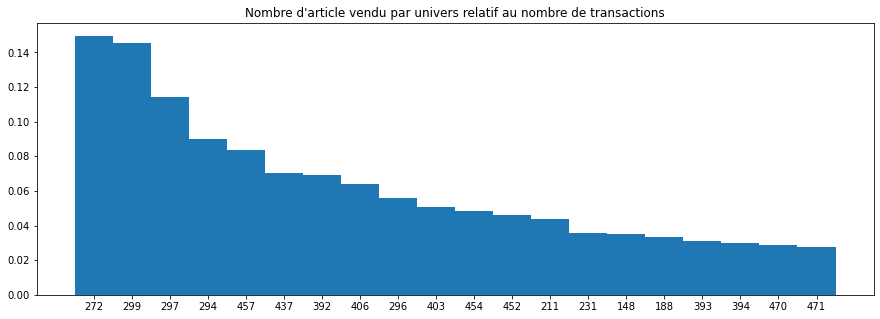

0.001
Time Taken to run Apriori Algorithm : ~4secondes


Rule :  {454, 457} -> {272} (conf: 0.153, supp: 0.001, lift: 1.025, conv: 1.004)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
      457                   BOISSONS               SOFT DRINKS   SODA    COLAS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {151} -> {299} (conf: 0.151, supp: 0.002, lift: 1.036, conv: 1.006)
 Univ_KEY  Univ_1                  Univ_2       Univ_3       Univ_4
      151 DESSERT SALADES DE FRUITS FRAIS INDIVIDUELLE INDIVIDUELLE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {272, 297} -> {299} (conf: 0.151, supp: 0.002, lift: 1.037, conv: 1.006)
 Univ_KEY          Univ_

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {443} -> {299} (conf: 0.169, supp: 0.003, lift: 1.163, conv: 1.029)
 Univ_KEY        Univ_1       Univ_2 Univ_3 Univ_4
      443 PRET A MANGER MEUBLE CHAUD AUTRES AUTRES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {297, 406} -> {299} (conf: 0.169, supp: 0.001, lift: 1.163, conv: 1.029)
 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS        PAINS          PAINS
      406  PRET A MANGER               PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198} -> {272} (conf: 0.181, supp: 0.003, lift: 1.209, conv: 1.038)
 Univ_KEY  

 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294} -> {297} (conf: 0.166, supp: 0.015, lift: 1.448, conv: 1.061)
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {272, 294} -> {297} (conf: 0.166, supp: 0.002, lift: 1.449, conv: 1.062)
 Univ_KEY          Univ_1                       Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE           TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          BAGUETTES          BAGUETTES
->
 Univ_KEY         Univ_1   

Rule :  {298} -> {297} (conf: 0.192, supp: 0.002, lift: 1.676, conv: 1.096)
 Univ_KEY         Univ_1                       Univ_2            Univ_3            Univ_4
      298 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS PETITES BAGUETTES PETITES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {452, 454} -> {297} (conf: 0.192, supp: 0.001, lift: 1.677, conv: 1.096)
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3                       Univ_4
      452                   ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
      454 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS                        CHIPS                     > 1 PERS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {183} -> {297} (conf: 0.207, supp: 0.004, lift: 1.805, conv: 1.116)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {473} -> {457} (conf: 0.151, supp: 0.002, lift: 1.805, conv: 1.079)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3     Univ_4
      473 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS INDIVIDUEL
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {296, 297} -> {299} (conf: 0.264, supp: 0.003, lift: 1.813, conv: 1.161)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PR

 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {296, 299} -> {294} (conf: 0.177, supp: 0.002, lift: 1.972, conv: 1.106)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {287} -> {297} (conf: 0.227, supp: 0.002, lift: 1.982, conv: 1.145)
 Univ_KEY         Univ_1                  Univ_2   Univ_3   Univ_4
      287 PETIT DEJEUNER TARTINABLES ET CEREALES CEREALES CEREALES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {297, 452} 

 Univ_KEY        Univ_1     Univ_2            Univ_3               Univ_4
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE


Rule :  {272, 437} -> {299} (conf: 0.329, supp: 0.002, lift: 2.262, conv: 1.274)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      437  PETIT DEJEUNER       CAFE SERVICE       CAFE SERVICE       CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {294, 296} -> {297} (conf: 0.259, supp: 0.002, lift: 2.266, conv: 1.196)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  BAGUETTES  BAGUETTES
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
   

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {272, 392} -> {457} (conf: 0.213, supp: 0.001, lift: 2.552, conv: 1.165)
 Univ_KEY          Univ_1             Univ_2             Univ_3               Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES   TABAC   CIGARETTES
      392   PRET A MANGER         SANDWICHES  SANDWICHES FROIDS SANDWICHES CLASSIQUE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {22} -> {294} (conf: 0.230, supp: 0.003, lift: 2.557, conv: 1.182)
 Univ_KEY          Univ_1    Univ_2 Univ_3 Univ_4
       22 PRET A CUISINER BOUCHERIE  BOEUF  BOEUF
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {462} -> {297} (conf: 0.294, supp: 0.002, lift: 2.570, conv: 1.255)
 Univ_KEY          Univ_1  

 Univ_KEY         Univ_1                  Univ_2          Univ_3          Univ_4
      290 PETIT DEJEUNER TARTINABLES ET CEREALES PATE A TARTINER PATE A TARTINER
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {72} -> {297} (conf: 0.341, supp: 0.001, lift: 2.982, conv: 1.344)
 Univ_KEY          Univ_1      Univ_2              Univ_3              Univ_4
       72 PRET A CUISINER CHARCUTERIE AUTRES CHARCUTERIES SAUCISSON DE JAMBON
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {301} -> {299} (conf: 0.442, supp: 0.003, lift: 3.035, conv: 1.531)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER V

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {62, 475} -> {297} (conf: 0.380, supp: 0.001, lift: 3.318, conv: 1.428)
 Univ_KEY          Univ_1      Univ_2    Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE   JAMBONS JAMBONS CUITS
      475 PRET A CUISINER     FROMAGE PATE DURE      TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {176} -> {452} (conf: 0.153, supp: 0.002, lift: 3.322, conv: 1.126)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LEGUMES FRUITS VERGER VERGER
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A L

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {52} -> {294} (conf: 0.317, supp: 0.003, lift: 3.518, conv: 1.331)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {452, 457} -> {454} (conf: 0.170, supp: 0.001, lift: 3.527, conv: 1.147)
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
      457 BOISSONS                  SOFT DRINKS                         SODA                        COLAS
->
 Univ_KEY                     Univ_1        

 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {297, 403} -> {452} (conf: 0.180, supp: 0.001, lift: 3.917, conv: 1.163)
 Univ_KEY         Univ_1                       Univ_2         Univ_3          Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS           PAINS
      403  PRET A MANGER               PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {299, 406} -> {403} (conf: 0.201, supp: 0.001, lift: 3.975, conv: 1.189)
 Univ_KEY         Univ_1         Univ_2        Univ_3         Univ_4
      299 PETIT DEJEUNER   VIENNOISERIE VIENNOISERIES  VIENNOISERIES
      406  PRET A MANGER PLATS PREPARES  ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Uni

 Univ_KEY                     Univ_1                    Univ_2       Univ_3         Univ_4
      406              PRET A MANGER            PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS        CHIPS       > 1 PERS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {328} -> {452} (conf: 0.217, supp: 0.002, lift: 4.729, conv: 1.219)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {174} -> {452} (conf: 0.222, supp: 0.001, lift: 4.830, conv: 1.226)
 Univ_KEY           Univ_1 Univ_2             Univ_3             Univ_4
      174 FRUITS 

 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {183} -> {13} (conf: 0.170, supp: 0.004, lift: 9.937, conv: 1.184)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES


Rule :  {13} -> {183} (conf: 0.215, supp: 0.004, lift: 9.937, conv: 1.246)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {64} -> {57} (conf: 0.167, supp: 0.001, lift: 9.978, conv: 1.180)
 Univ_KEY          Univ_1      Univ_2         Univ_3         Univ_4
       64 PRET A CUISINER C

 Univ_KEY        Univ_1     Univ_2     Univ_3           Univ_4
      435 PRET A MANGER ROTISSOIRE ROTISSOIRE A BASE DE POULET


Rule :  {78} -> {41} (conf: 0.183, supp: 0.002, lift: 34.792, conv: 1.218)
 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES
->
 Univ_KEY          Univ_1           Univ_2       Univ_3 Univ_4
       41 PRET A CUISINER SAUCES AMBIANTES A RECHAUFFER TOMATE


Rule :  {41} -> {78} (conf: 0.287, supp: 0.002, lift: 34.792, conv: 1.391)
 Univ_KEY          Univ_1           Univ_2       Univ_3 Univ_4
       41 PRET A CUISINER SAUCES AMBIANTES A RECHAUFFER TOMATE
->
 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES


In [74]:
# Analyse min_sup and min_conf if do_Analysis = True
if do_analysis:
    Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter)

# Load recurence and rules
rec_article, nbr_univ = load_recurence(transactions)
rules = get_rules(transactions, min_support, min_confidence, nbr_univ)
print_rules(rules, Univers_Depth, conn)

-------------------GENVAL--------------------------
12340
Time Taken to load recurence: ~0secondes


-------------------OHAIN F 2020--------------------------
13539
Time Taken to load recurence: ~0secondes


-------------------JURBISE--------------------------
8980
Time Taken to load recurence: ~0secondes


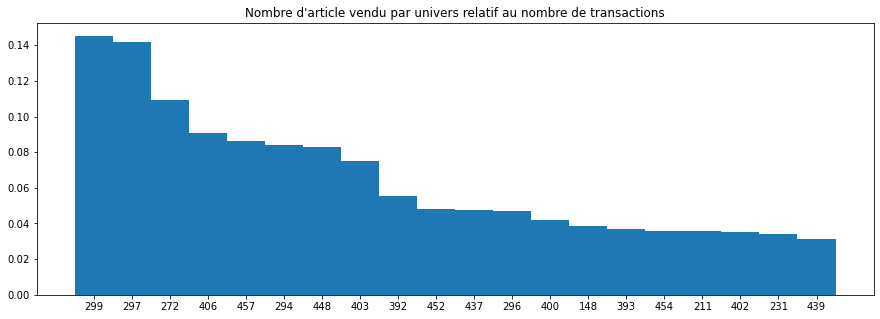

-------------------WEZEMBEEK-OPPEM--------------------------
7861
Time Taken to load recurence: ~0secondes


-------------------E&G BRUGES F2020--------------------------
1918
Time Taken to load recurence: ~0secondes


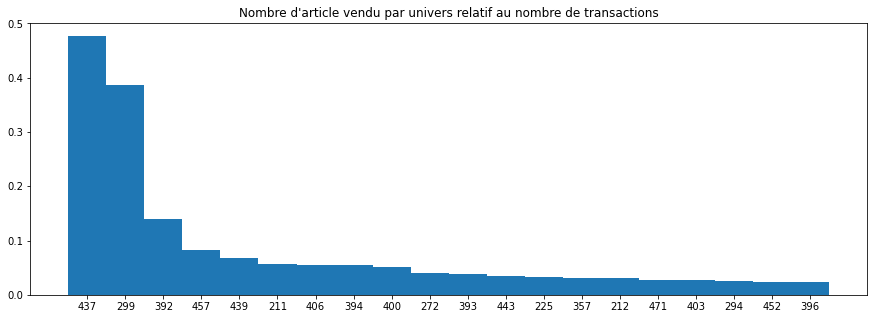

-------------------NEUPRE--------------------------
8736
Time Taken to load recurence: ~0secondes


-------------------LIMAL F 2019--------------------------
5
Time Taken to load recurence: ~0secondes


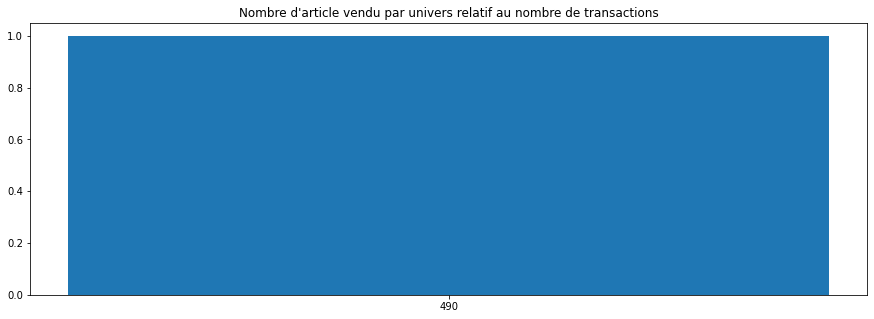

-------------------GRIMBERGEN F 2020--------------------------
12170
Time Taken to load recurence: ~0secondes


-------------------OVERIJSE--------------------------
11238
Time Taken to load recurence: ~0secondes


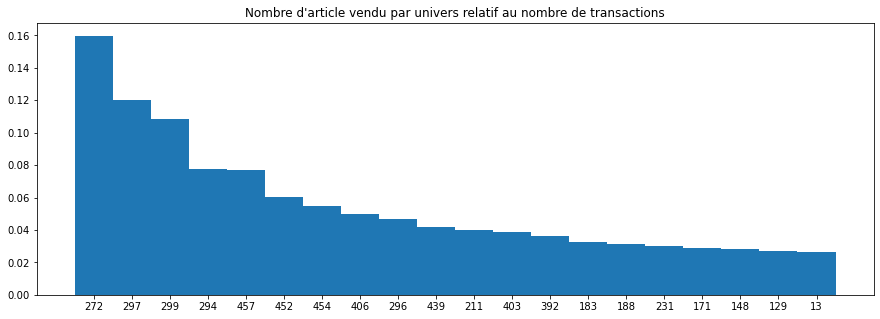

-------------------GANSHOREN--------------------------
16453
Time Taken to load recurence: ~0secondes


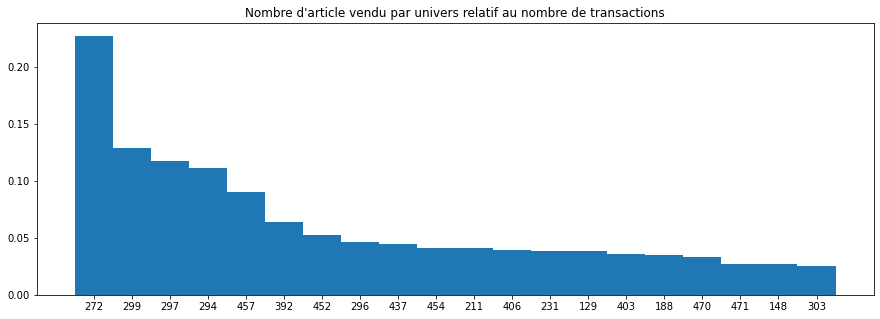

-------------------WOLUWE ST LAMBERT 1--------------------------
12169
Time Taken to load recurence: ~0secondes


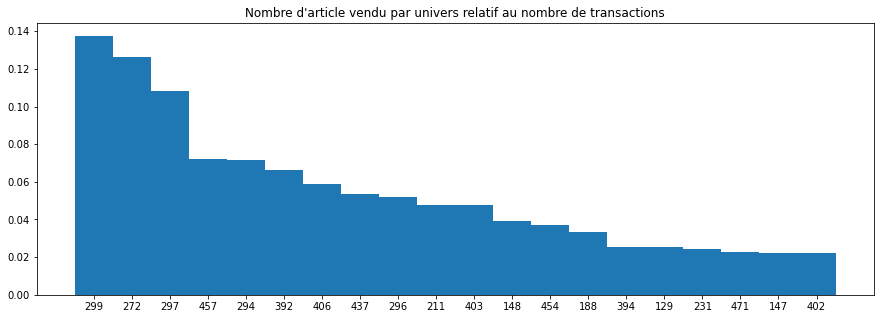

-------------------KRAAINEM--------------------------
12441
Time Taken to load recurence: ~0secondes


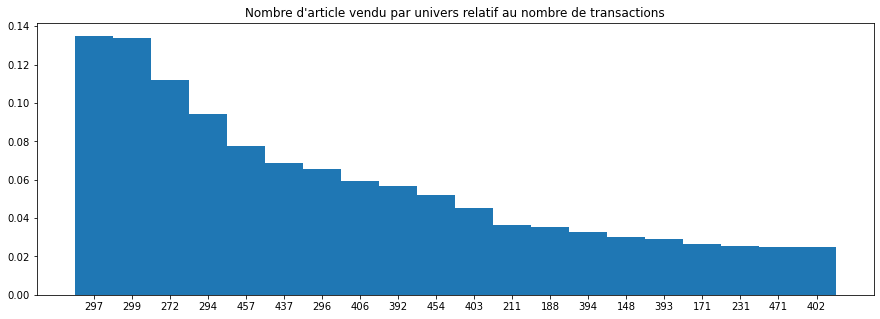

-------------------E&G BXL - GARE CENTRALE--------------------------
31
Time Taken to load recurence: ~0secondes


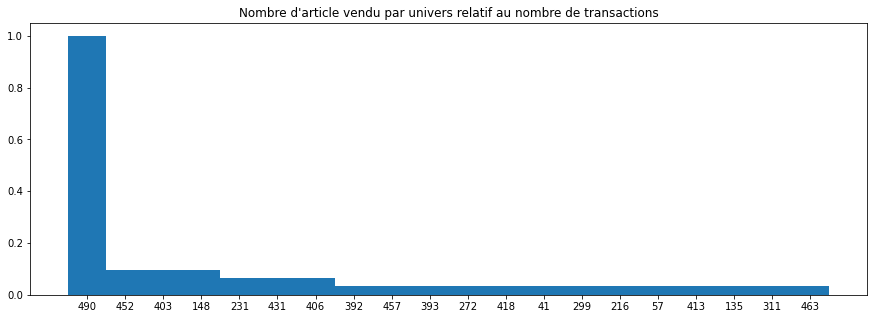

-------------------LA HULPE--------------------------
16094
Time Taken to load recurence: ~0secondes


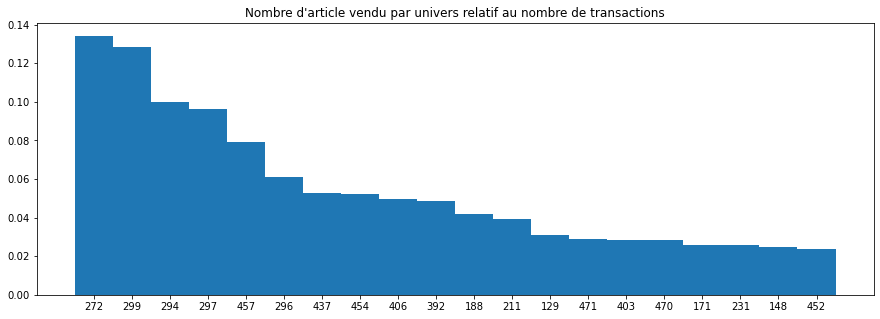

-------------------GENAPPE--------------------------
11712
Time Taken to load recurence: ~0secondes


-------------------COURT SAINT ETIENNE--------------------------
11892
Time Taken to load recurence: ~0secondes


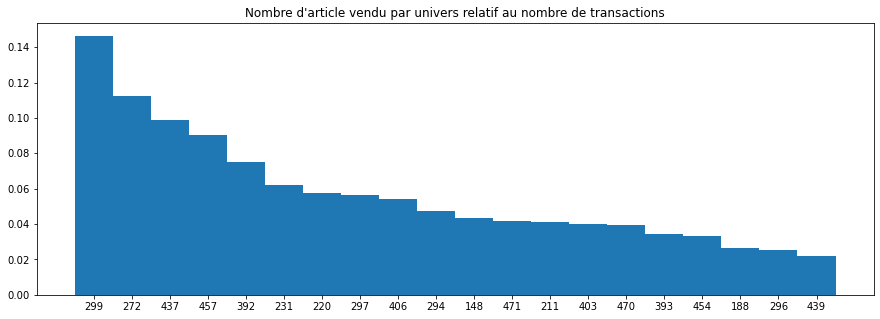

-------------------BRAINE L ALLEUD 1 F 2020--------------------------
7568
Time Taken to load recurence: ~0secondes


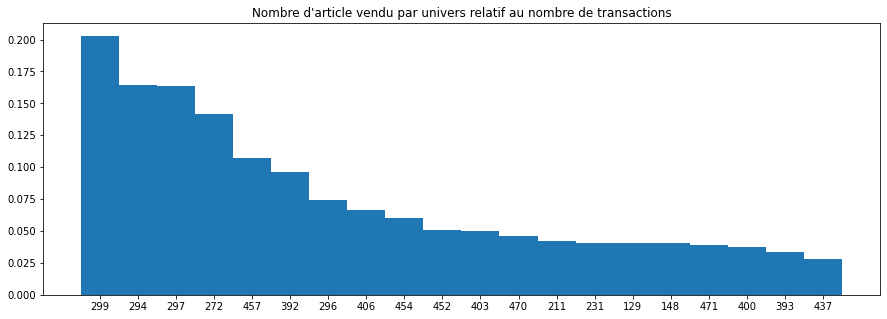

-------------------WATERLOO FAUBOURG--------------------------
18375
Time Taken to load recurence: ~0secondes


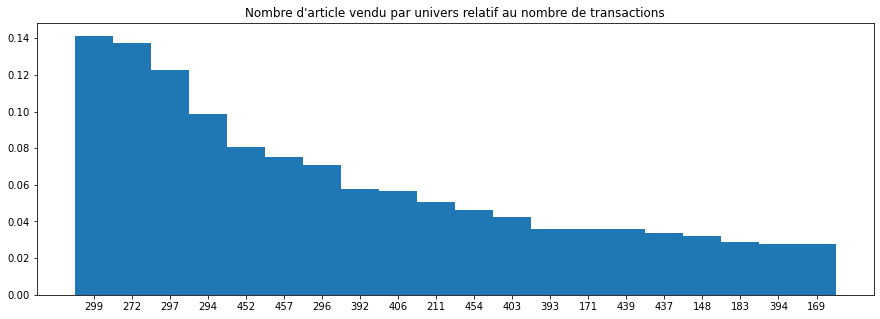

-------------------E&G GEMBLOUX F 2020--------------------------
3781
Time Taken to load recurence: ~0secondes


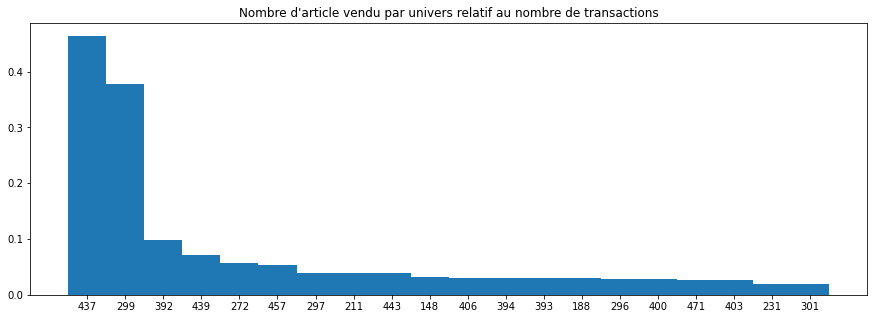

-------------------BOORTMEERBEEK--------------------------
11938
Time Taken to load recurence: ~0secondes


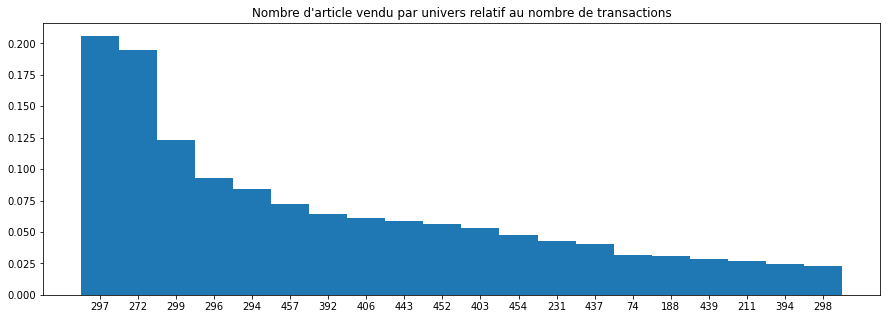

-------------------SINT-MARTENS-LATEM--------------------------
7008
Time Taken to load recurence: ~0secondes


-------------------BRAINE L ALLEUD 1 I 2020--------------------------
0
Time Taken to load recurence: ~0secondes


-------------------ALSEMBERG--------------------------
12032
Time Taken to load recurence: ~0secondes


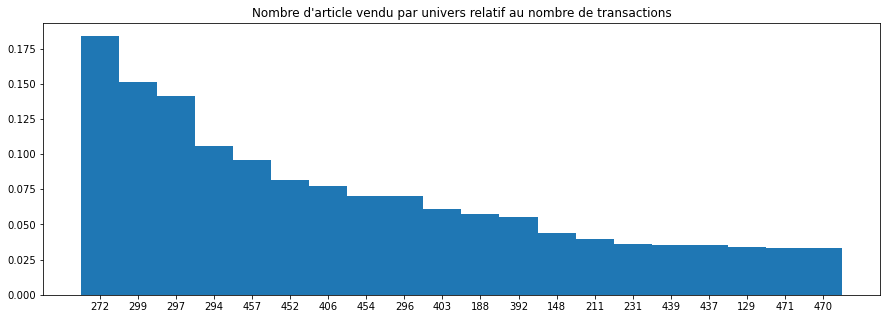

-------------------STRASSEN--------------------------
10920
Time Taken to load recurence: ~0secondes


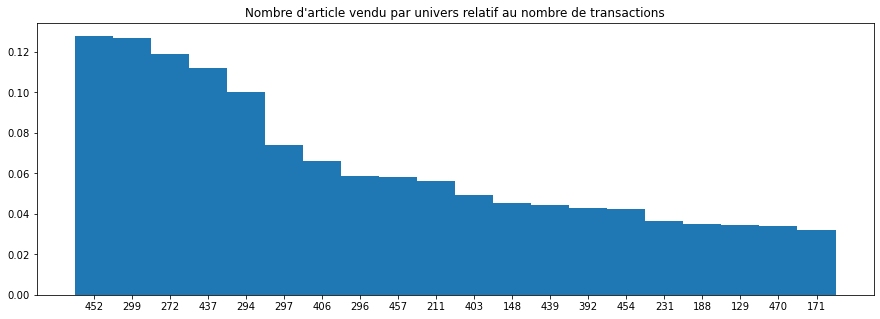

-------------------IXELLES PAGE--------------------------
19939
Time Taken to load recurence: ~0secondes


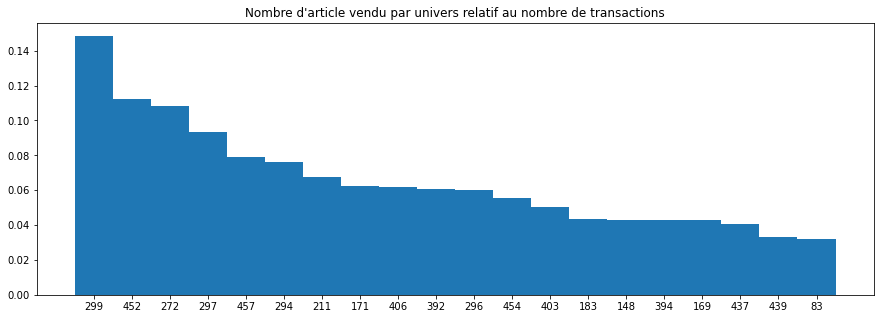

-------------------E&G IXELLES I 2020--------------------------
5279
Time Taken to load recurence: ~0secondes


-------------------E&G LIEGE GUILLEMINS--------------------------
1561
Time Taken to load recurence: ~0secondes


-------------------NIVELLES--------------------------
16262
Time Taken to load recurence: ~0secondes


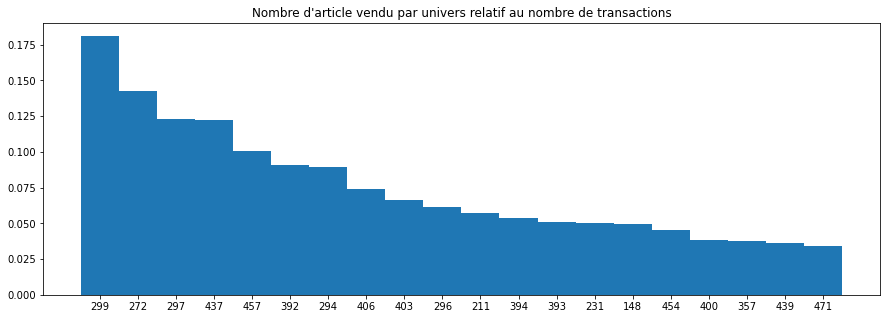

-------------------BRAINE L ALLEUD 2--------------------------
18824
Time Taken to load recurence: ~0secondes


-------------------LIMELETTE--------------------------
10667
Time Taken to load recurence: ~0secondes


-------------------WATERLOO DREVE--------------------------
9382
Time Taken to load recurence: ~0secondes


-------------------ITTRE--------------------------
8459
Time Taken to load recurence: ~0secondes


-------------------WOLUWE ST LAMBERT 2--------------------------
8771
Time Taken to load recurence: ~0secondes


-------------------GREZ DOICEAU--------------------------
8635
Time Taken to load recurence: ~0secondes


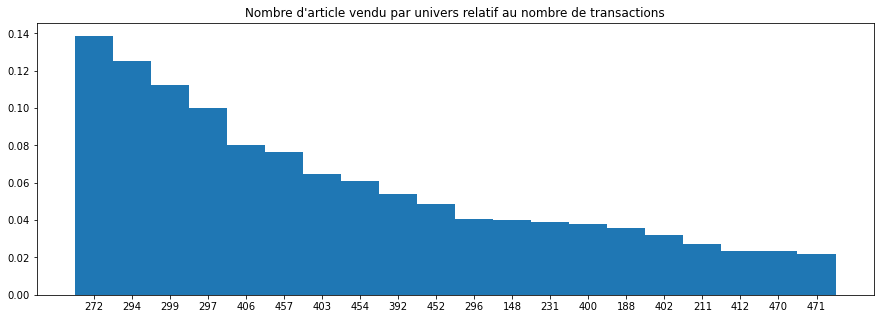

-------------------LILLOIS--------------------------
13786
Time Taken to load recurence: ~0secondes


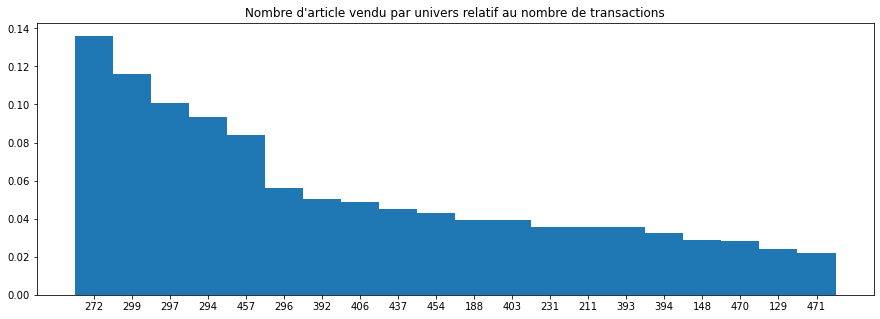

-------------------ARLON--------------------------
10450
Time Taken to load recurence: ~0secondes


-------------------SINT PIETERS LEEUW--------------------------
8717
Time Taken to load recurence: ~0secondes


-------------------UCCLE F 2021--------------------------
9811
Time Taken to load recurence: ~0secondes


-------------------BRAINE LE COMTE--------------------------
8811
Time Taken to load recurence: ~0secondes


-------------------WOLUWE ST PIERRE--------------------------
16323
Time Taken to load recurence: ~0secondes


-------------------WEMMEL--------------------------
16234
Time Taken to load recurence: ~0secondes


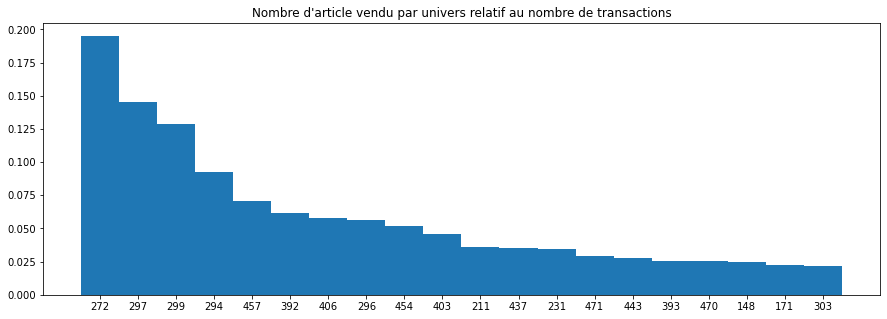

-------------------LIMAL I 2020--------------------------
0
Time Taken to load recurence: ~0secondes


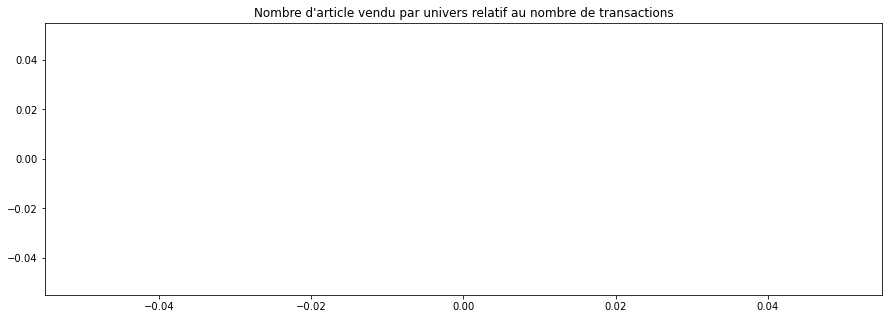

In [75]:
# If do_shop, load recurence for shops
dico_rec_mag = {}
if do_shop:
    for mag_key in all_mag_key:
        print("-------------------" + all_mag_lib[mag_key] + "--------------------------")
        mag_tran = all_mag_tra[mag_key]

        dico_rec_mag[mag_key], mag_nbr_univ = load_recurence(mag_tran)
#         mag_rules = get_rules(mag_tran, min_support, min_confidence, mag_nbr_univ)
#         print_rules(mag_rules, Univers_Depth, conn)

==============0===================
NOT ENOUGH DATA 
==============1===================
NOT ENOUGH DATA 
==============2===================
101
Time Taken to load recurence: ~0secondes


==============3===================
NOT ENOUGH DATA 
==============4===================
155
Time Taken to load recurence: ~0secondes


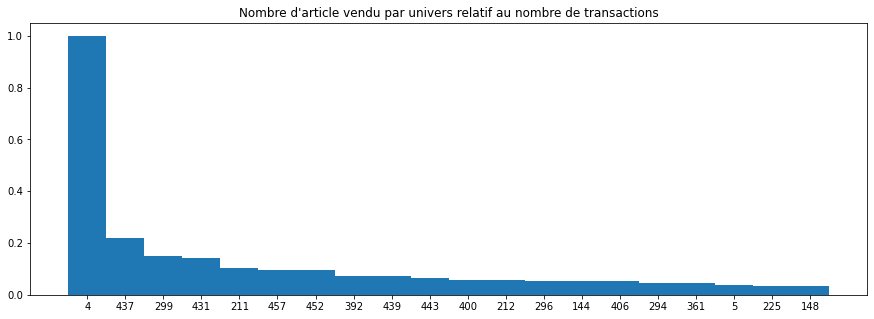

==============5===================
77
Time Taken to load recurence: ~0secondes


==============6===================
NOT ENOUGH DATA 
==============7===================
NOT ENOUGH DATA 
==============8===================
NOT ENOUGH DATA 
==============9===================
1200
Time Taken to load recurence: ~0secondes


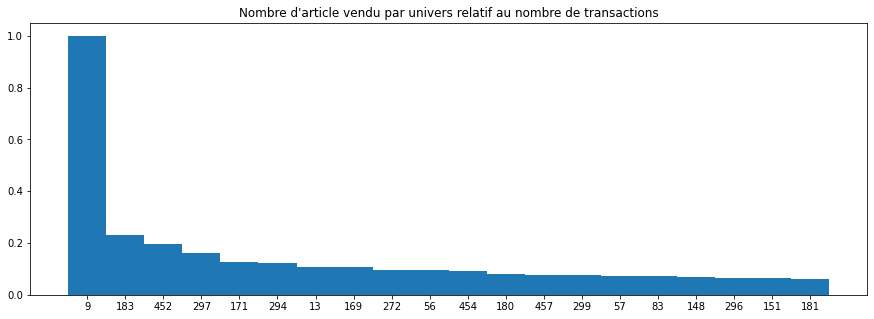

==============10===================
1647
Time Taken to load recurence: ~0secondes


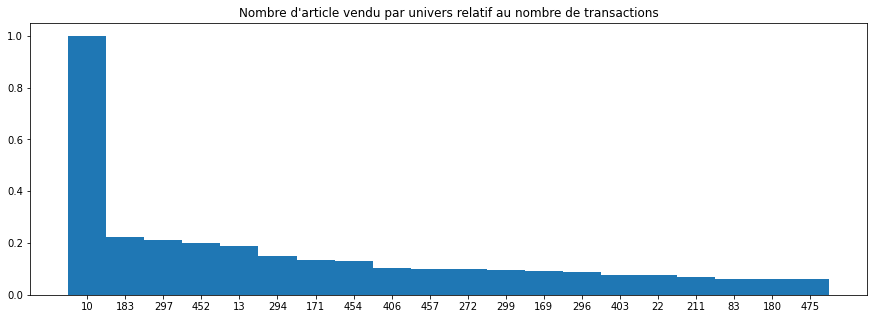

==============11===================
NOT ENOUGH DATA 
==============12===================
144
Time Taken to load recurence: ~0secondes


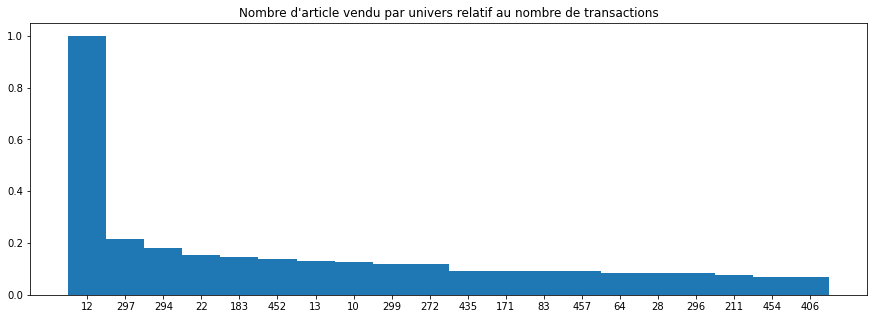

==============13===================
7214
Time Taken to load recurence: ~0secondes


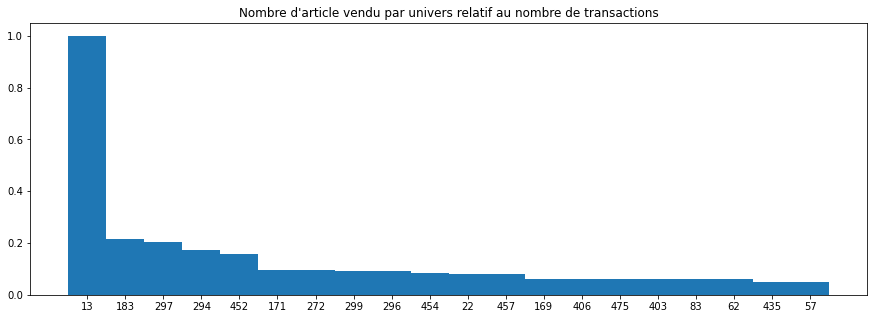

==============14===================
NOT ENOUGH DATA 
==============15===================
NOT ENOUGH DATA 
==============16===================
260
Time Taken to load recurence: ~0secondes


==============17===================
599
Time Taken to load recurence: ~0secondes


==============18===================
4154
Time Taken to load recurence: ~0secondes


==============19===================
1075
Time Taken to load recurence: ~0secondes


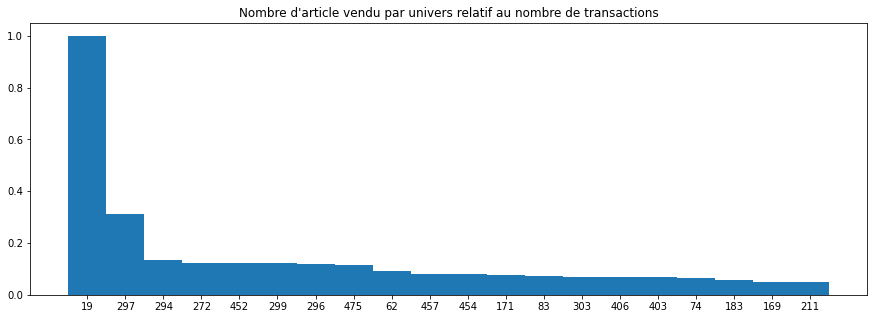

==============20===================
66
Time Taken to load recurence: ~0secondes


==============21===================
NOT ENOUGH DATA 
==============22===================
5073
Time Taken to load recurence: ~0secondes


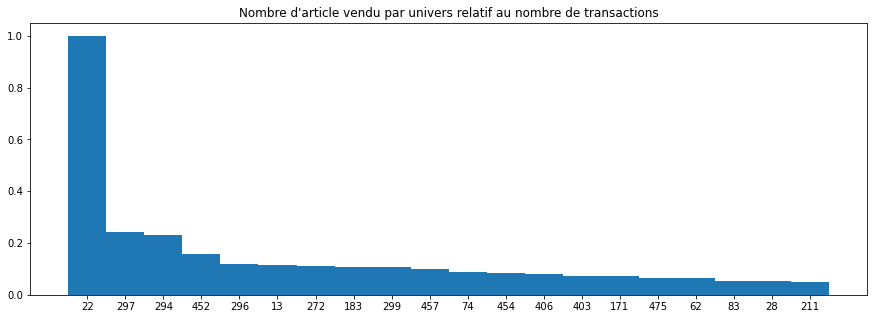

==============23===================
111
Time Taken to load recurence: ~0secondes


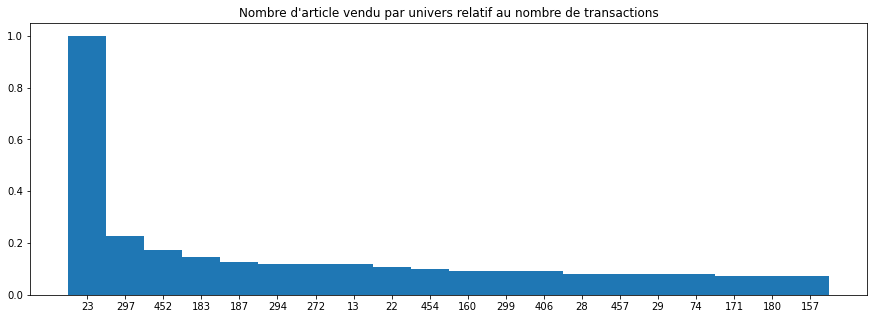

==============24===================
460
Time Taken to load recurence: ~0secondes


==============25===================
1001
Time Taken to load recurence: ~0secondes


==============26===================
NOT ENOUGH DATA 
==============27===================
2696
Time Taken to load recurence: ~0secondes


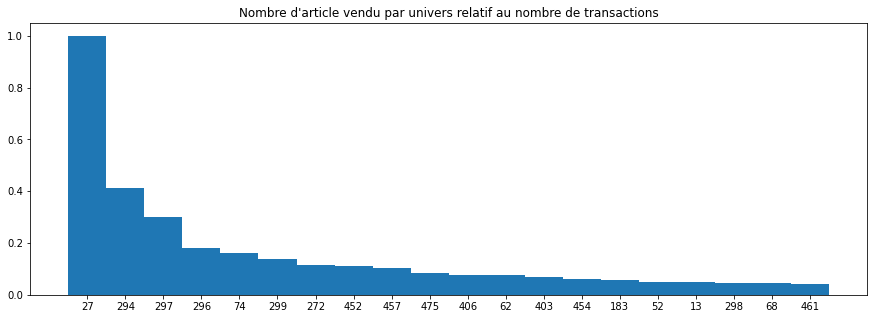

==============28===================
2572
Time Taken to load recurence: ~0secondes


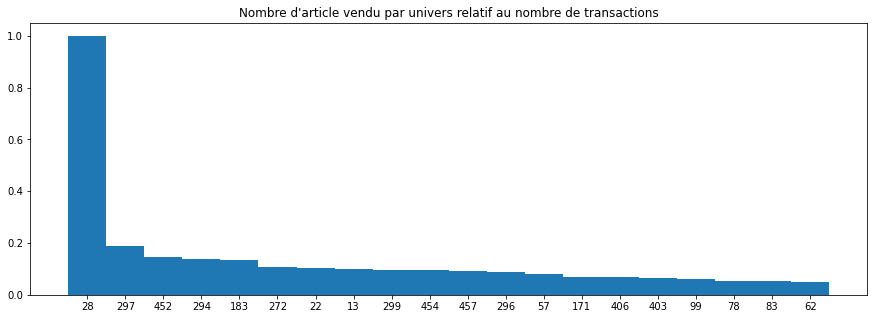

==============29===================
1696
Time Taken to load recurence: ~0secondes


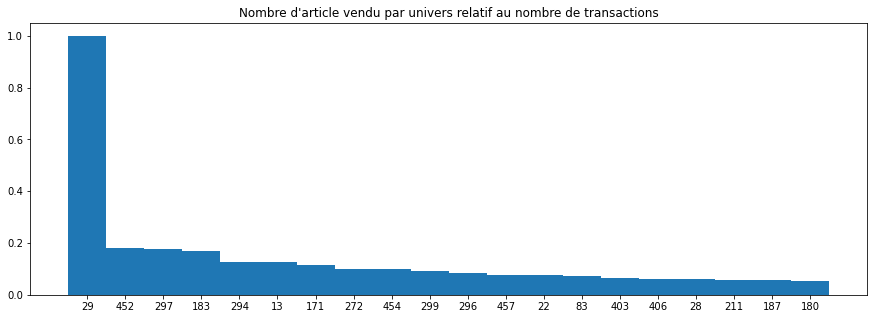

==============30===================
NOT ENOUGH DATA 
==============31===================
NOT ENOUGH DATA 
==============32===================
NOT ENOUGH DATA 
==============33===================
NOT ENOUGH DATA 
==============34===================
NOT ENOUGH DATA 
==============35===================
213
Time Taken to load recurence: ~0secondes


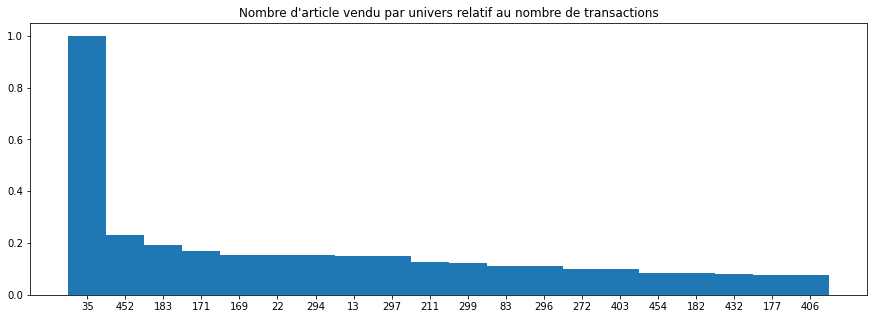

==============36===================
NOT ENOUGH DATA 
==============37===================
3169
Time Taken to load recurence: ~0secondes


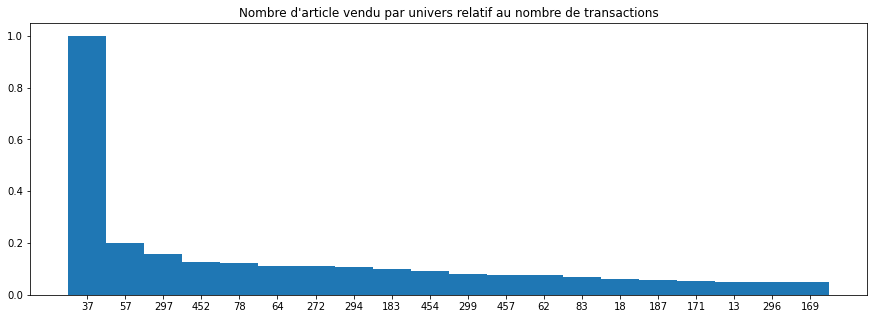

==============38===================
234
Time Taken to load recurence: ~0secondes


==============39===================
914
Time Taken to load recurence: ~0secondes


==============40===================
NOT ENOUGH DATA 
==============41===================
2220
Time Taken to load recurence: ~0secondes


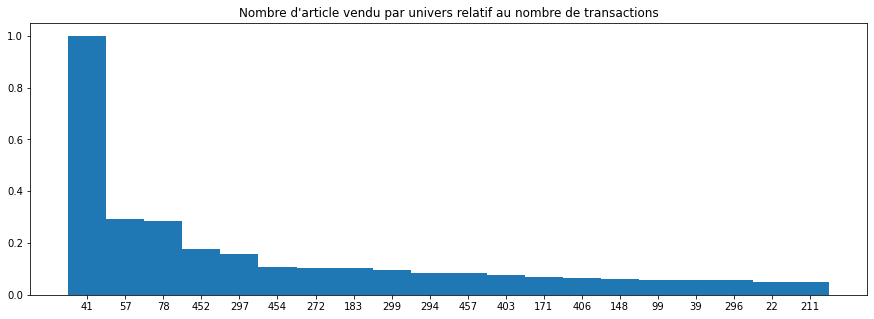

==============42===================
NOT ENOUGH DATA 
==============43===================
555
Time Taken to load recurence: ~0secondes


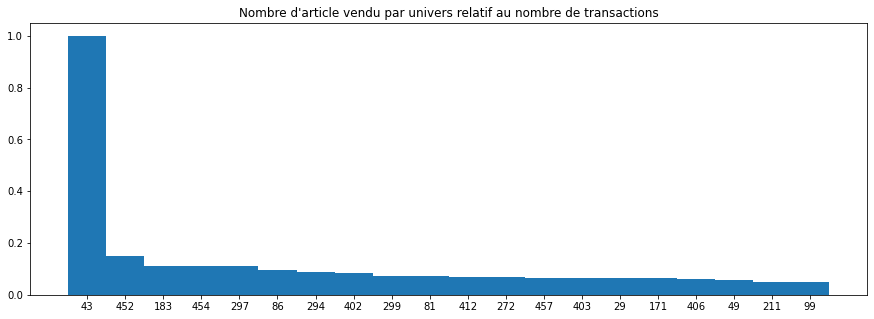

==============44===================
171
Time Taken to load recurence: ~0secondes


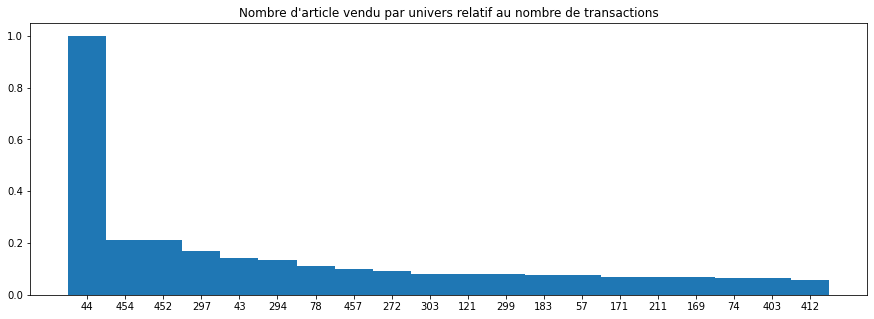

==============45===================
522
Time Taken to load recurence: ~0secondes


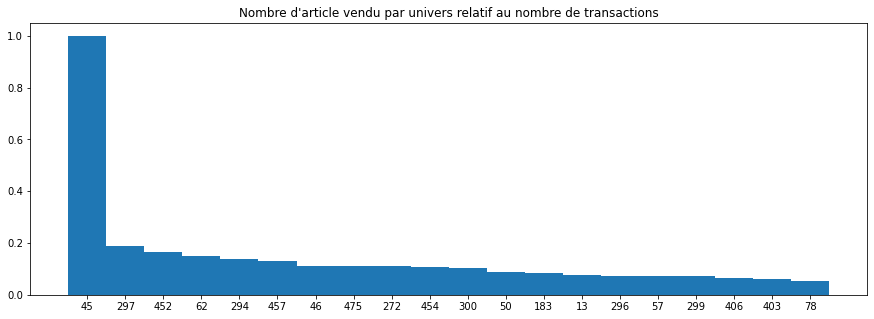

==============46===================
1108
Time Taken to load recurence: ~0secondes


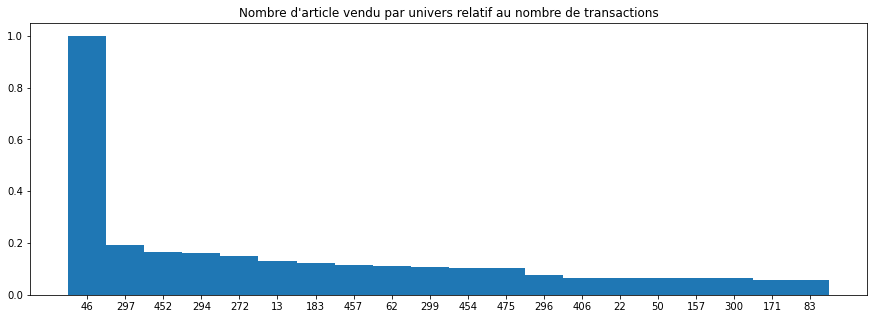

==============47===================
481
Time Taken to load recurence: ~0secondes


==============48===================
217
Time Taken to load recurence: ~0secondes


==============49===================
292
Time Taken to load recurence: ~0secondes


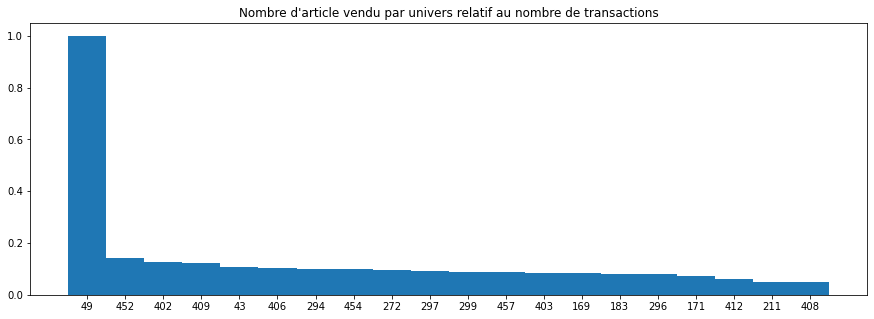

==============50===================
1109
Time Taken to load recurence: ~0secondes


==============51===================
NOT ENOUGH DATA 
==============52===================
4082
Time Taken to load recurence: ~0secondes


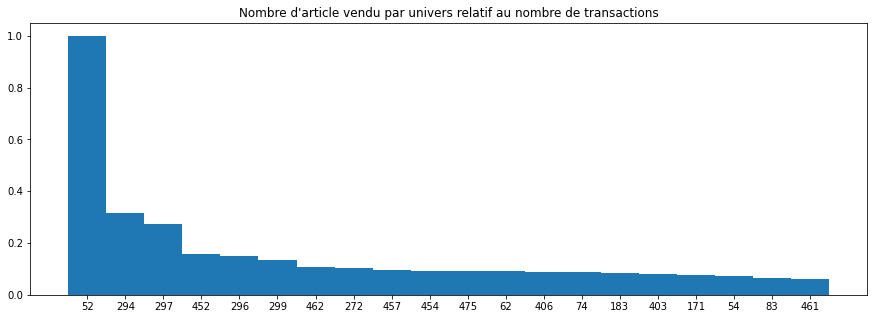

==============53===================
560
Time Taken to load recurence: ~0secondes


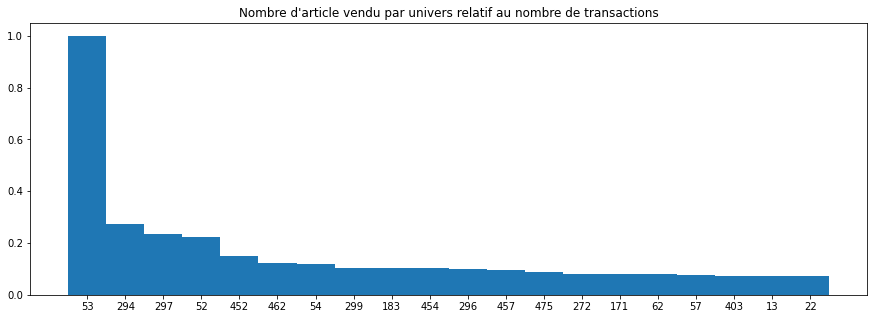

==============54===================
2612
Time Taken to load recurence: ~0secondes


==============55===================
917
Time Taken to load recurence: ~0secondes


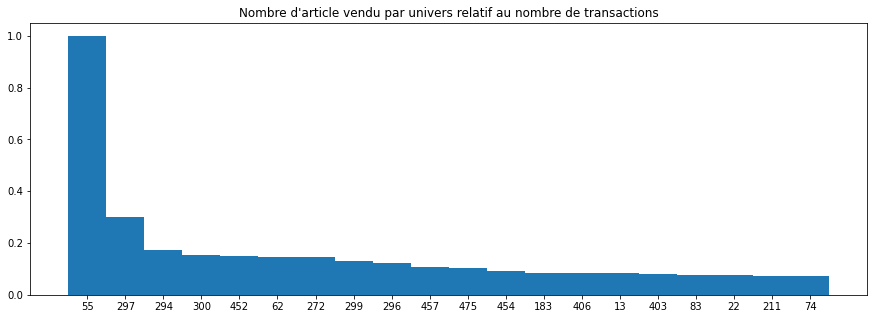

==============56===================
1930
Time Taken to load recurence: ~0secondes


==============57===================
7042
Time Taken to load recurence: ~0secondes


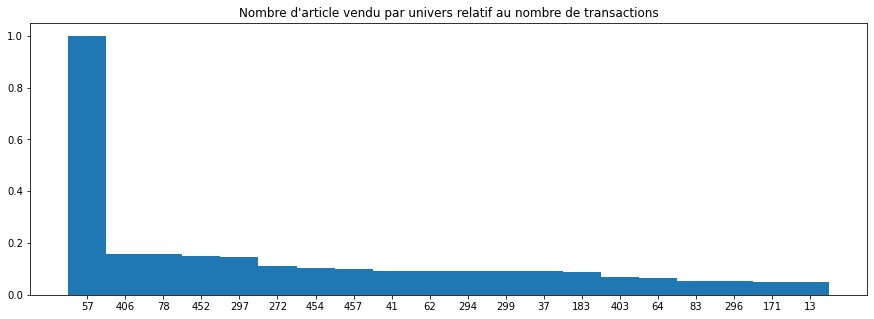

==============58===================
702
Time Taken to load recurence: ~0secondes


==============59===================
1207
Time Taken to load recurence: ~0secondes


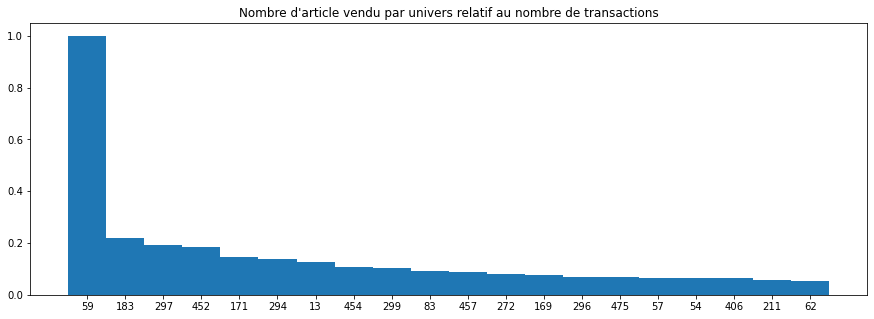

==============60===================
1303
Time Taken to load recurence: ~0secondes


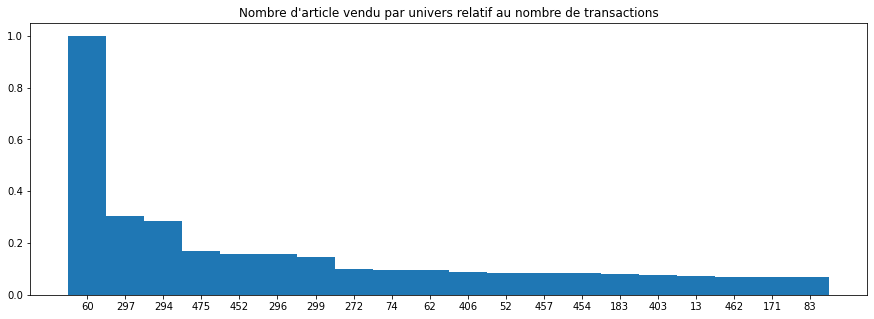

==============61===================
2489
Time Taken to load recurence: ~0secondes


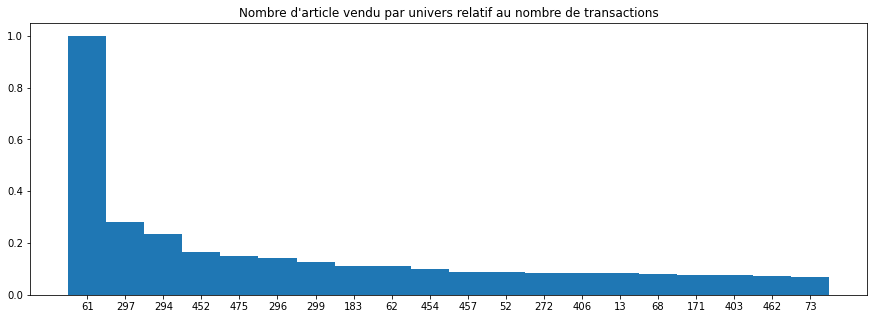

==============62===================
6793
Time Taken to load recurence: ~0secondes


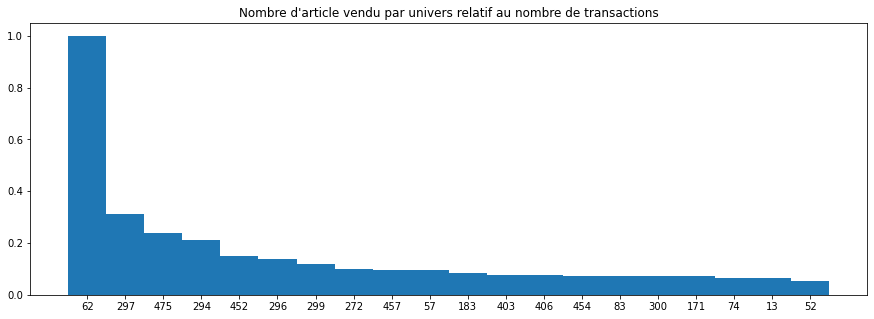

==============63===================
783
Time Taken to load recurence: ~0secondes


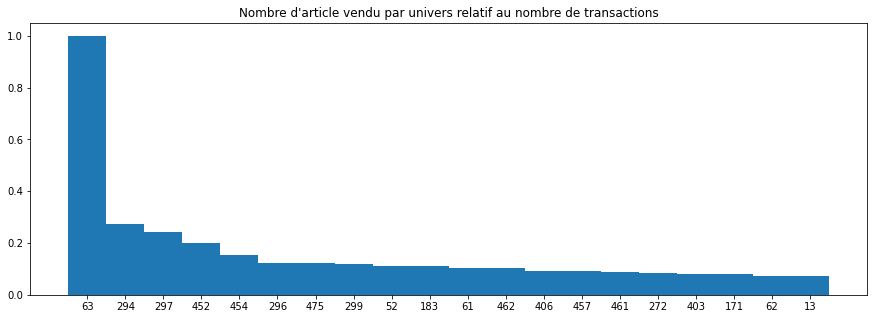

==============64===================
2685
Time Taken to load recurence: ~0secondes


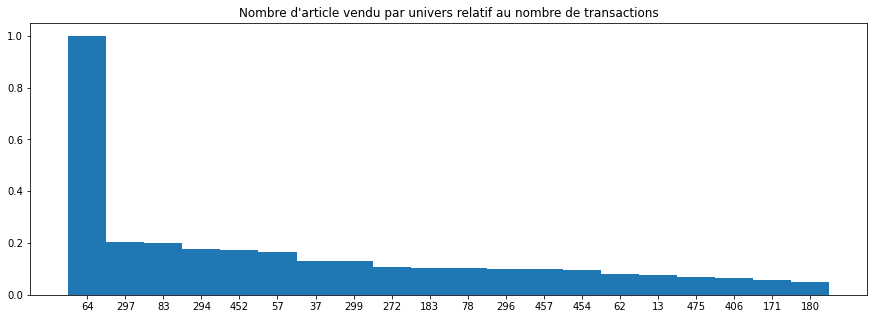

==============65===================
59
Time Taken to load recurence: ~0secondes


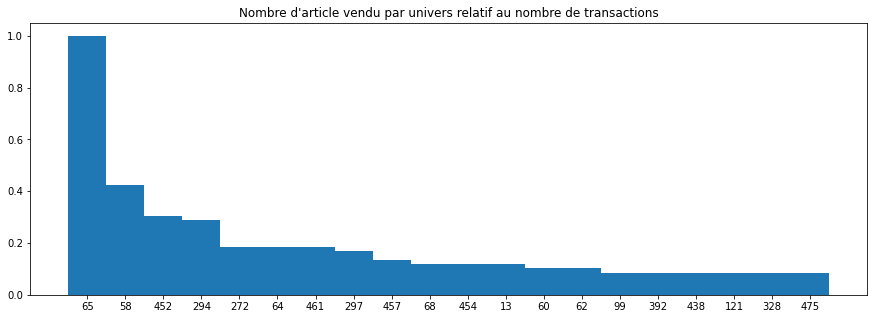

==============66===================
1482
Time Taken to load recurence: ~0secondes


==============67===================
499
Time Taken to load recurence: ~0secondes


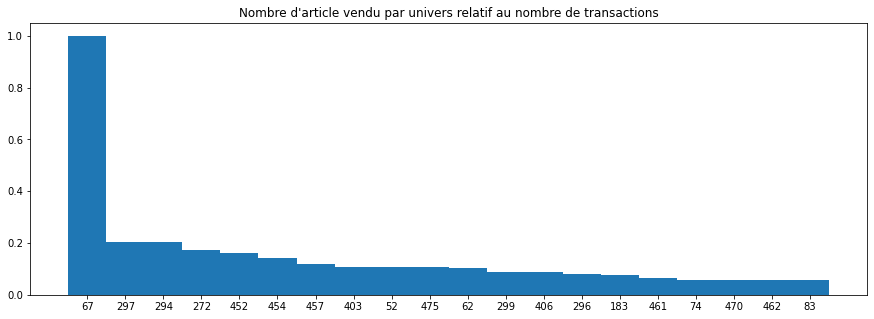

==============68===================
2827
Time Taken to load recurence: ~0secondes


==============69===================
2311
Time Taken to load recurence: ~0secondes


==============70===================
435
Time Taken to load recurence: ~0secondes


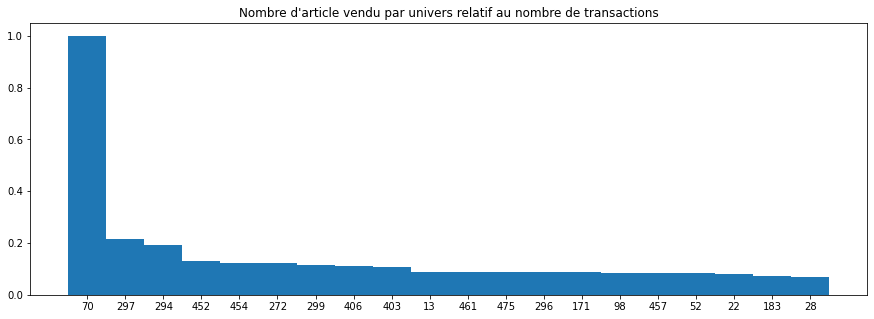

==============71===================
NOT ENOUGH DATA 
==============72===================
1351
Time Taken to load recurence: ~0secondes


==============73===================
1632
Time Taken to load recurence: ~0secondes


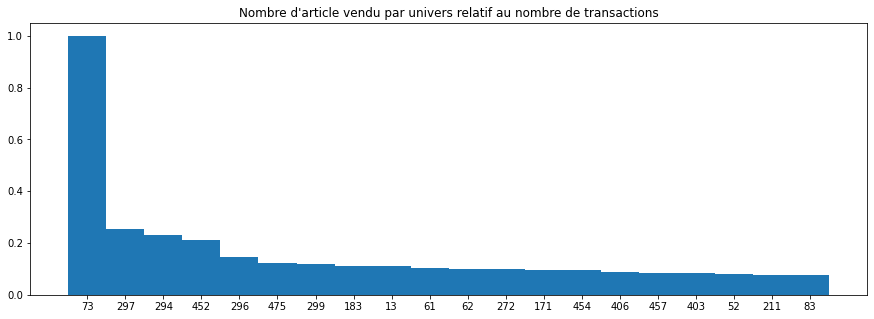

==============74===================
6478
Time Taken to load recurence: ~0secondes


==============75===================
NOT ENOUGH DATA 
==============76===================
148
Time Taken to load recurence: ~0secondes


==============77===================
80
Time Taken to load recurence: ~0secondes


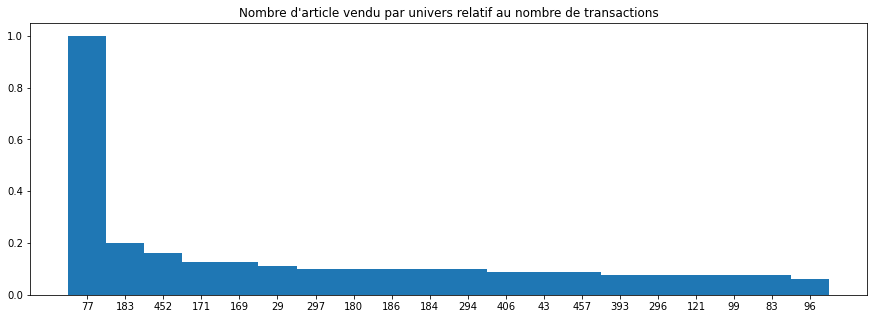

==============78===================
3473
Time Taken to load recurence: ~0secondes


==============79===================
371
Time Taken to load recurence: ~0secondes


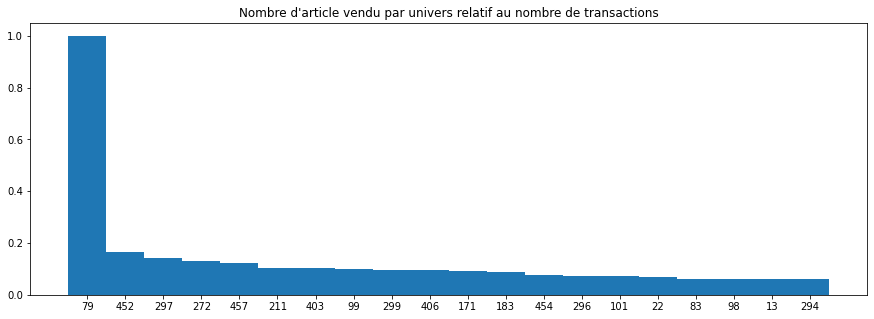

==============80===================
59
Time Taken to load recurence: ~0secondes


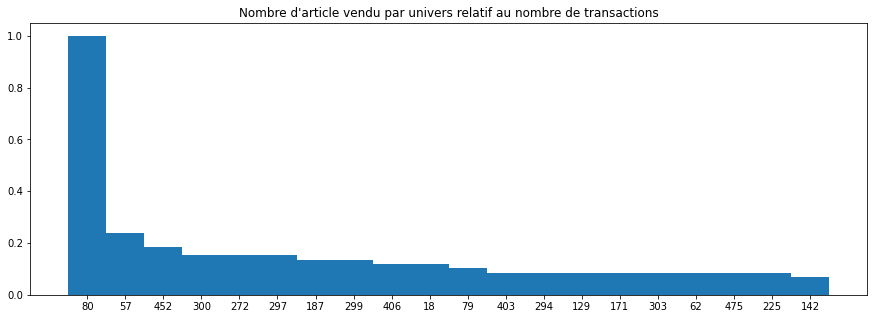

==============81===================
646
Time Taken to load recurence: ~0secondes


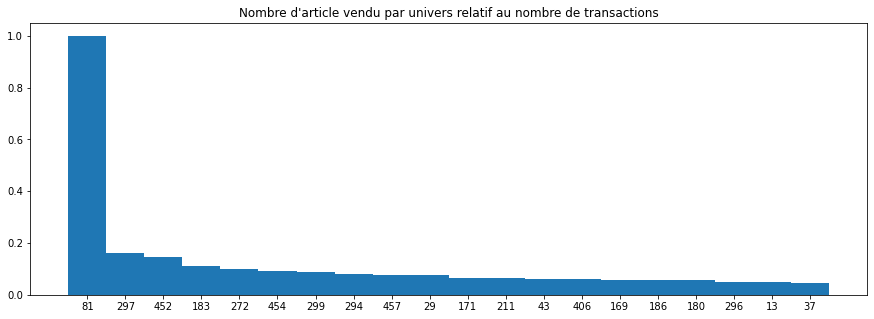

==============82===================
NOT ENOUGH DATA 
==============83===================
6998
Time Taken to load recurence: ~0secondes


==============84===================
358
Time Taken to load recurence: ~0secondes


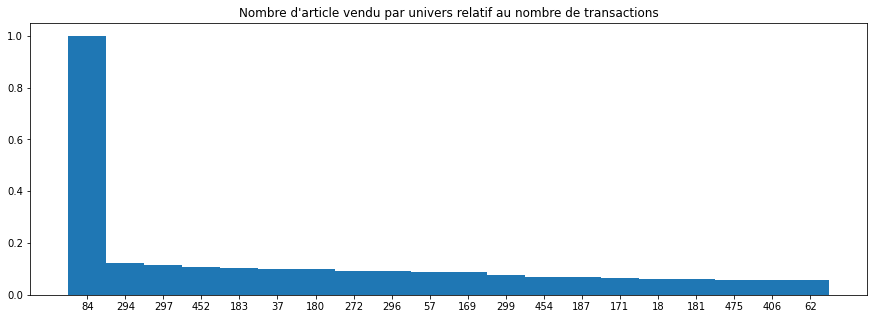

==============85===================
411
Time Taken to load recurence: ~0secondes


==============86===================
1227
Time Taken to load recurence: ~0secondes


==============87===================
NOT ENOUGH DATA 
==============88===================
460
Time Taken to load recurence: ~0secondes


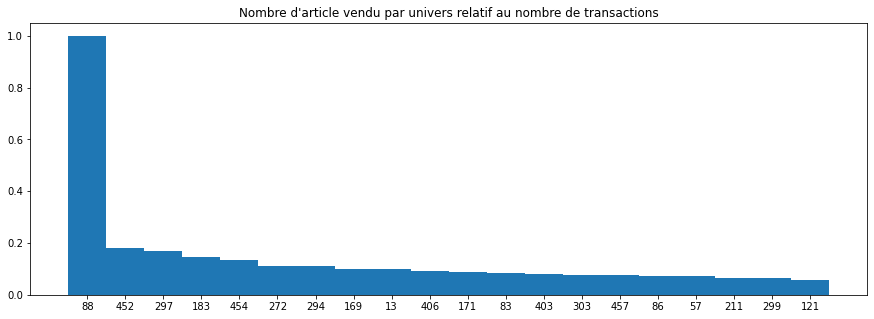

==============89===================
164
Time Taken to load recurence: ~0secondes


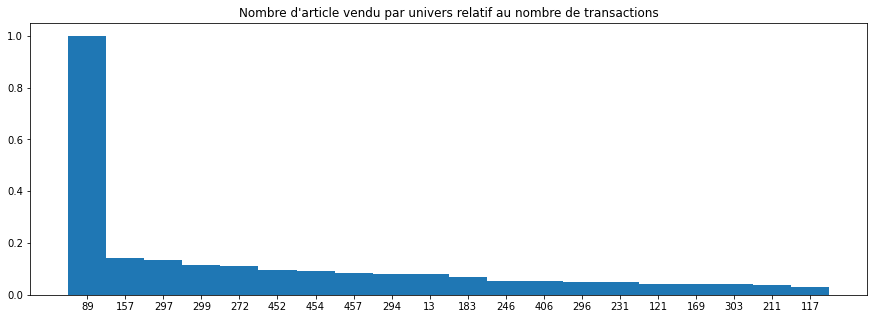

==============90===================
179
Time Taken to load recurence: ~0secondes


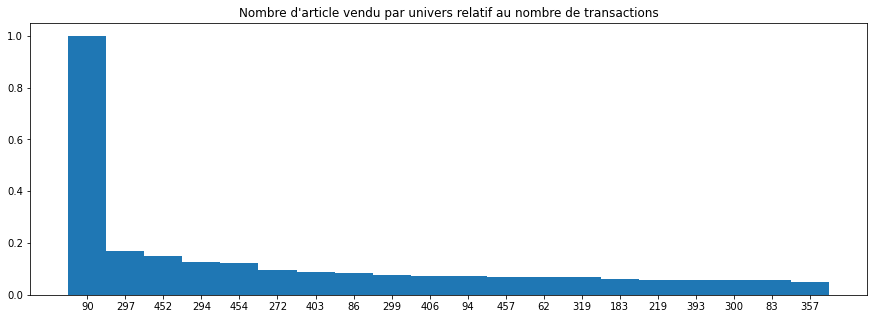

==============91===================
252
Time Taken to load recurence: ~0secondes


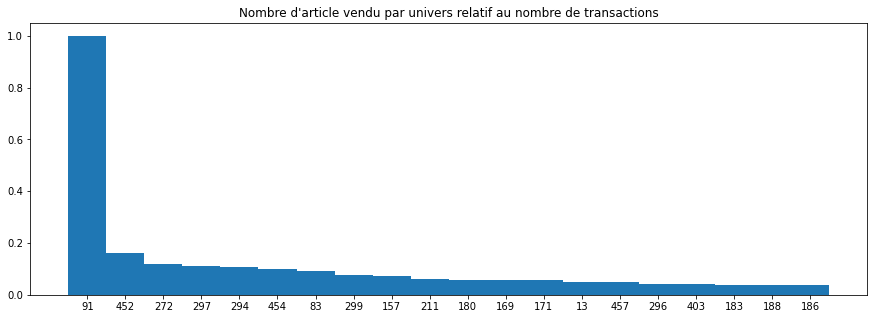

==============92===================
482
Time Taken to load recurence: ~0secondes


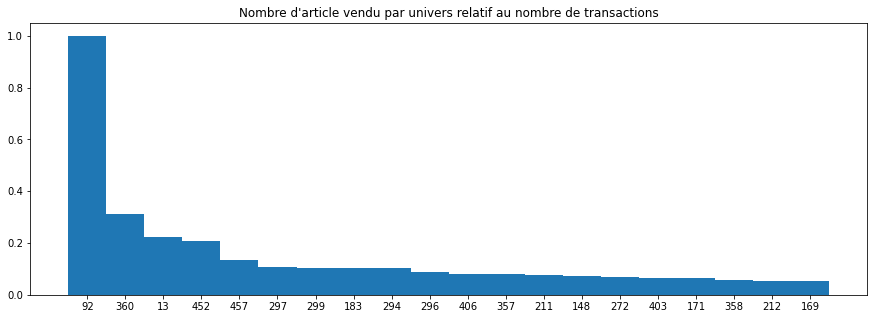

==============93===================
237
Time Taken to load recurence: ~0secondes


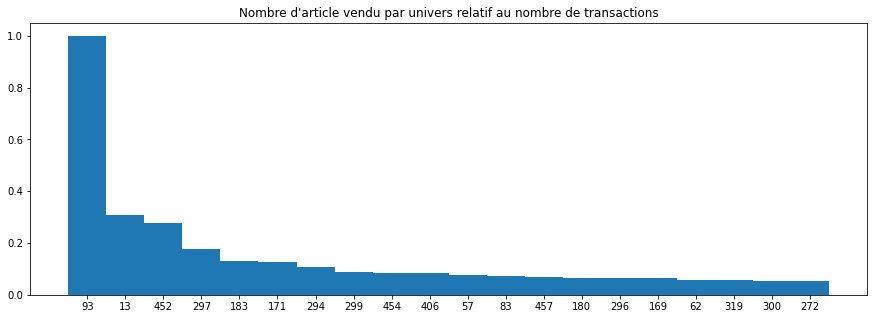

==============94===================
253
Time Taken to load recurence: ~0secondes


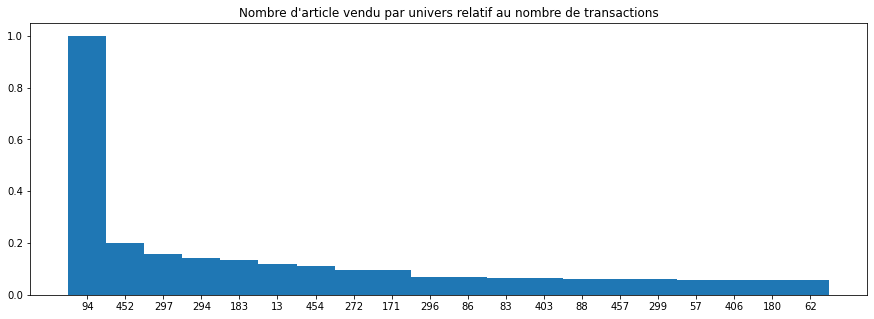

==============95===================
474
Time Taken to load recurence: ~0secondes


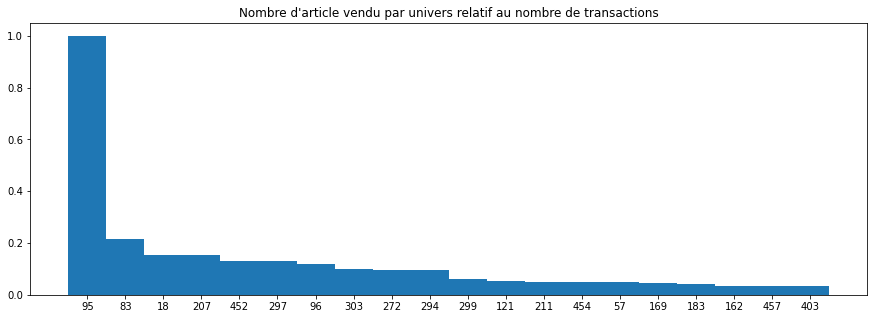

==============96===================
656
Time Taken to load recurence: ~0secondes


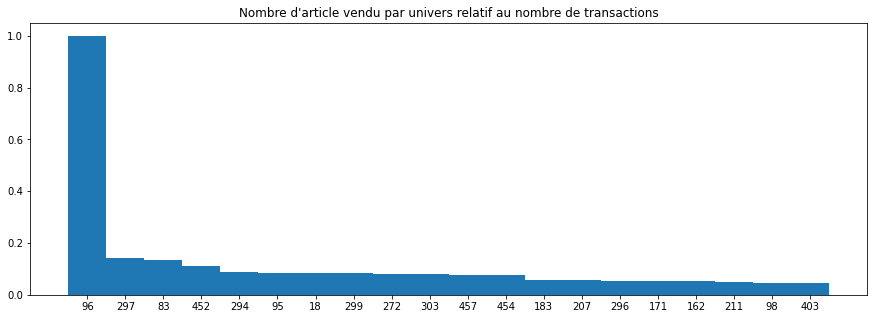

==============97===================
NOT ENOUGH DATA 
==============98===================
1832
Time Taken to load recurence: ~0secondes


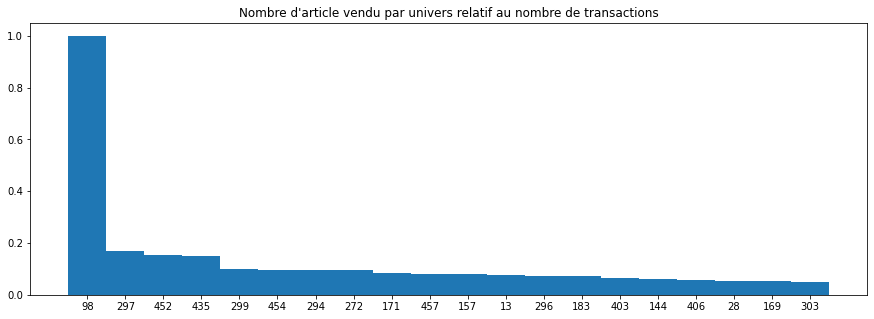

==============99===================
2424
Time Taken to load recurence: ~0secondes


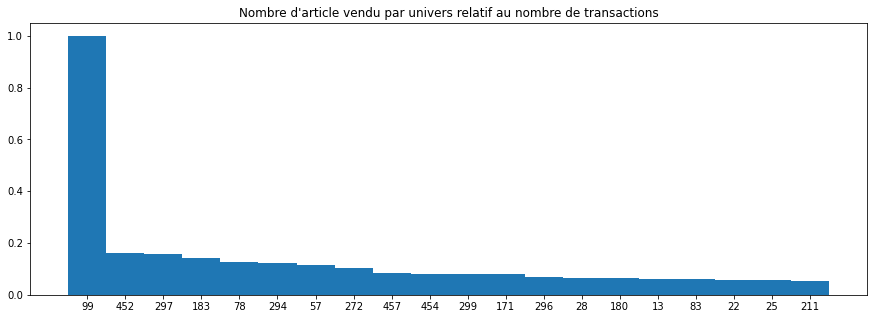

==============100===================
955
Time Taken to load recurence: ~0secondes


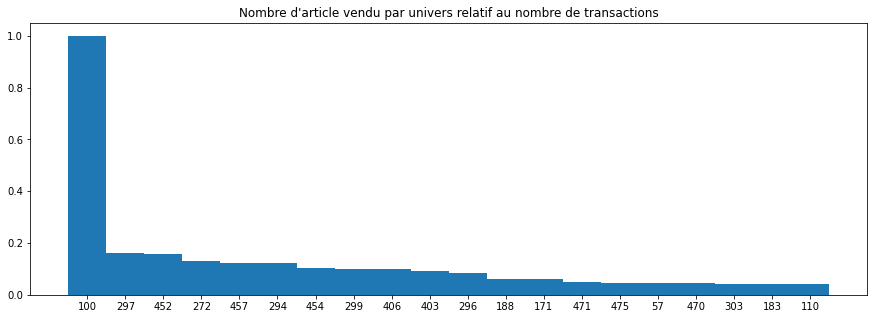

==============101===================
895
Time Taken to load recurence: ~0secondes


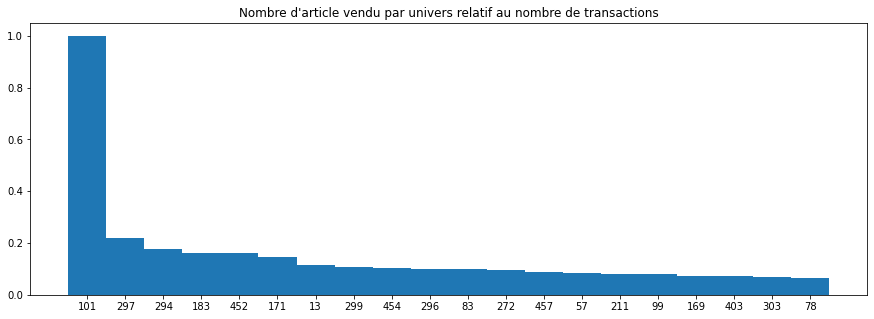

==============102===================
365
Time Taken to load recurence: ~0secondes


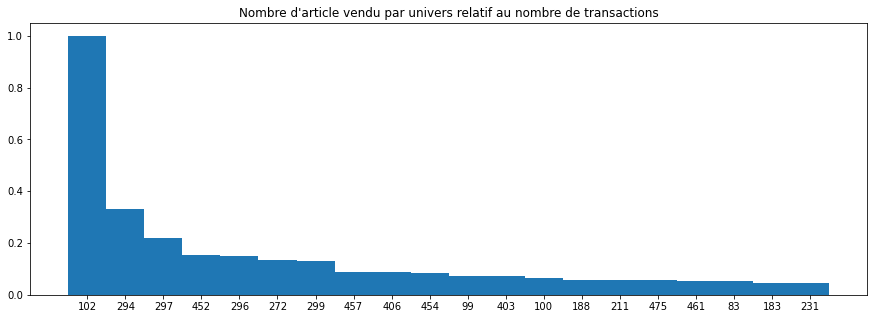

==============103===================
NOT ENOUGH DATA 
==============104===================
NOT ENOUGH DATA 
==============105===================
144
Time Taken to load recurence: ~0secondes


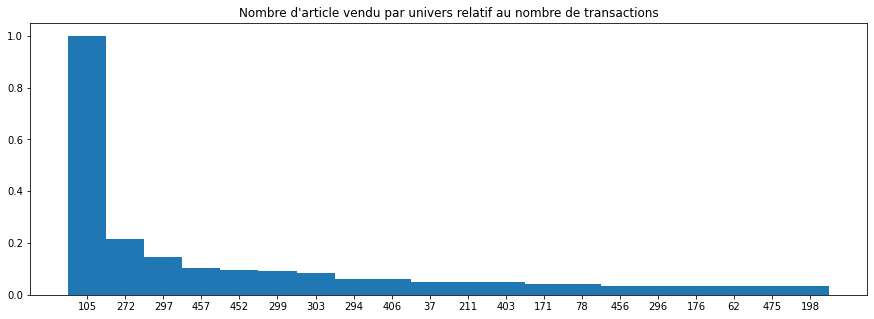

==============106===================
163
Time Taken to load recurence: ~0secondes


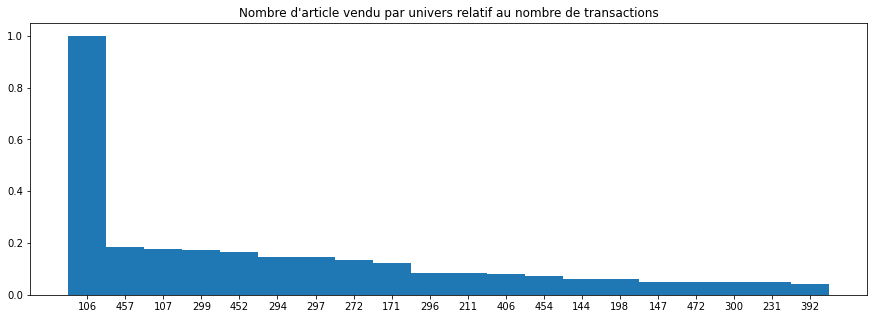

==============107===================
211
Time Taken to load recurence: ~0secondes


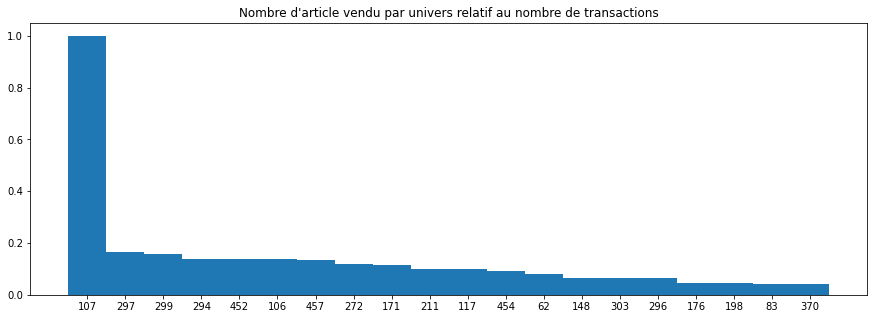

==============108===================
63
Time Taken to load recurence: ~0secondes


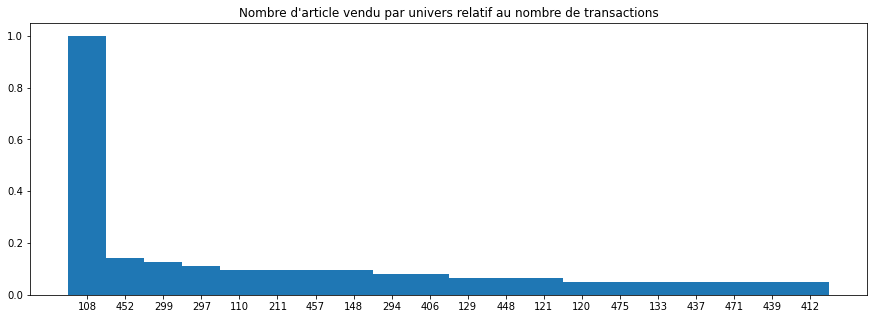

==============109===================
299
Time Taken to load recurence: ~0secondes


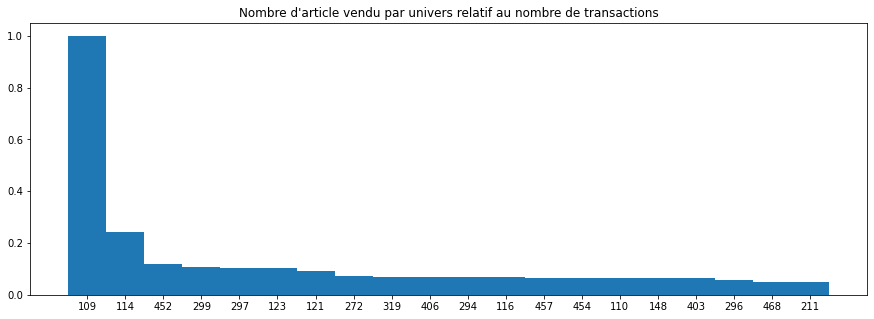

==============110===================
5782
Time Taken to load recurence: ~0secondes


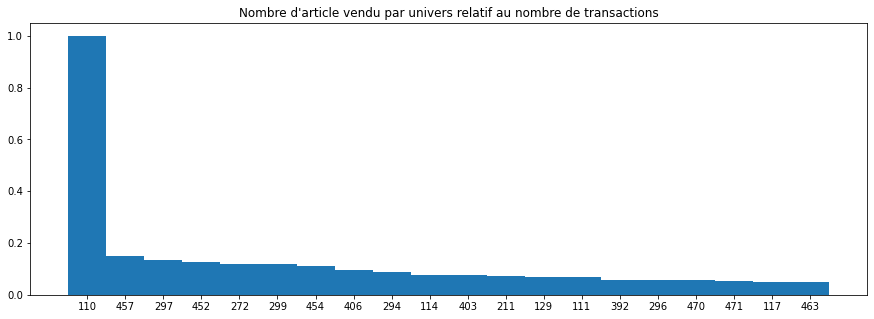

==============111===================
3882
Time Taken to load recurence: ~0secondes


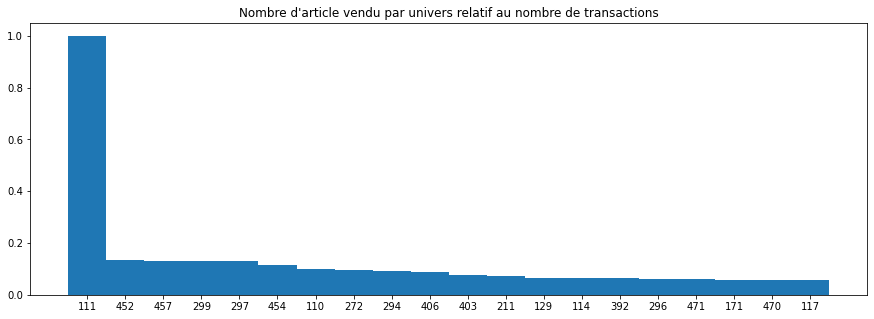

==============112===================
354
Time Taken to load recurence: ~0secondes


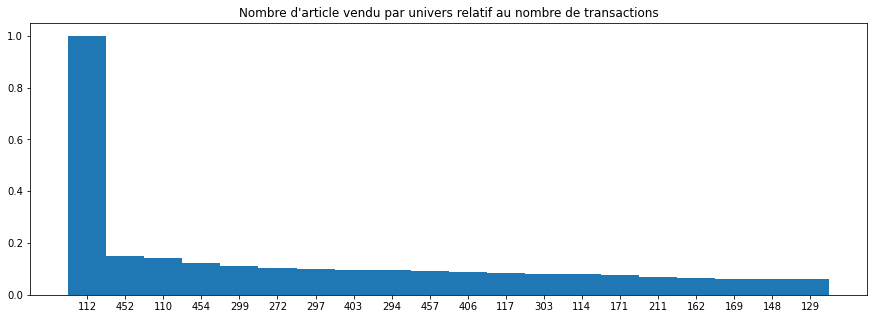

==============113===================
2477
Time Taken to load recurence: ~0secondes


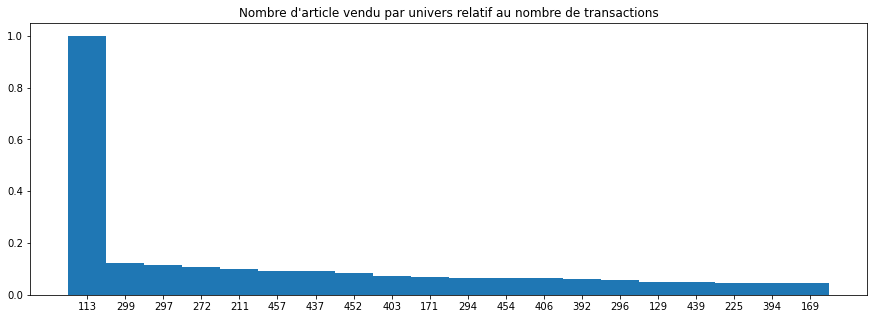

==============114===================
4692
Time Taken to load recurence: ~0secondes


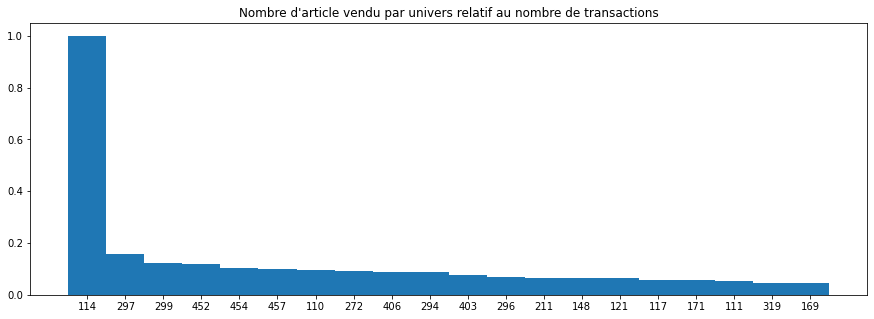

==============115===================
2071
Time Taken to load recurence: ~0secondes


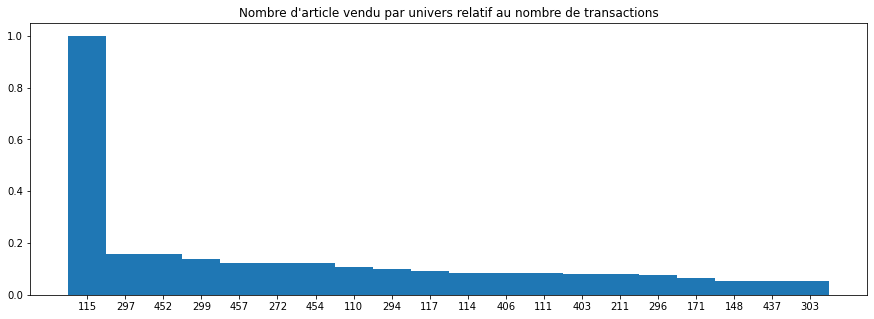

==============116===================
2337
Time Taken to load recurence: ~0secondes


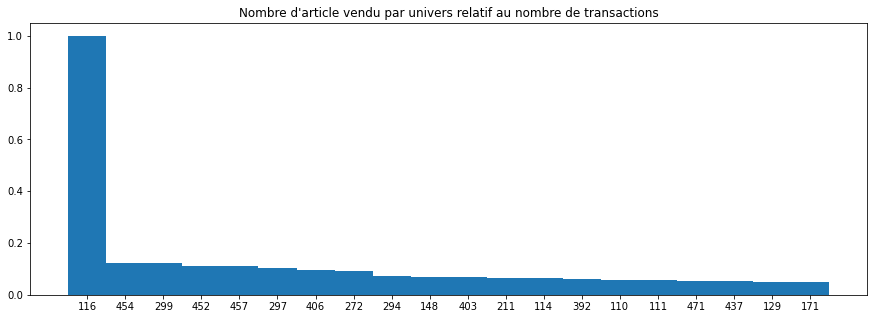

==============117===================
5545
Time Taken to load recurence: ~0secondes


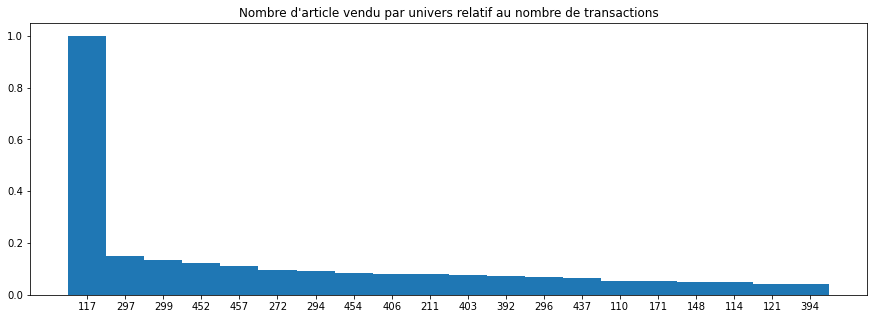

==============118===================
97
Time Taken to load recurence: ~0secondes


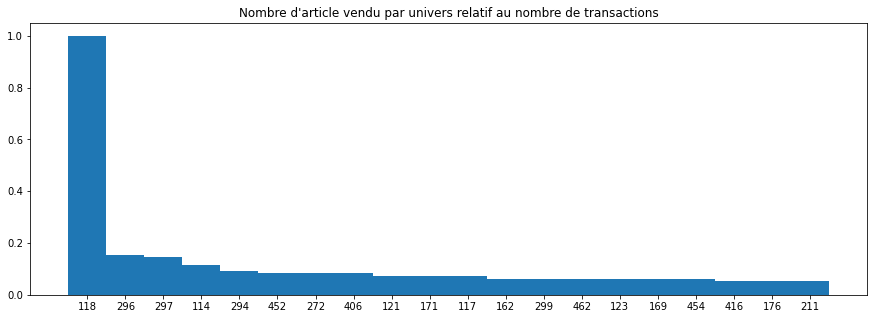

==============119===================
373
Time Taken to load recurence: ~0secondes


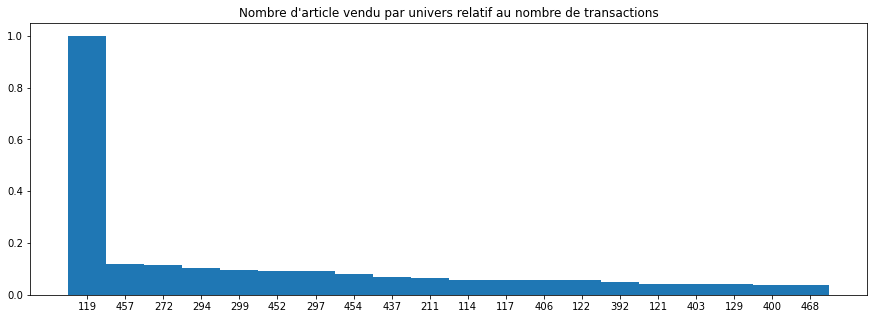

==============120===================
5743
Time Taken to load recurence: ~0secondes


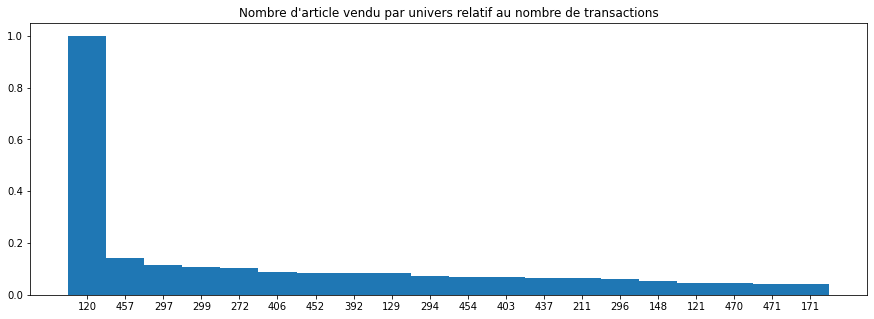

==============121===================
5998
Time Taken to load recurence: ~0secondes


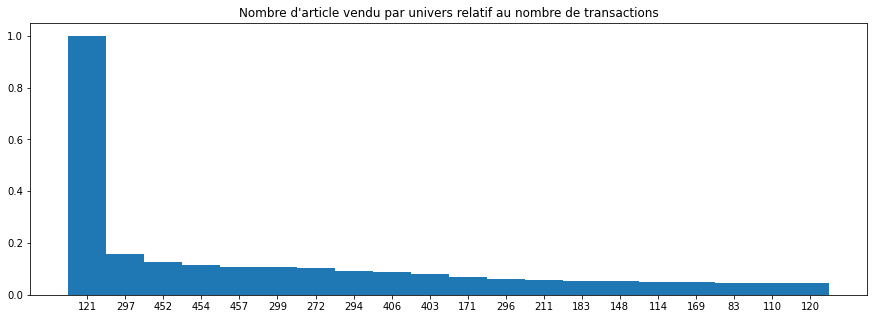

==============122===================
1108
Time Taken to load recurence: ~0secondes


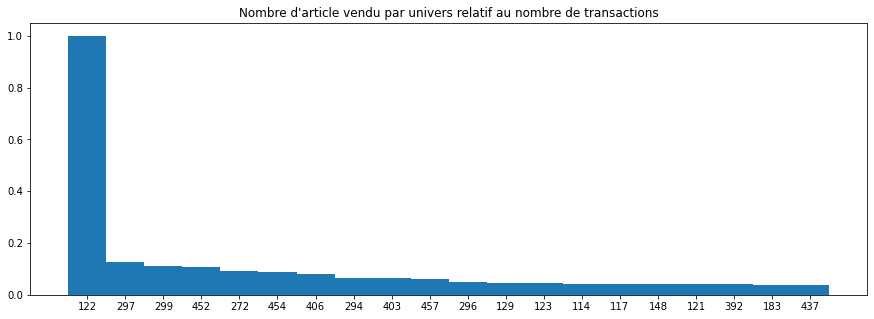

==============123===================
2244
Time Taken to load recurence: ~0secondes


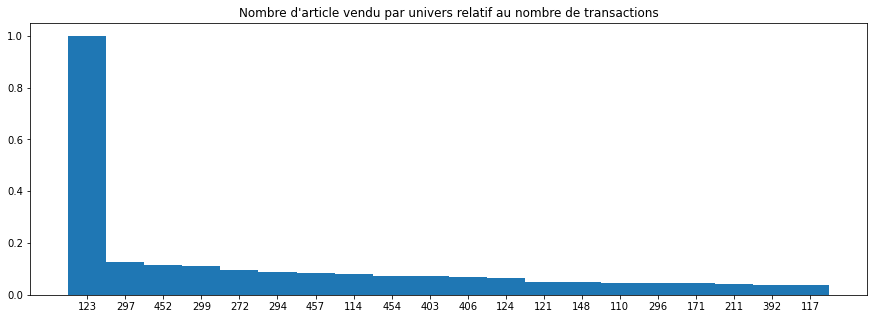

==============124===================
1417
Time Taken to load recurence: ~0secondes


==============125===================
NOT ENOUGH DATA 
==============126===================
4438
Time Taken to load recurence: ~0secondes


==============127===================
479
Time Taken to load recurence: ~0secondes


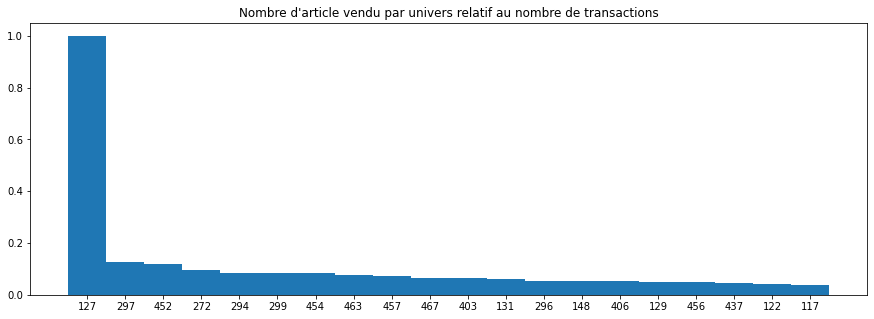

==============128===================
621
Time Taken to load recurence: ~0secondes


==============129===================
10362
Time Taken to load recurence: ~0secondes


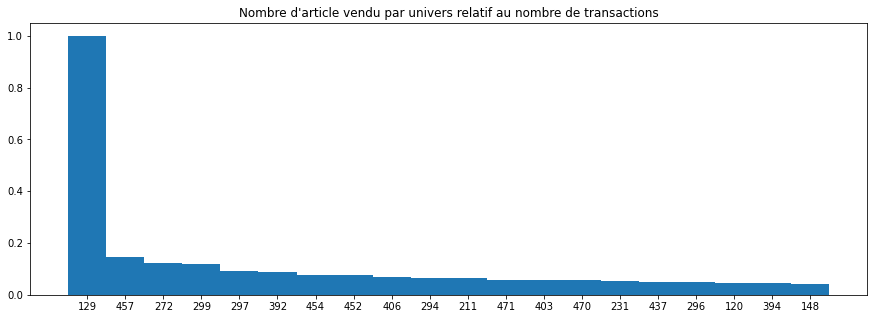

==============130===================
1984
Time Taken to load recurence: ~0secondes


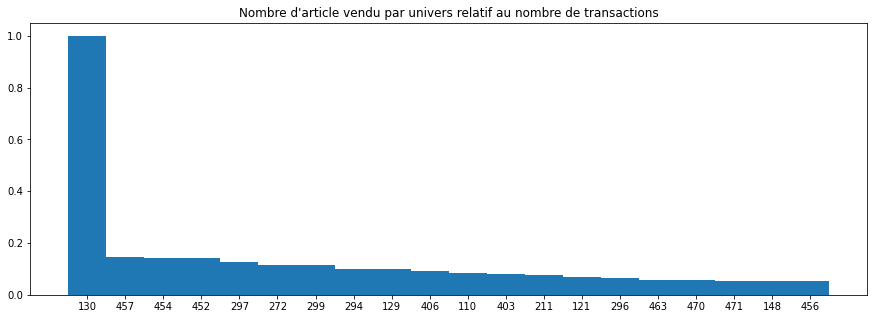

==============131===================
1588
Time Taken to load recurence: ~0secondes


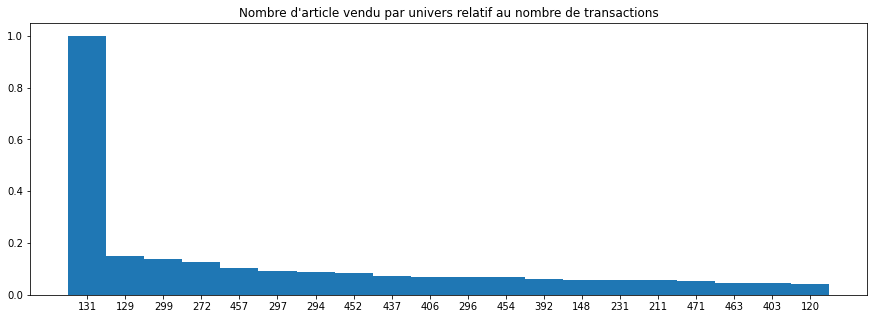

==============132===================
2693
Time Taken to load recurence: ~0secondes


==============133===================
2360
Time Taken to load recurence: ~0secondes


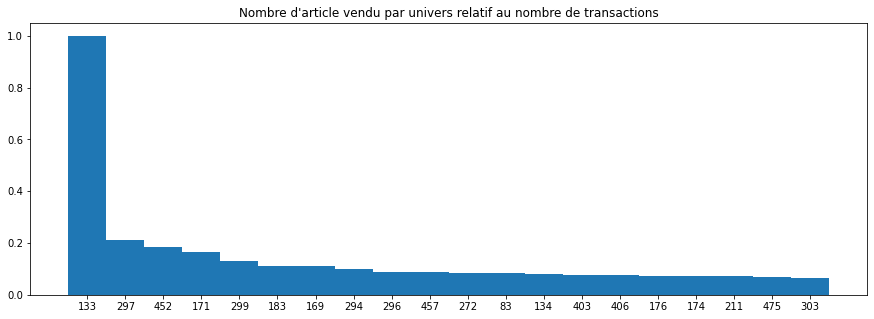

==============134===================
3994
Time Taken to load recurence: ~0secondes


==============135===================
1273
Time Taken to load recurence: ~0secondes


==============136===================
890
Time Taken to load recurence: ~0secondes


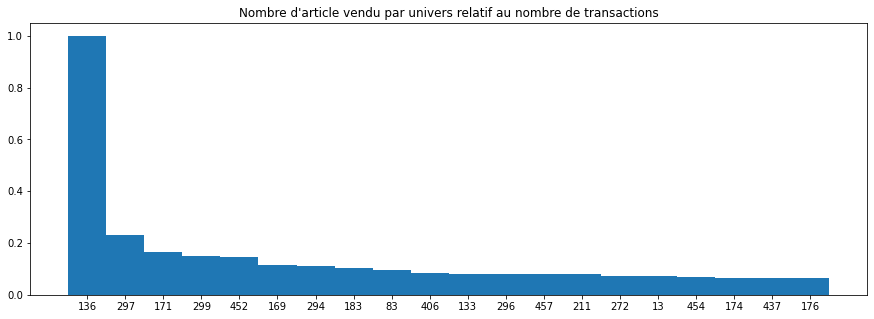

==============137===================
1939
Time Taken to load recurence: ~0secondes


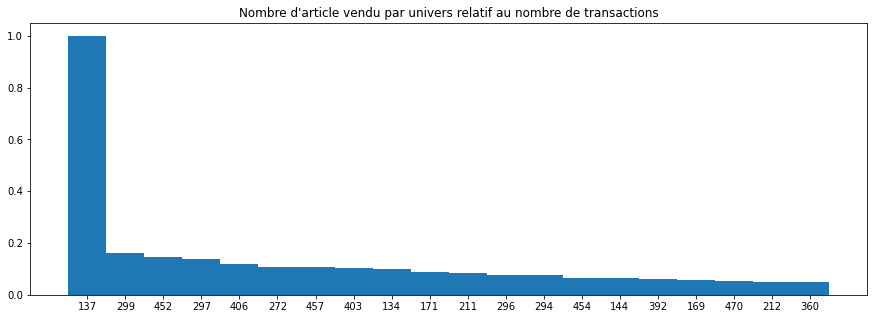

==============138===================
NOT ENOUGH DATA 
==============139===================
1452
Time Taken to load recurence: ~0secondes


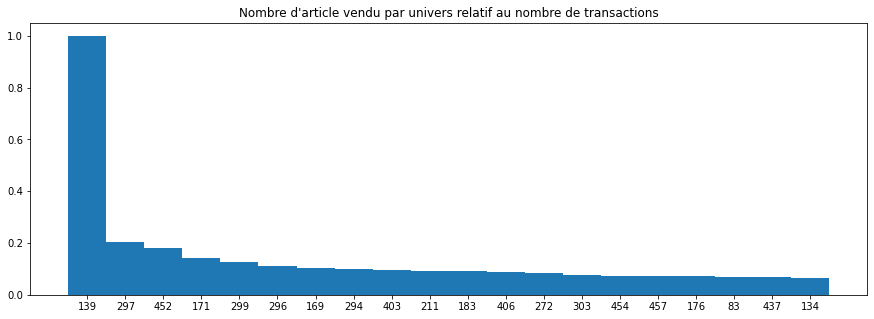

==============140===================
325
Time Taken to load recurence: ~0secondes


==============141===================
1233
Time Taken to load recurence: ~0secondes


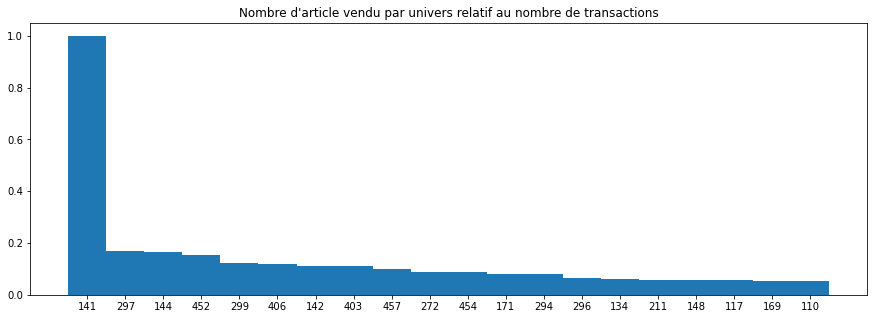

==============142===================
3574
Time Taken to load recurence: ~0secondes


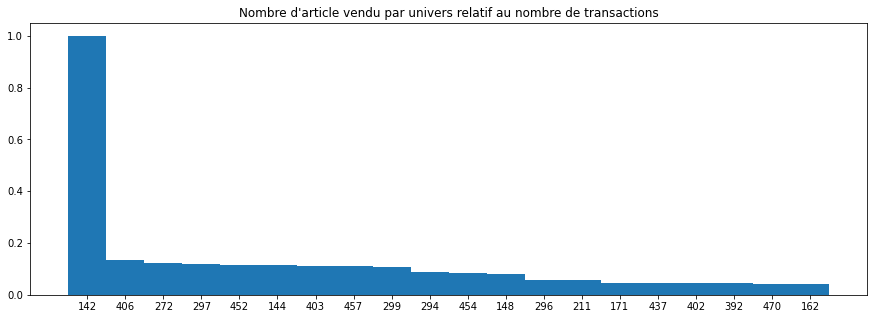

==============143===================
198
Time Taken to load recurence: ~0secondes


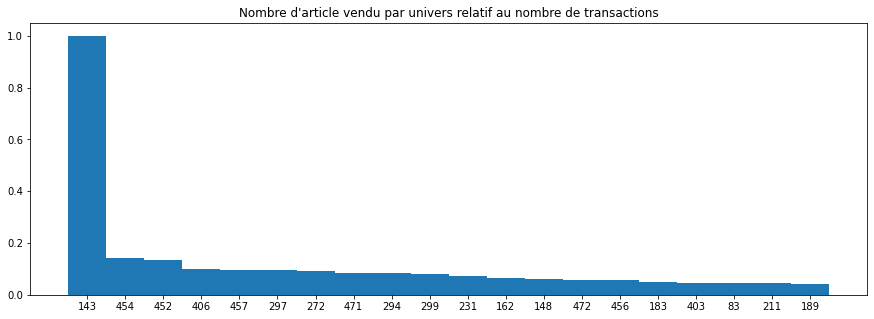

==============144===================
5527
Time Taken to load recurence: ~0secondes


==============145===================
278
Time Taken to load recurence: ~0secondes


==============146===================
NOT ENOUGH DATA 
==============147===================
7478
Time Taken to load recurence: ~0secondes


==============148===================
14809
Time Taken to load recurence: ~0secondes


==============149===================
1767
Time Taken to load recurence: ~0secondes


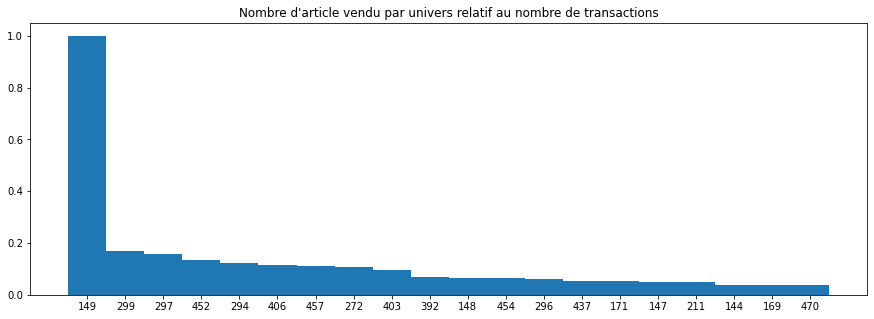

==============150===================
698
Time Taken to load recurence: ~0secondes


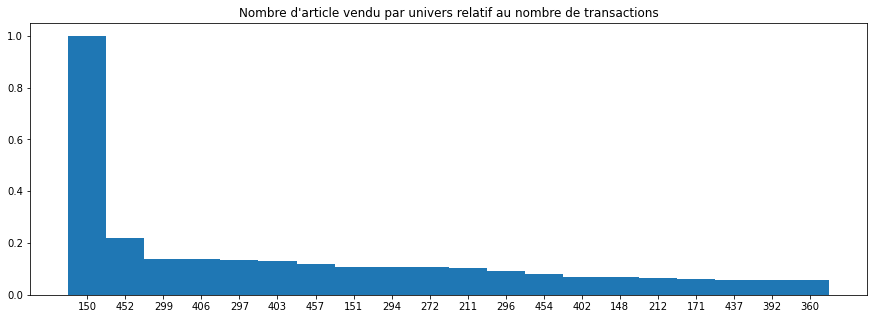

==============151===================
5099
Time Taken to load recurence: ~0secondes


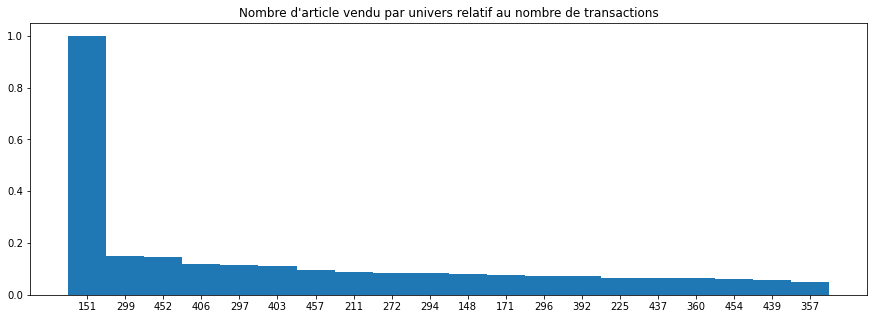

==============152===================
106
Time Taken to load recurence: ~0secondes


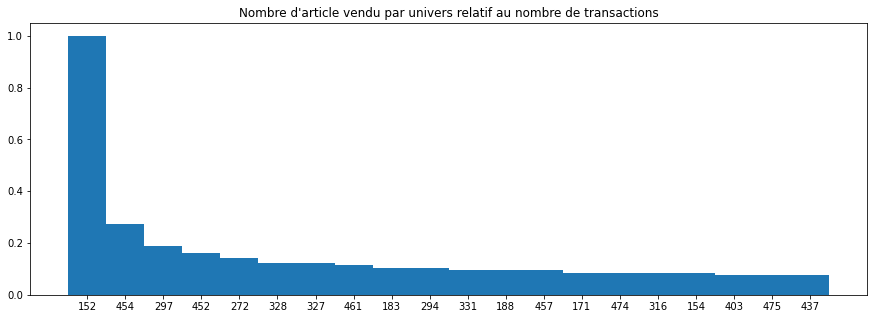

==============153===================
305
Time Taken to load recurence: ~0secondes


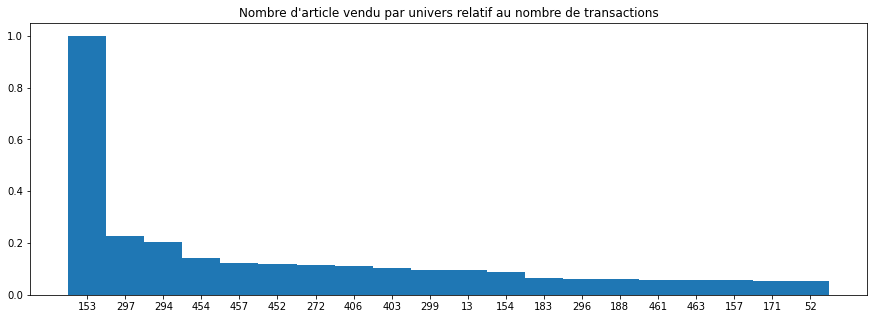

==============154===================
4373
Time Taken to load recurence: ~0secondes


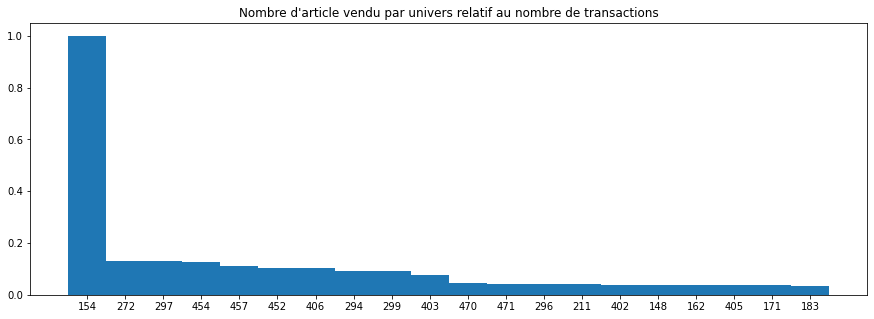

==============155===================
274
Time Taken to load recurence: ~0secondes


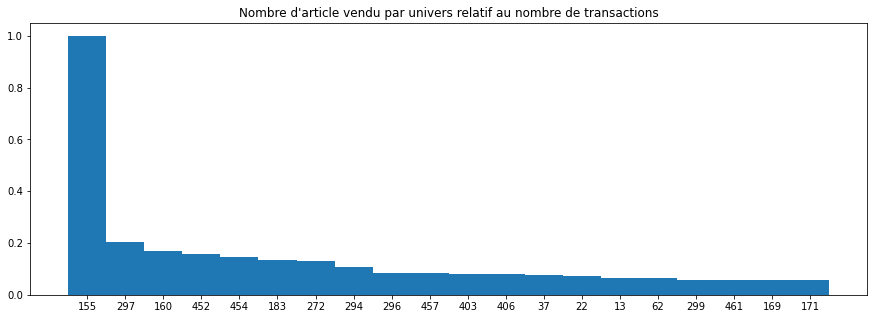

==============156===================
438
Time Taken to load recurence: ~0secondes


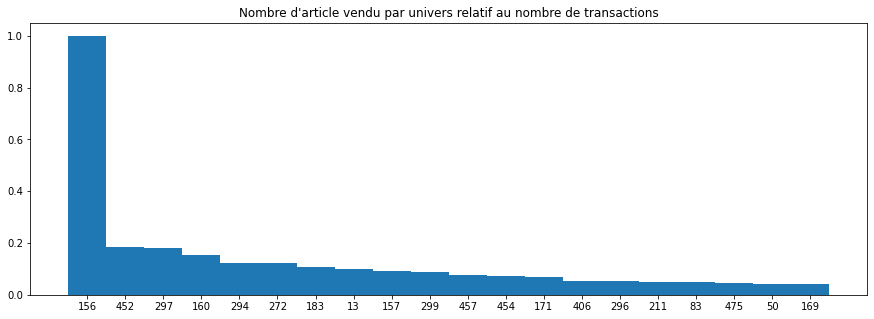

==============157===================
2538
Time Taken to load recurence: ~0secondes


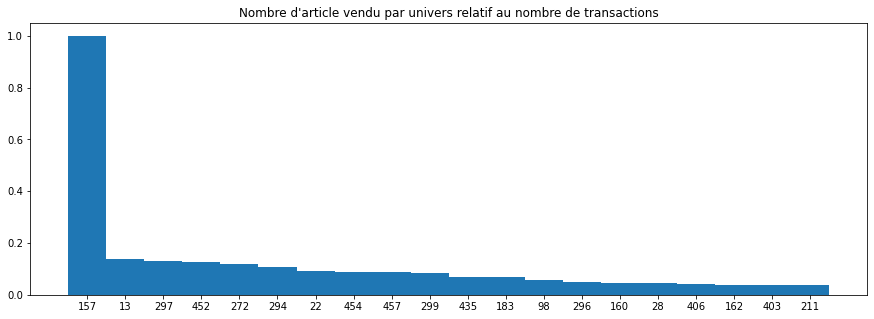

==============158===================
NOT ENOUGH DATA 
==============159===================
204
Time Taken to load recurence: ~0secondes


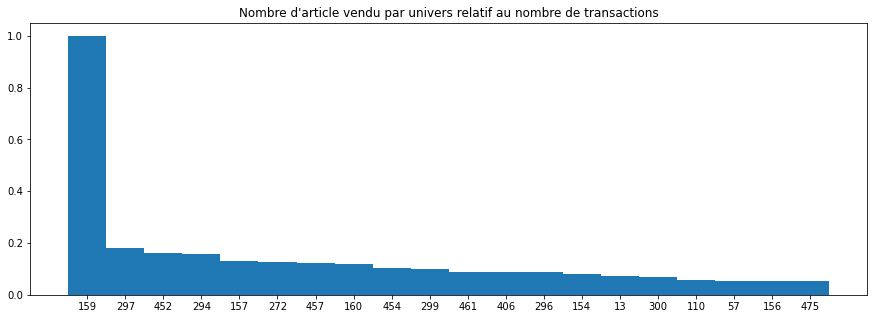

==============160===================
1443
Time Taken to load recurence: ~0secondes


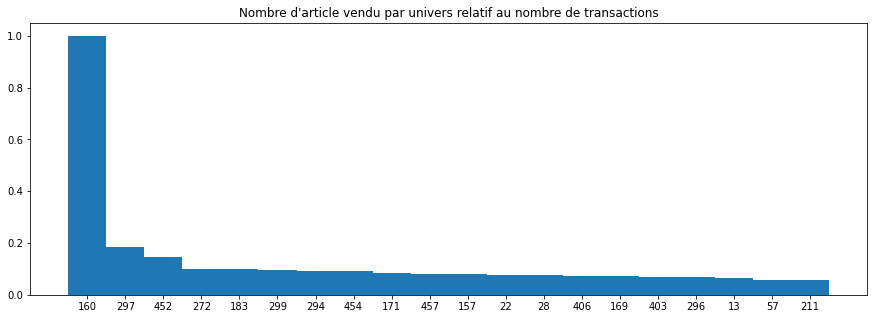

==============161===================
NOT ENOUGH DATA 
==============162===================
5577
Time Taken to load recurence: ~0secondes


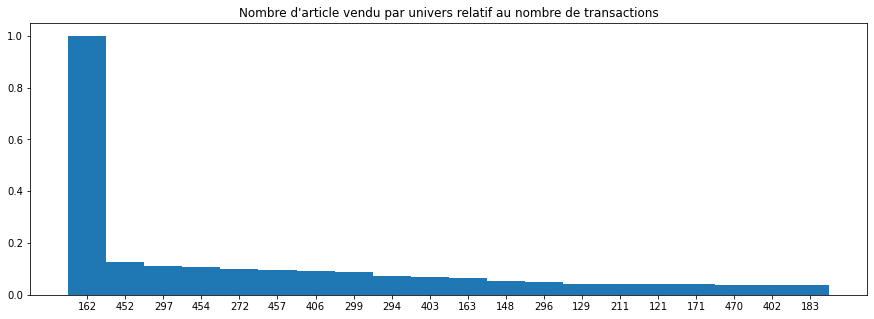

==============163===================
2176
Time Taken to load recurence: ~0secondes


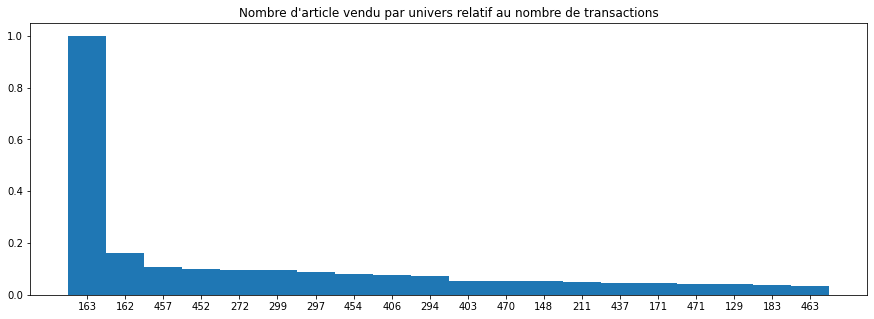

==============164===================
NOT ENOUGH DATA 
==============165===================
NOT ENOUGH DATA 
==============166===================
NOT ENOUGH DATA 
==============167===================
NOT ENOUGH DATA 
==============168===================
NOT ENOUGH DATA 
==============169===================
6742
Time Taken to load recurence: ~0secondes


==============170===================
NOT ENOUGH DATA 
==============171===================
10278
Time Taken to load recurence: ~0secondes


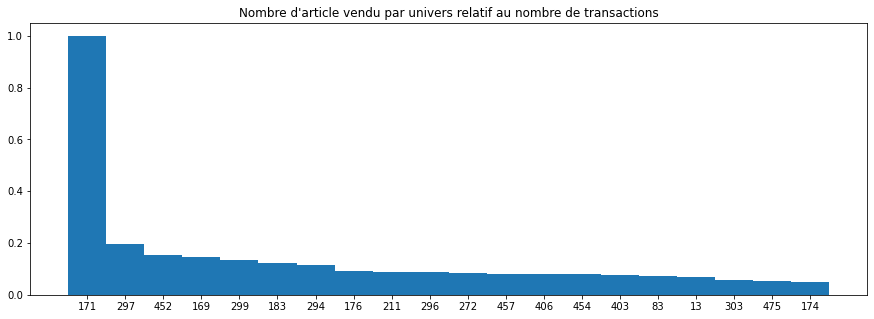

==============172===================
144
Time Taken to load recurence: ~0secondes


==============173===================
949
Time Taken to load recurence: ~0secondes


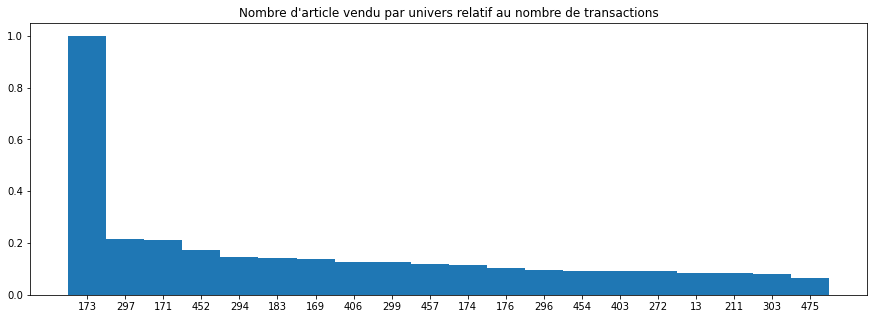

==============174===================
2307
Time Taken to load recurence: ~0secondes


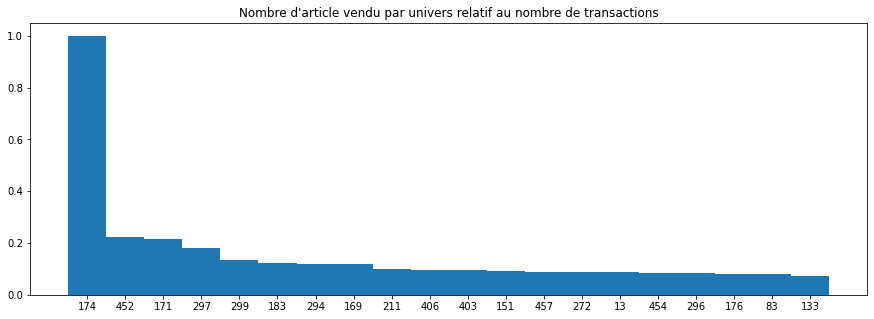

==============175===================
105
Time Taken to load recurence: ~0secondes


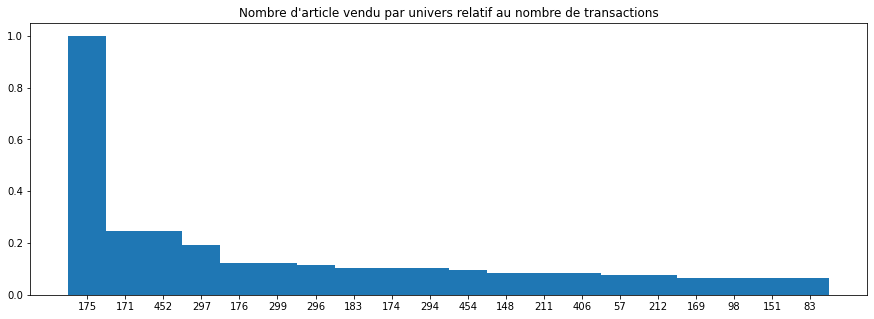

==============176===================
4429
Time Taken to load recurence: ~0secondes


==============177===================
2033
Time Taken to load recurence: ~0secondes


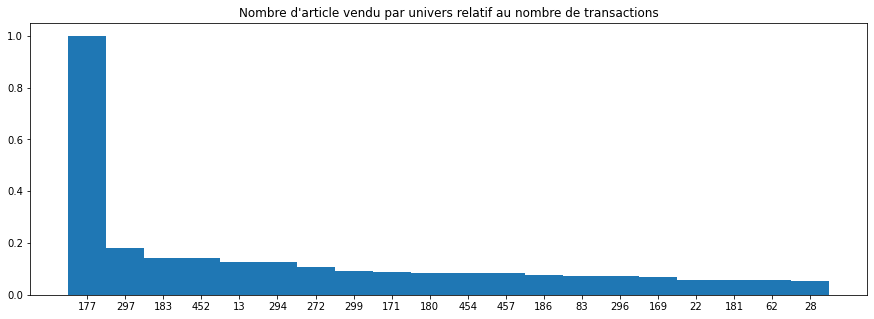

==============178===================
513
Time Taken to load recurence: ~0secondes


==============179===================
NOT ENOUGH DATA 
==============180===================
2849
Time Taken to load recurence: ~0secondes


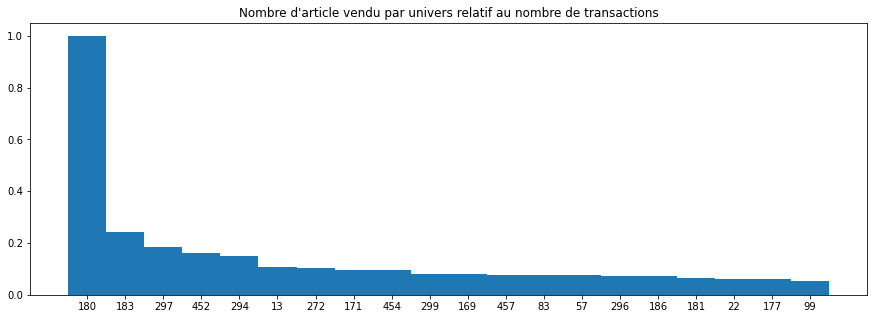

==============181===================
2107
Time Taken to load recurence: ~0secondes


==============182===================
839
Time Taken to load recurence: ~0secondes


==============183===================
9094
Time Taken to load recurence: ~0secondes


==============184===================
643
Time Taken to load recurence: ~0secondes


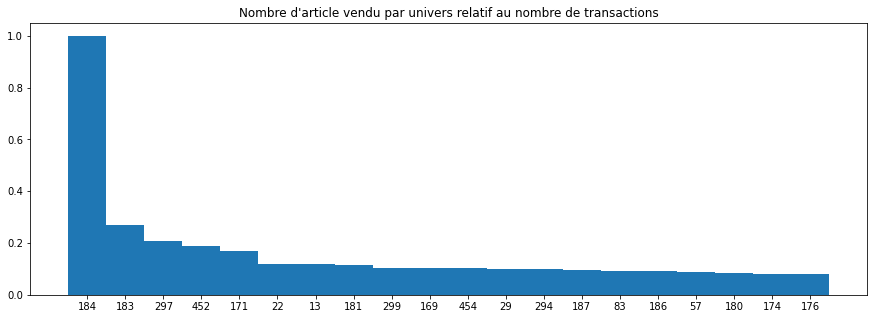

==============185===================
NOT ENOUGH DATA 
==============186===================
2075
Time Taken to load recurence: ~0secondes


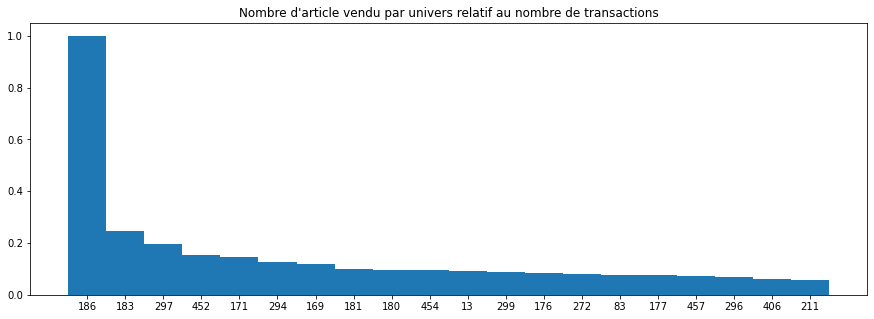

==============187===================
1792
Time Taken to load recurence: ~0secondes


==============188===================
14102
Time Taken to load recurence: ~0secondes


==============189===================
6852
Time Taken to load recurence: ~0secondes


==============190===================
746
Time Taken to load recurence: ~0secondes


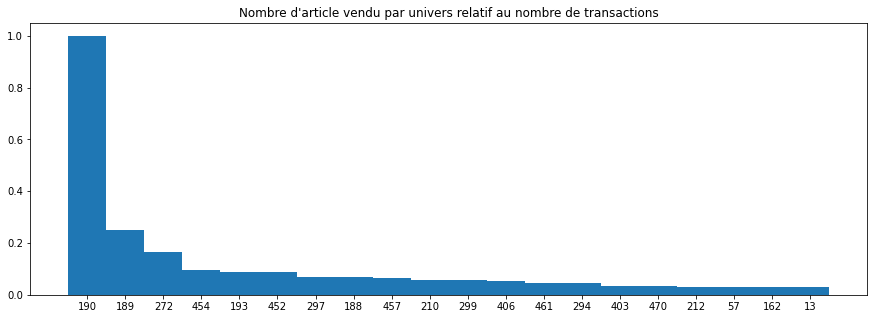

==============191===================
176
Time Taken to load recurence: ~0secondes


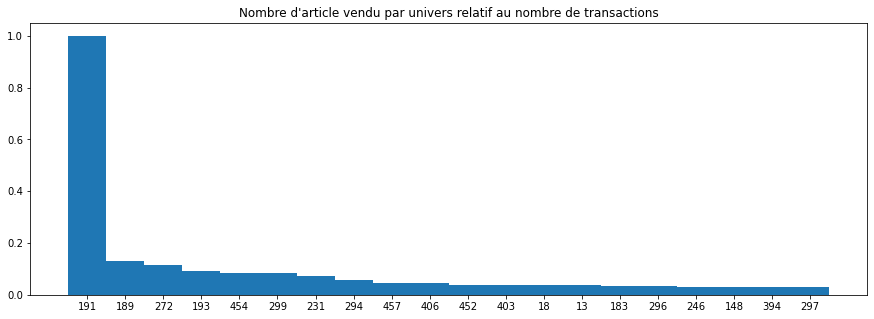

==============192===================
468
Time Taken to load recurence: ~0secondes


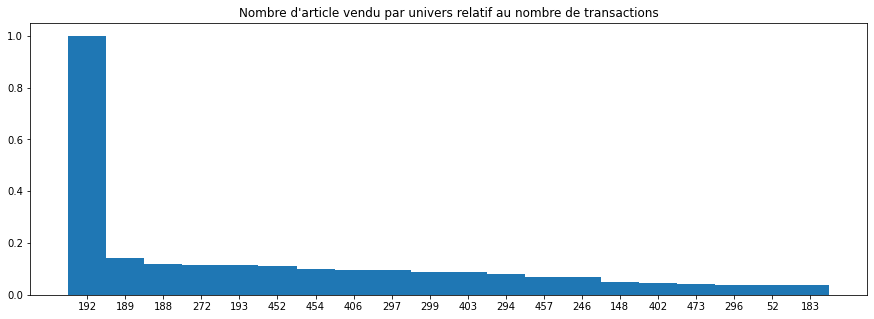

==============193===================
5490
Time Taken to load recurence: ~0secondes


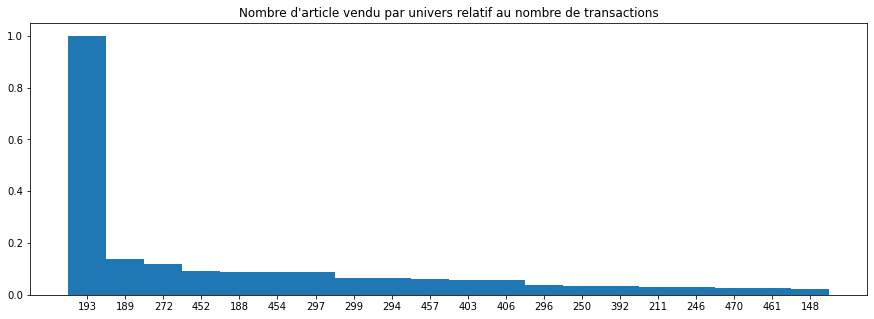

==============194===================
239
Time Taken to load recurence: ~0secondes


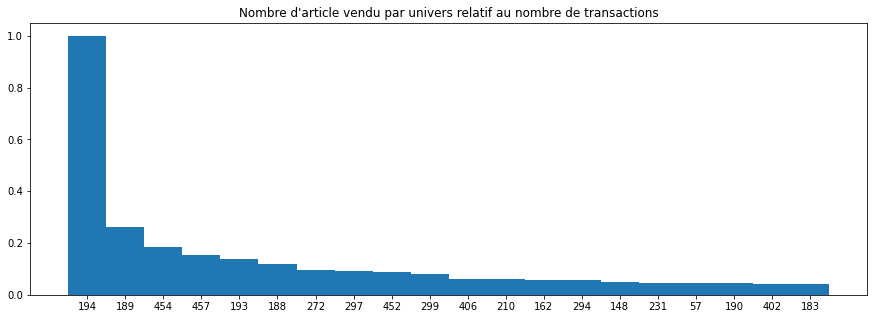

==============195===================
59
Time Taken to load recurence: ~0secondes


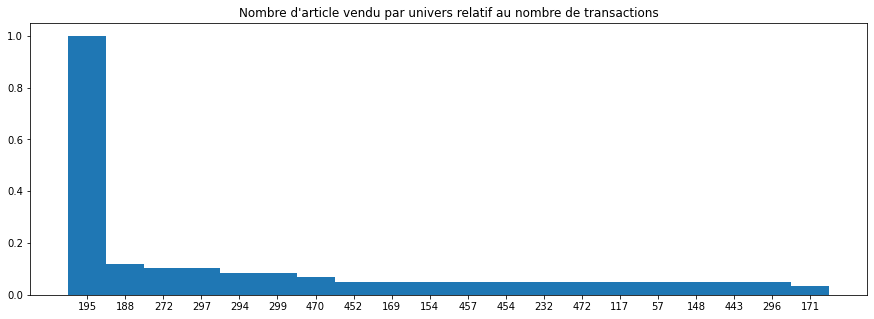

==============196===================
305
Time Taken to load recurence: ~0secondes


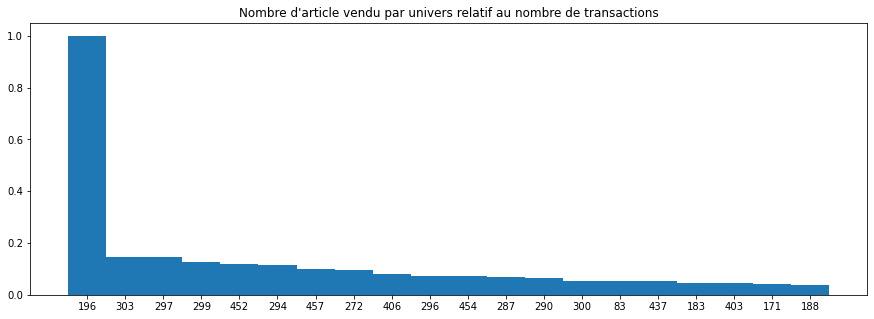

==============197===================
82
Time Taken to load recurence: ~0secondes


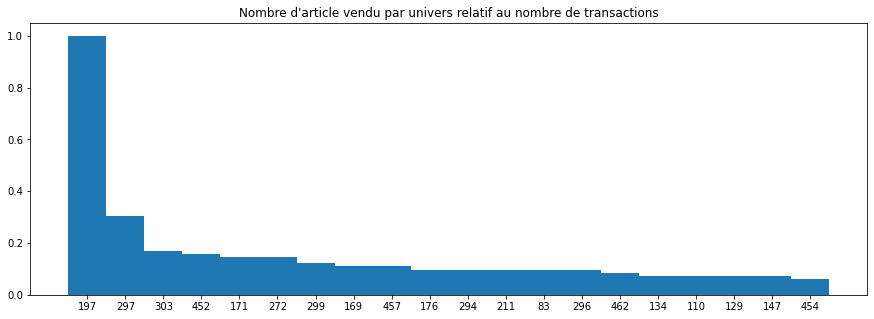

==============198===================
5874
Time Taken to load recurence: ~0secondes


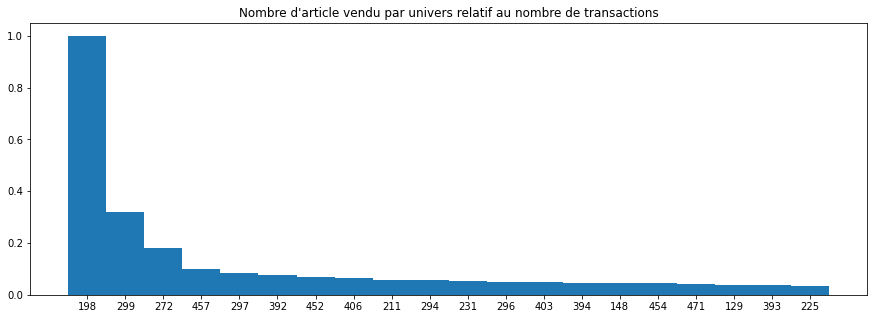

==============199===================
276
Time Taken to load recurence: ~0secondes


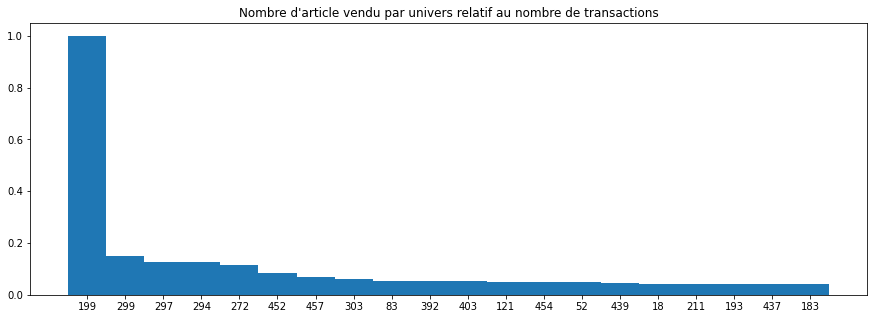

==============200===================
1071
Time Taken to load recurence: ~0secondes


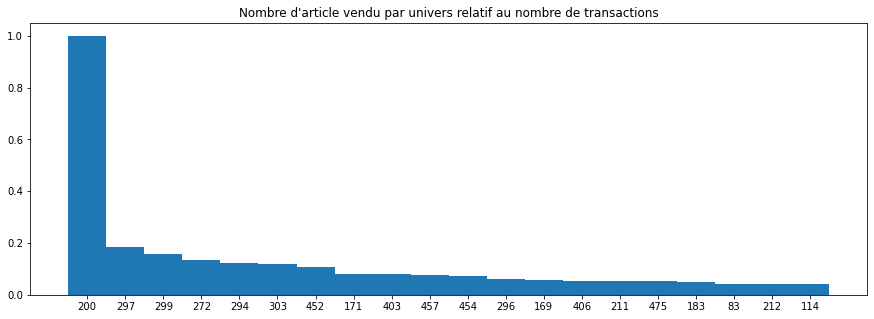

==============201===================
1292
Time Taken to load recurence: ~0secondes


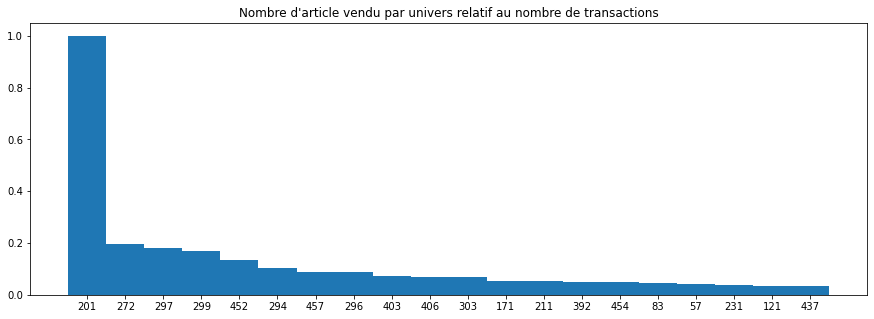

==============202===================
NOT ENOUGH DATA 
==============203===================
311
Time Taken to load recurence: ~0secondes


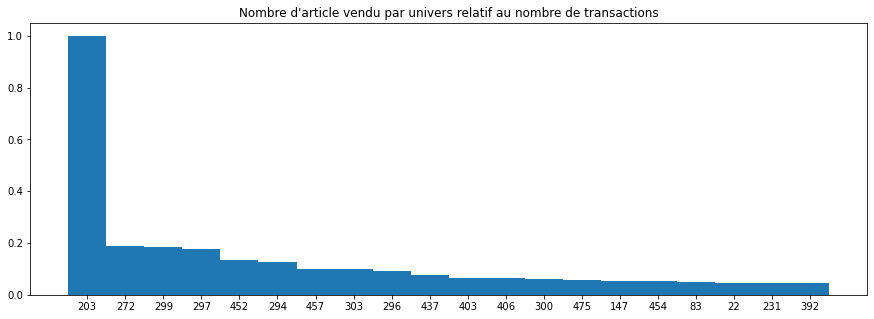

==============204===================
70
Time Taken to load recurence: ~0secondes


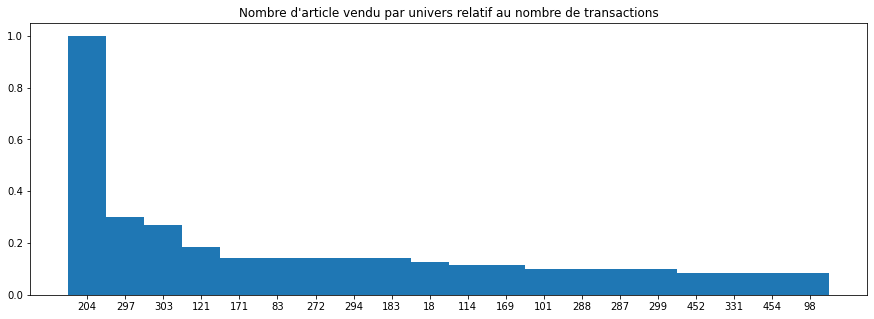

==============205===================
NOT ENOUGH DATA 
==============206===================
141
Time Taken to load recurence: ~0secondes


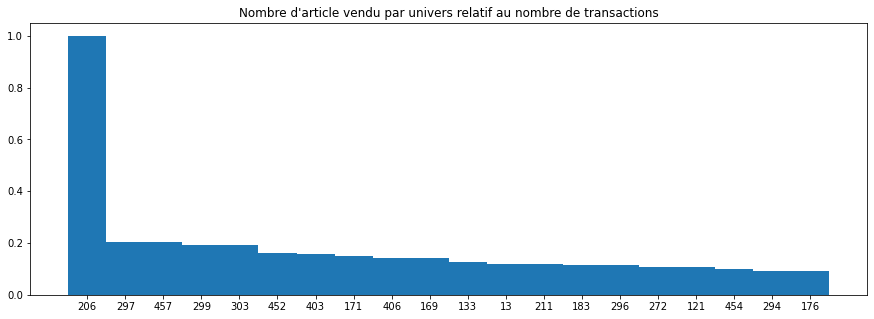

==============207===================
925
Time Taken to load recurence: ~0secondes


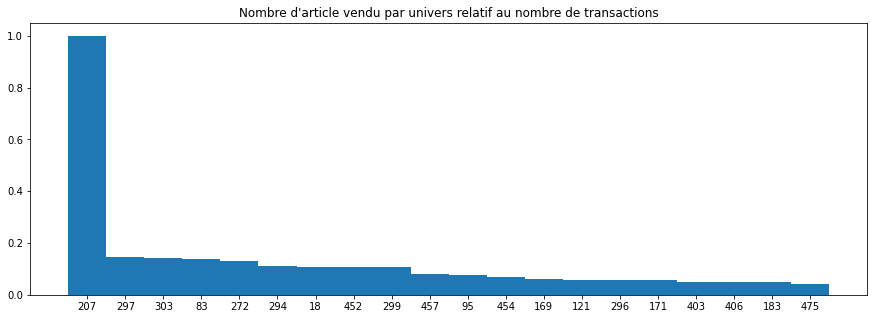

==============208===================
1742
Time Taken to load recurence: ~0secondes


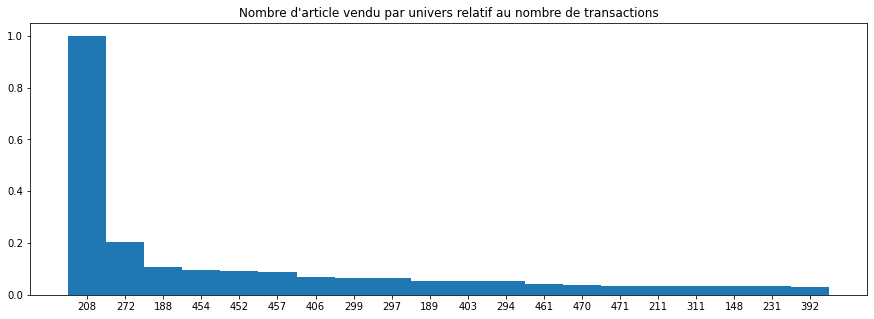

==============209===================
513
Time Taken to load recurence: ~0secondes


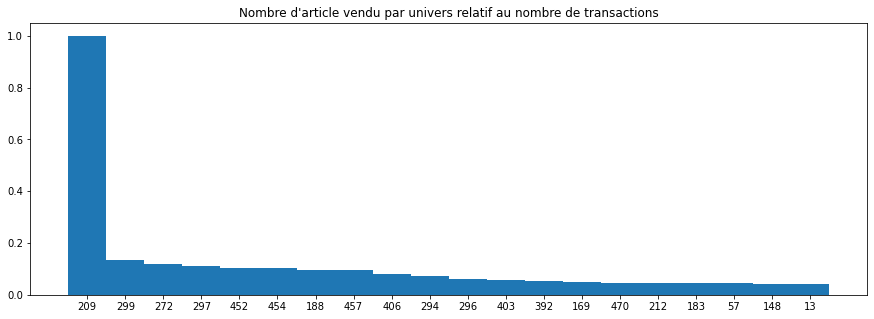

==============210===================
2427
Time Taken to load recurence: ~0secondes


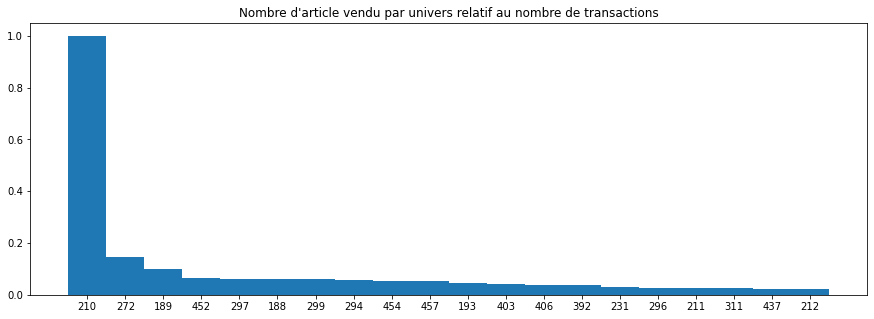

==============211===================
18474
Time Taken to load recurence: ~0secondes


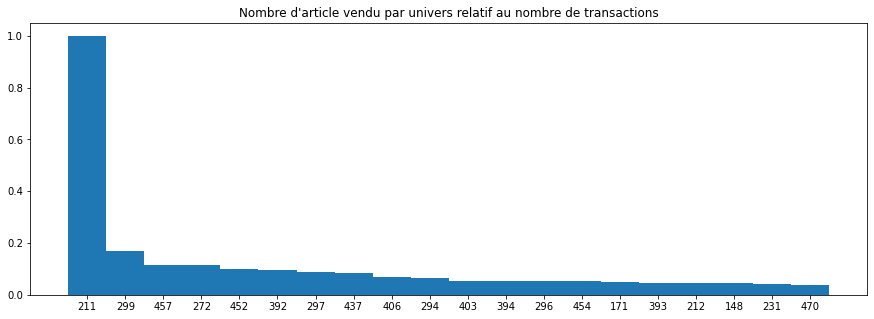

==============212===================
7189
Time Taken to load recurence: ~0secondes


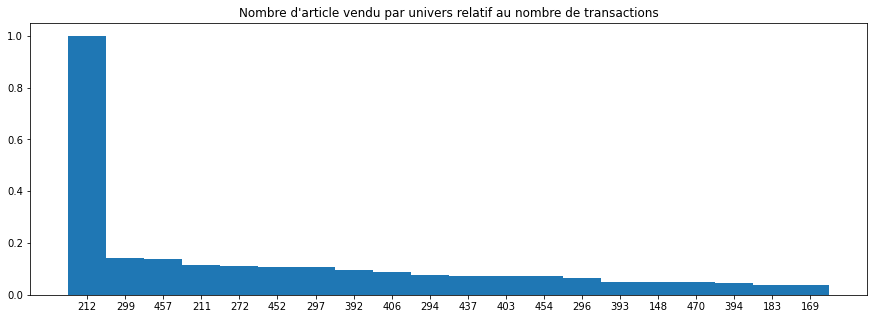

==============213===================
NOT ENOUGH DATA 
==============214===================
NOT ENOUGH DATA 
==============215===================
1738
Time Taken to load recurence: ~0secondes


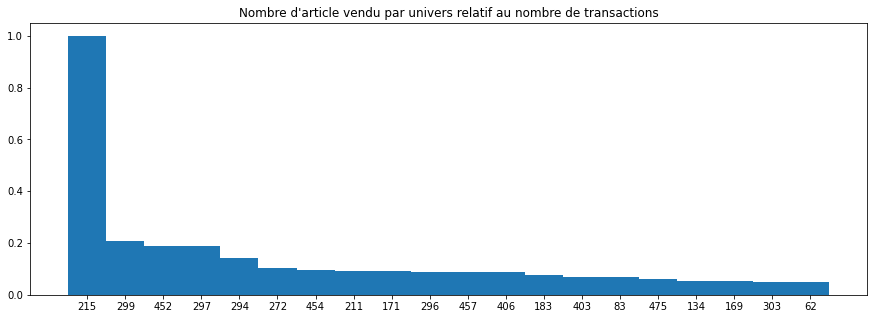

==============216===================
2212
Time Taken to load recurence: ~0secondes


==============217===================
NOT ENOUGH DATA 
==============218===================
NOT ENOUGH DATA 
==============219===================
2881
Time Taken to load recurence: ~0secondes


==============220===================
4067
Time Taken to load recurence: ~0secondes


==============221===================
NOT ENOUGH DATA 
==============222===================
490
Time Taken to load recurence: ~0secondes


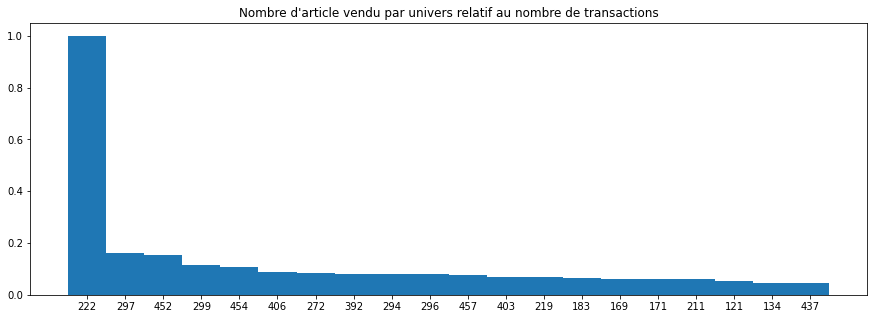

==============223===================
289
Time Taken to load recurence: ~0secondes


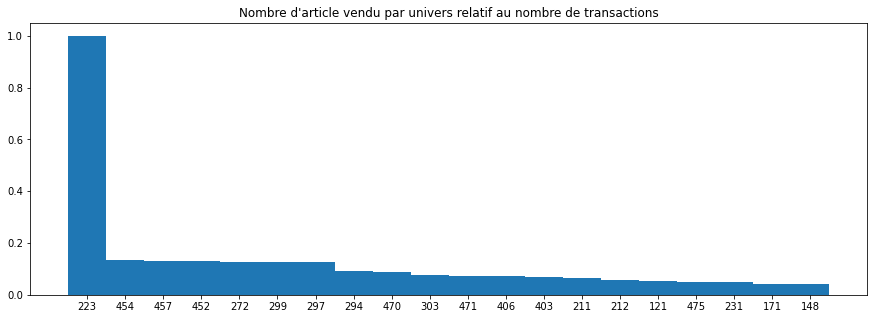

==============224===================
342
Time Taken to load recurence: ~0secondes


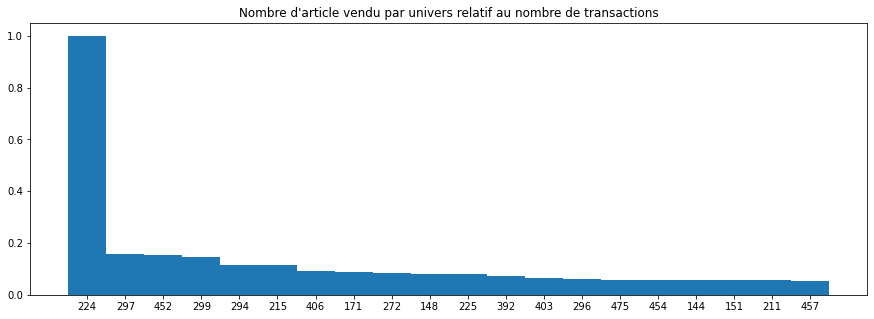

==============225===================
6930
Time Taken to load recurence: ~0secondes


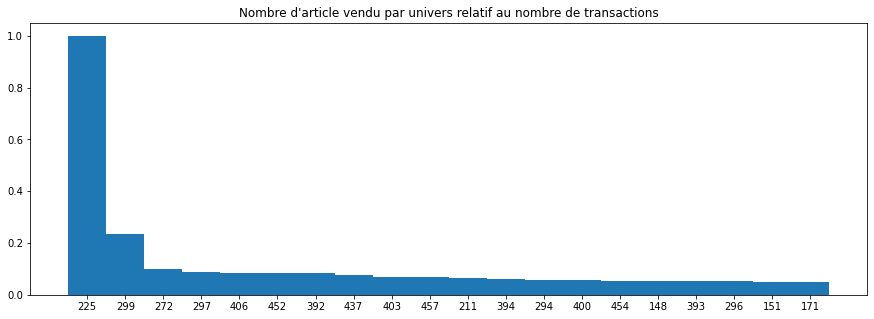

==============226===================
NOT ENOUGH DATA 
==============227===================
NOT ENOUGH DATA 
==============228===================
NOT ENOUGH DATA 
==============229===================
NOT ENOUGH DATA 
==============230===================
NOT ENOUGH DATA 
==============231===================
15093
Time Taken to load recurence: ~0secondes


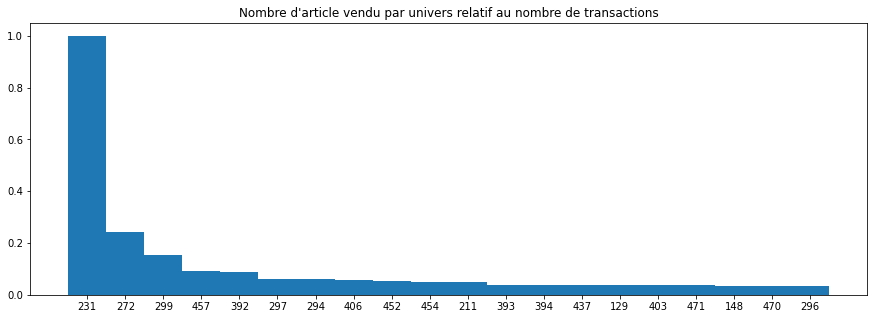

==============232===================
3153
Time Taken to load recurence: ~0secondes


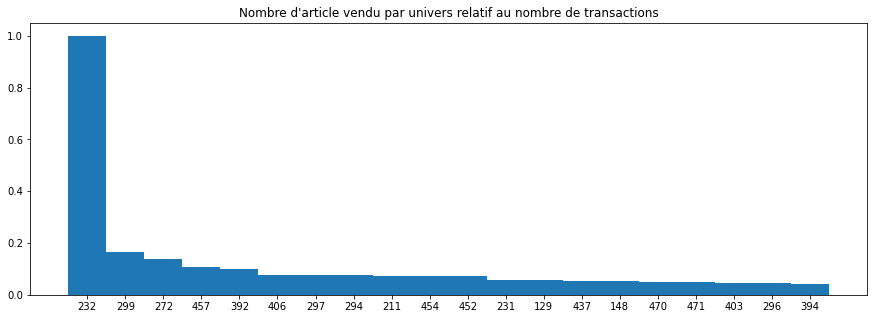

==============233===================
1522
Time Taken to load recurence: ~0secondes


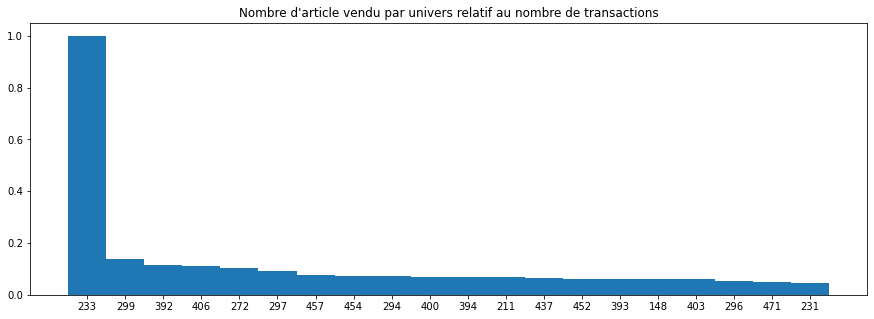

==============234===================
NOT ENOUGH DATA 
==============235===================
737
Time Taken to load recurence: ~0secondes


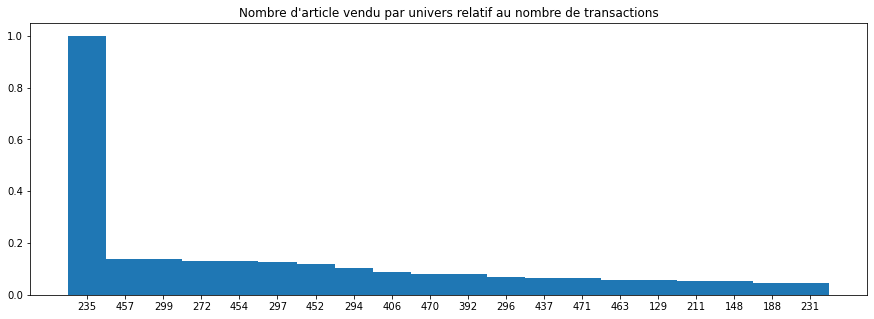

==============236===================
1500
Time Taken to load recurence: ~0secondes


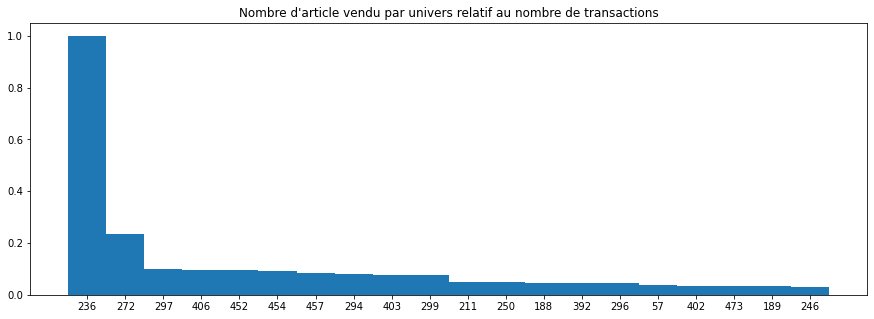

==============237===================
NOT ENOUGH DATA 
==============238===================
325
Time Taken to load recurence: ~0secondes


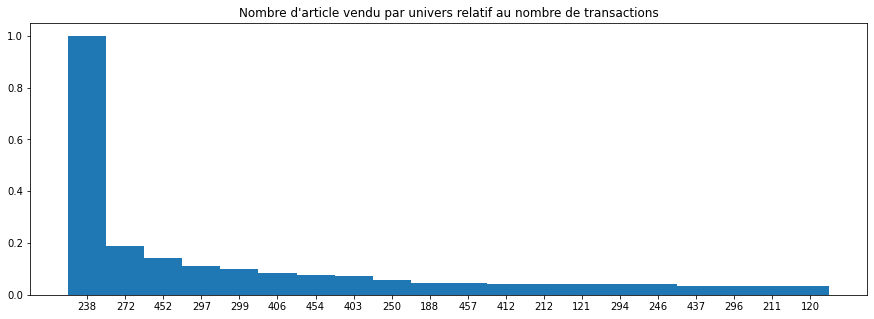

==============239===================
960
Time Taken to load recurence: ~0secondes


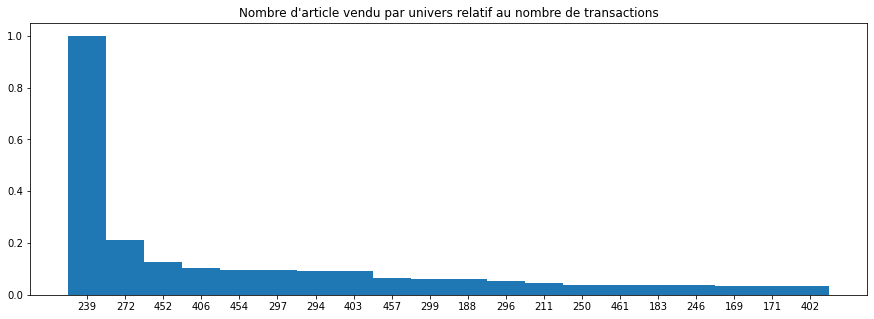

==============240===================
129
Time Taken to load recurence: ~0secondes


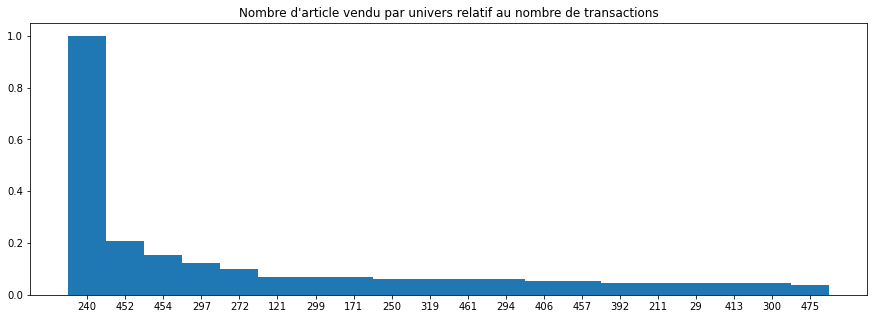

==============241===================
231
Time Taken to load recurence: ~0secondes


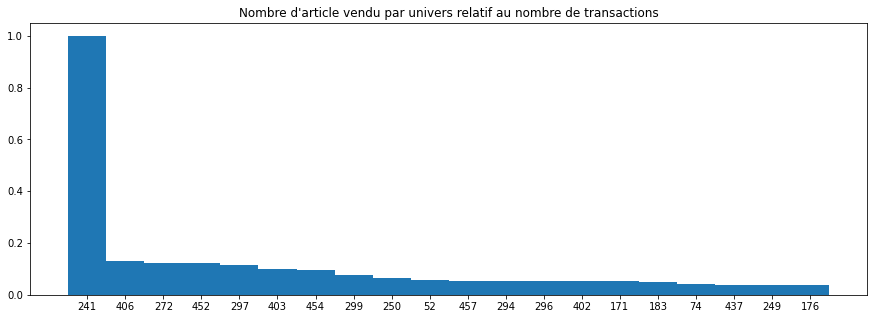

==============242===================
270
Time Taken to load recurence: ~0secondes


==============243===================
150
Time Taken to load recurence: ~0secondes


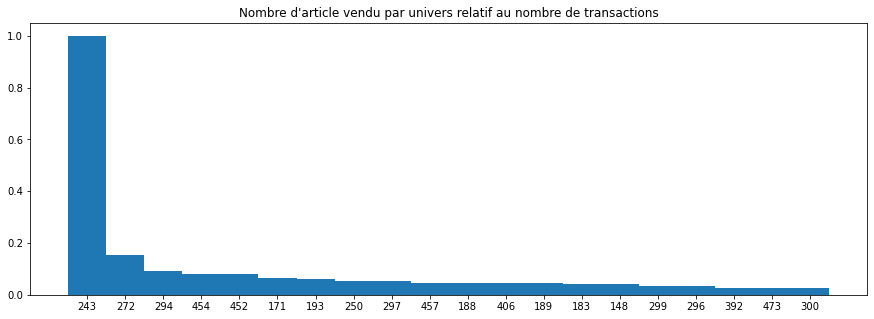

==============244===================
175
Time Taken to load recurence: ~0secondes


==============245===================
365
Time Taken to load recurence: ~0secondes


==============246===================
4951
Time Taken to load recurence: ~0secondes


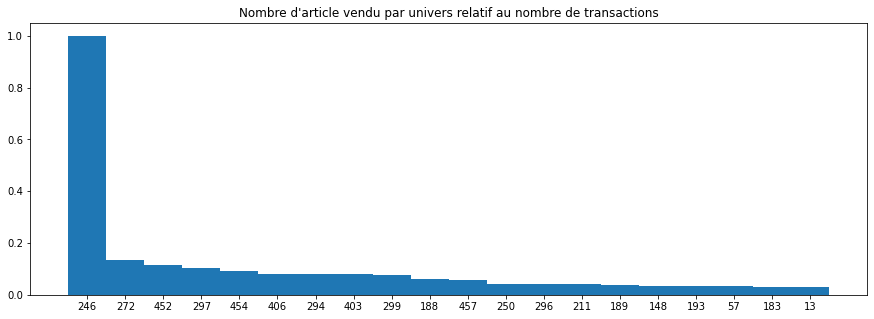

==============247===================
811
Time Taken to load recurence: ~0secondes


==============248===================
237
Time Taken to load recurence: ~0secondes


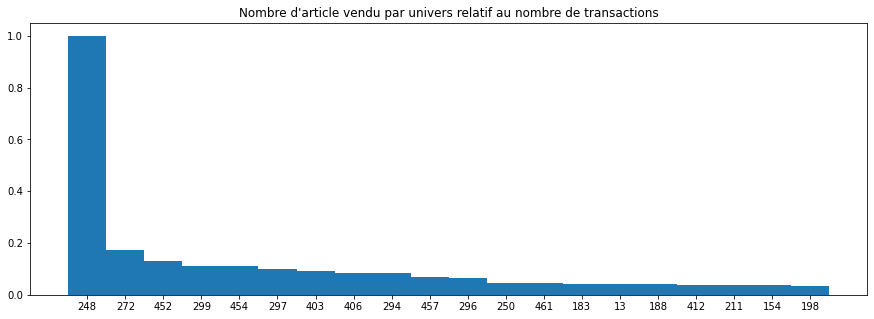

==============249===================
1914
Time Taken to load recurence: ~0secondes


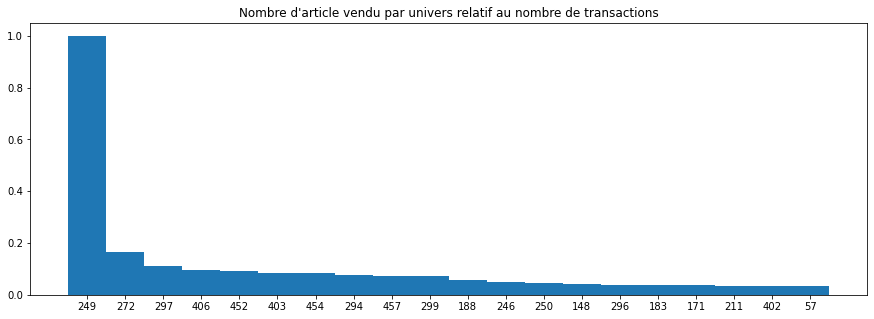

==============250===================
6629
Time Taken to load recurence: ~0secondes


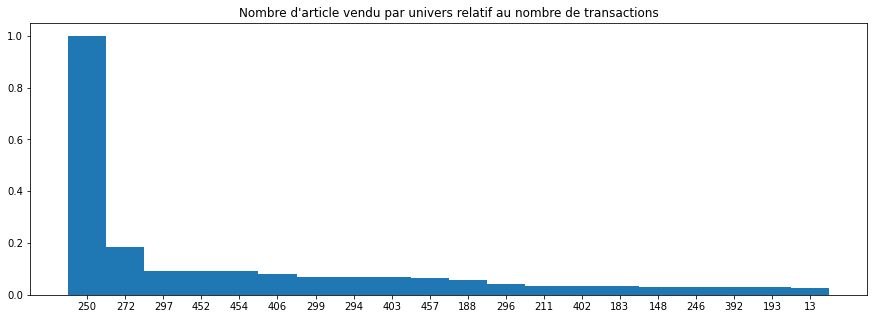

==============251===================
1062
Time Taken to load recurence: ~0secondes


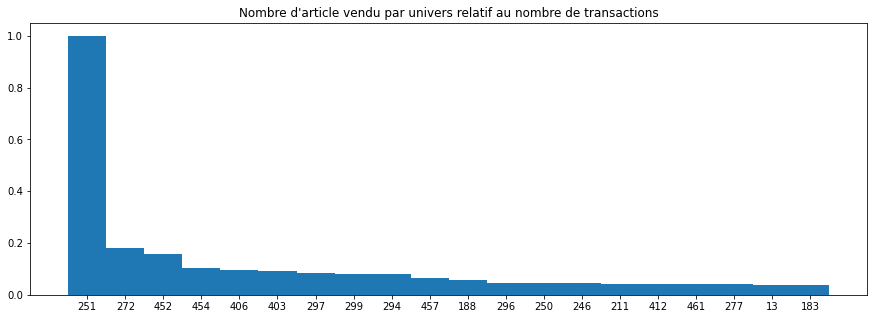

==============252===================
294
Time Taken to load recurence: ~0secondes


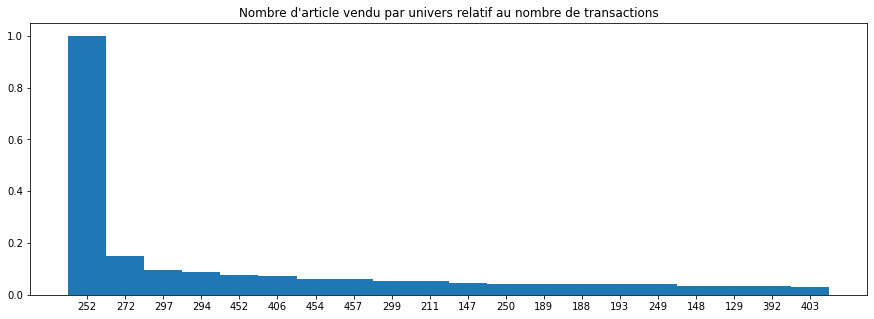

==============253===================
116
Time Taken to load recurence: ~0secondes


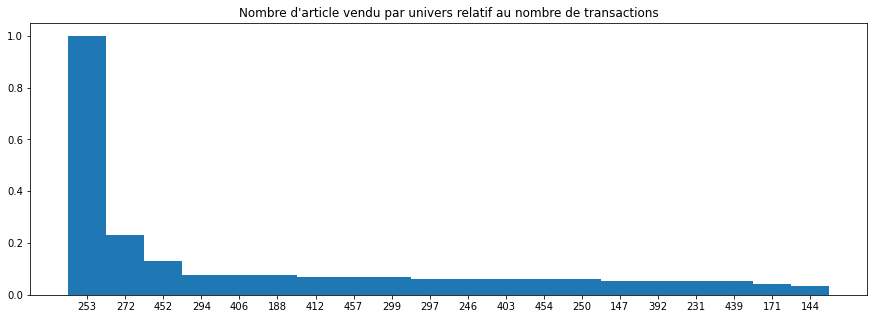

==============254===================
930
Time Taken to load recurence: ~0secondes


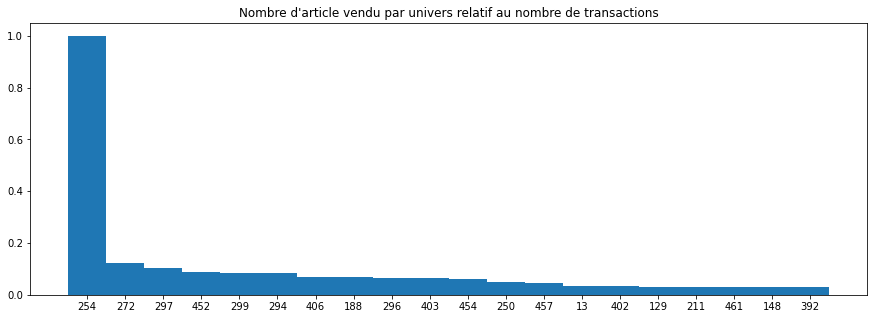

==============255===================
947
Time Taken to load recurence: ~0secondes


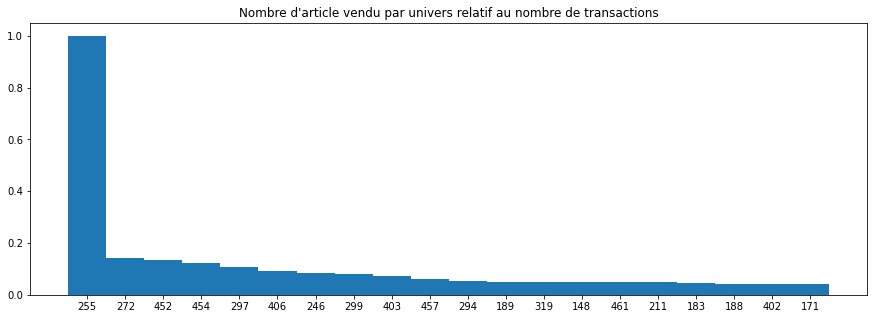

==============256===================
185
Time Taken to load recurence: ~0secondes


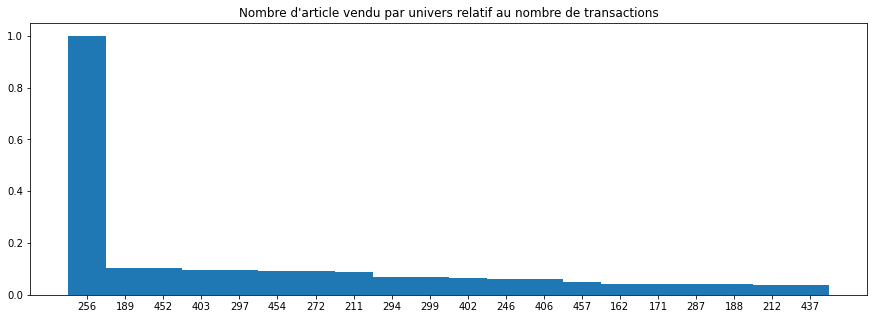

==============257===================
NOT ENOUGH DATA 
==============258===================
839
Time Taken to load recurence: ~0secondes


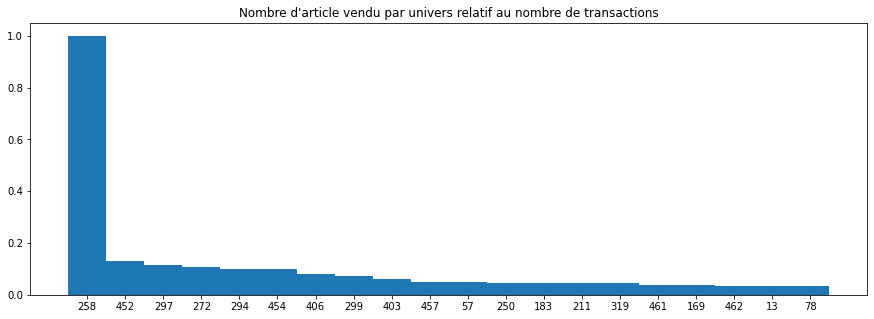

==============259===================
290
Time Taken to load recurence: ~0secondes


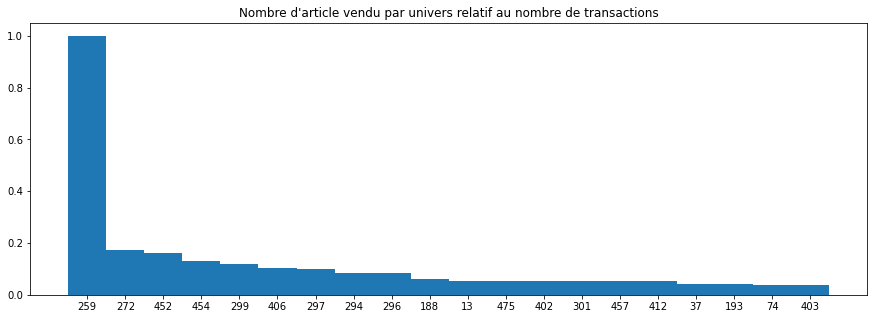

==============260===================
NOT ENOUGH DATA 
==============261===================
NOT ENOUGH DATA 
==============262===================
625
Time Taken to load recurence: ~0secondes


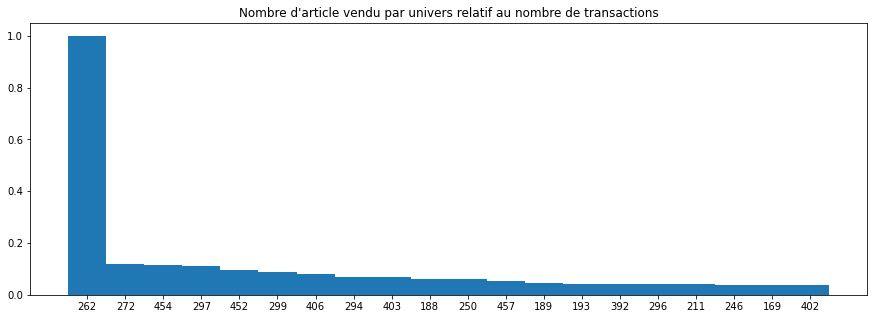

==============263===================
367
Time Taken to load recurence: ~0secondes


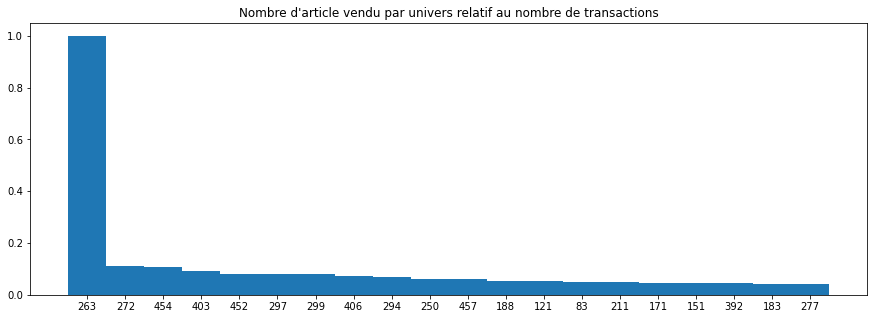

==============264===================
NOT ENOUGH DATA 
==============265===================
NOT ENOUGH DATA 
==============266===================
253
Time Taken to load recurence: ~0secondes


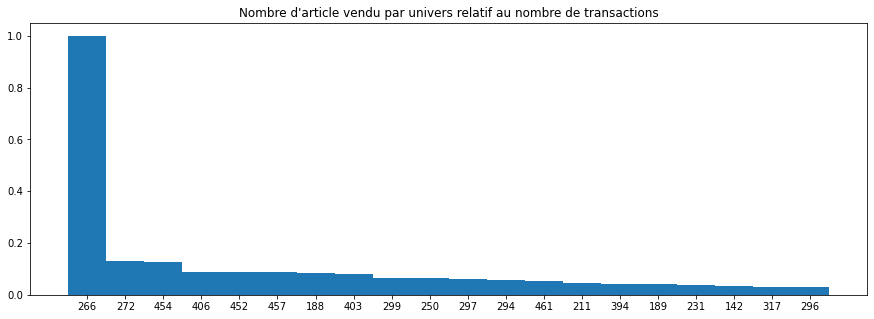

==============267===================
209
Time Taken to load recurence: ~0secondes


==============268===================
NOT ENOUGH DATA 
==============269===================
1594
Time Taken to load recurence: ~0secondes


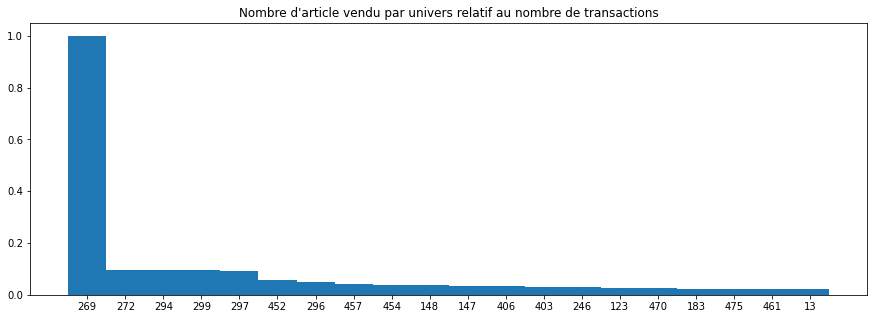

==============270===================
2659
Time Taken to load recurence: ~0secondes


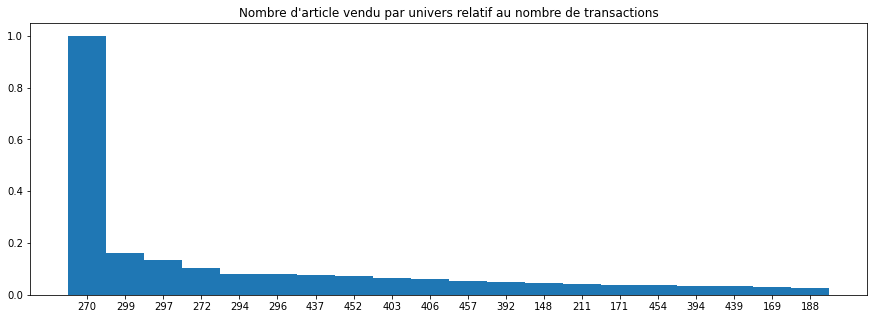

==============271===================
4220
Time Taken to load recurence: ~0secondes


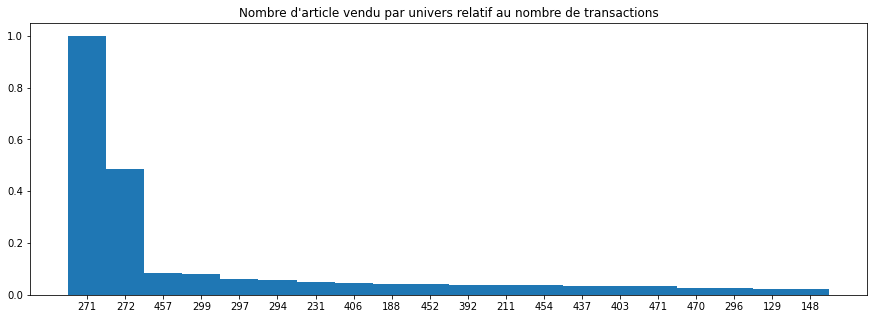

==============272===================
62959
Time Taken to load recurence: ~0secondes


==============273===================
481
Time Taken to load recurence: ~0secondes


==============274===================
NOT ENOUGH DATA 
==============275===================
1522
Time Taken to load recurence: ~0secondes


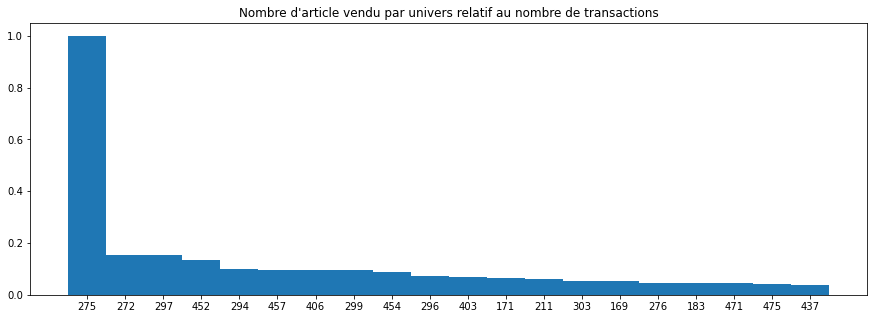

==============276===================
812
Time Taken to load recurence: ~0secondes


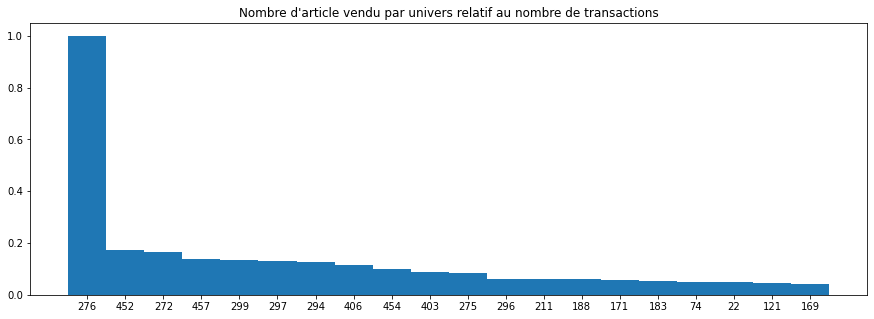

==============277===================
2307
Time Taken to load recurence: ~0secondes


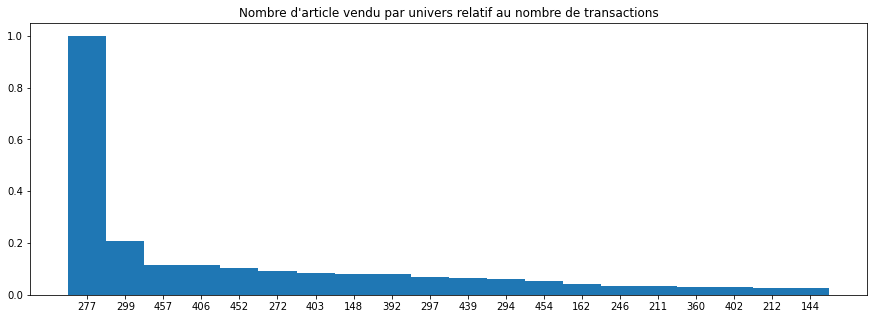

==============278===================
NOT ENOUGH DATA 
==============279===================
NOT ENOUGH DATA 
==============280===================
NOT ENOUGH DATA 
==============281===================
NOT ENOUGH DATA 
==============282===================
NOT ENOUGH DATA 
==============283===================
NOT ENOUGH DATA 
==============284===================
NOT ENOUGH DATA 
==============285===================
NOT ENOUGH DATA 
==============286===================
934
Time Taken to load recurence: ~0secondes


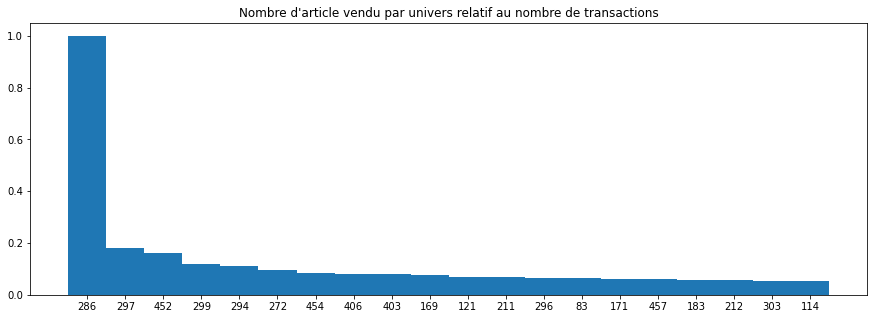

==============287===================
2795
Time Taken to load recurence: ~0secondes


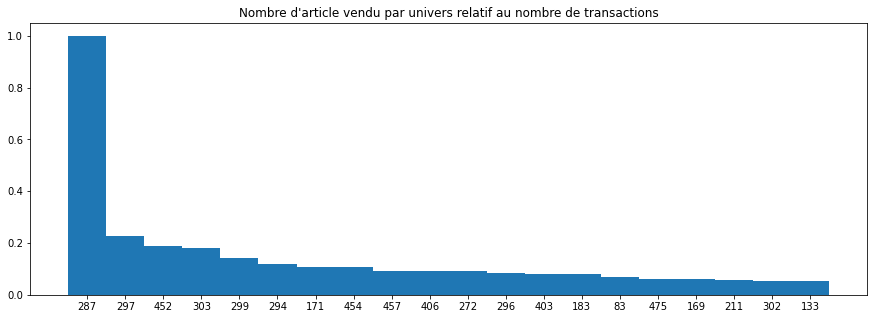

==============288===================
1631
Time Taken to load recurence: ~0secondes


==============289===================
405
Time Taken to load recurence: ~0secondes


==============290===================
1837
Time Taken to load recurence: ~0secondes


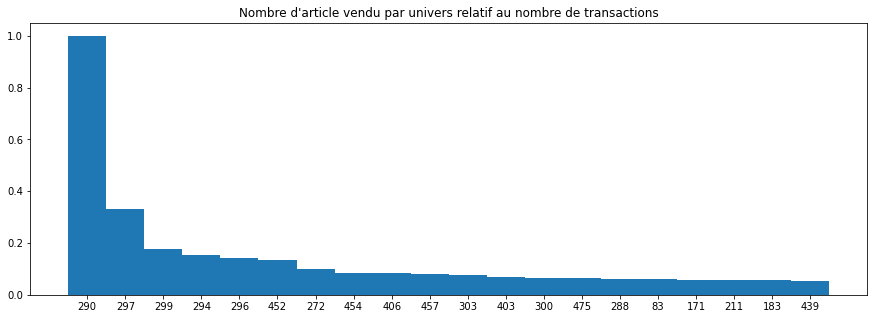

==============291===================
290
Time Taken to load recurence: ~0secondes


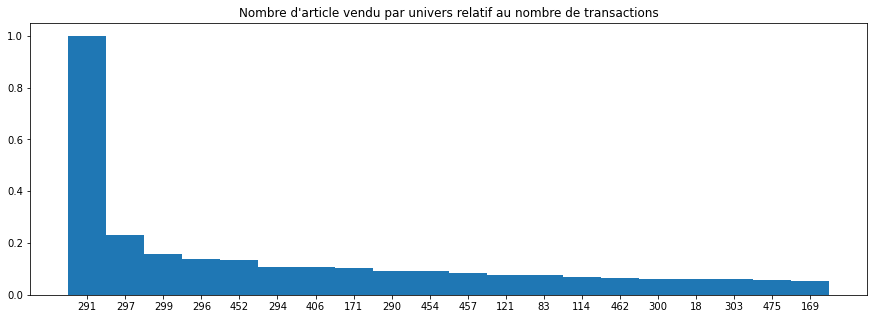

==============292===================
1303
Time Taken to load recurence: ~0secondes


==============293===================
509
Time Taken to load recurence: ~0secondes


==============294===================
37886
Time Taken to load recurence: ~0secondes


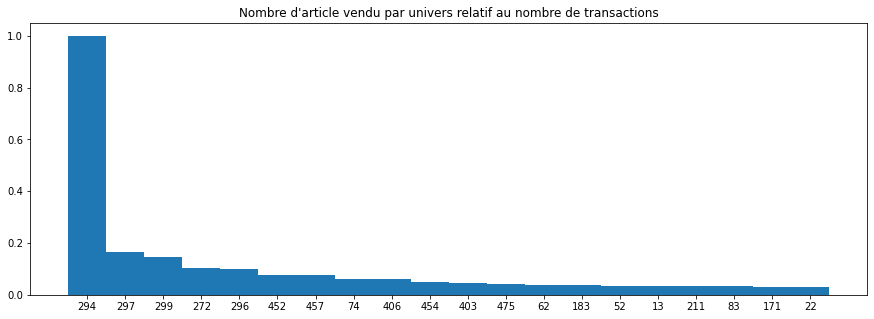

==============295===================
NOT ENOUGH DATA 
==============296===================
23601
Time Taken to load recurence: ~0secondes


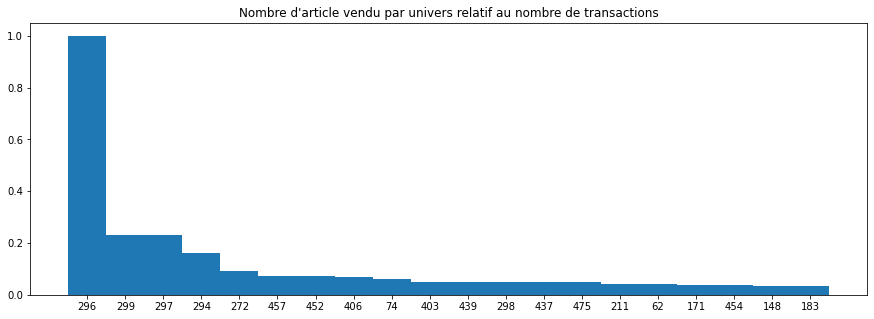

==============297===================
48187
Time Taken to load recurence: ~0secondes


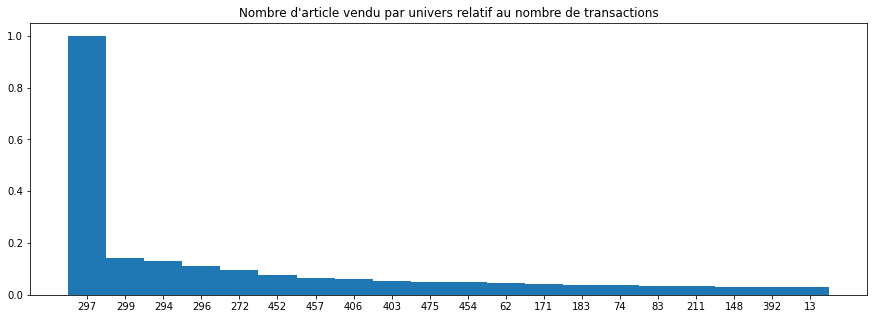

==============298===================
4916
Time Taken to load recurence: ~0secondes


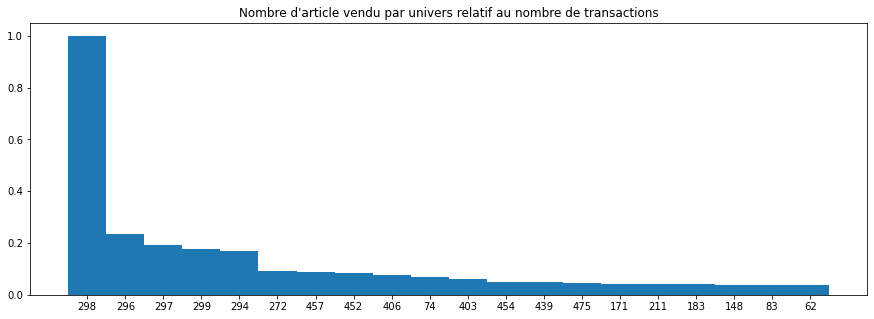

==============299===================
61299
Time Taken to load recurence: ~0secondes


==============300===================
5618
Time Taken to load recurence: ~0secondes


==============301===================
3099
Time Taken to load recurence: ~0secondes


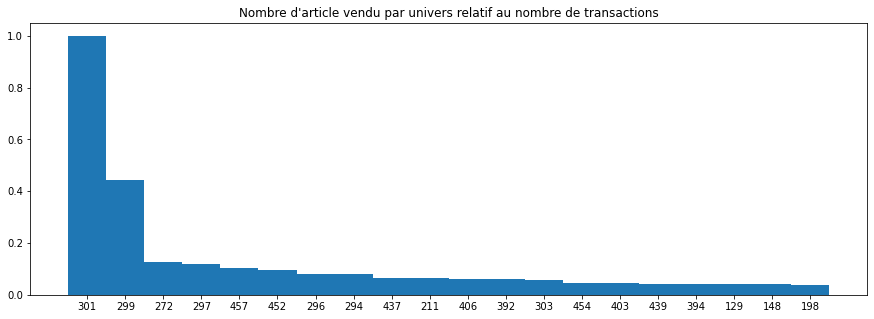

==============302===================
1984
Time Taken to load recurence: ~0secondes


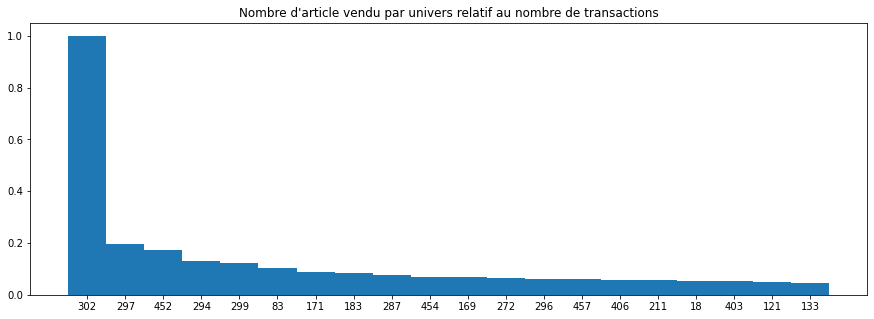

==============303===================
6808
Time Taken to load recurence: ~0secondes


==============304===================
100
Time Taken to load recurence: ~0secondes


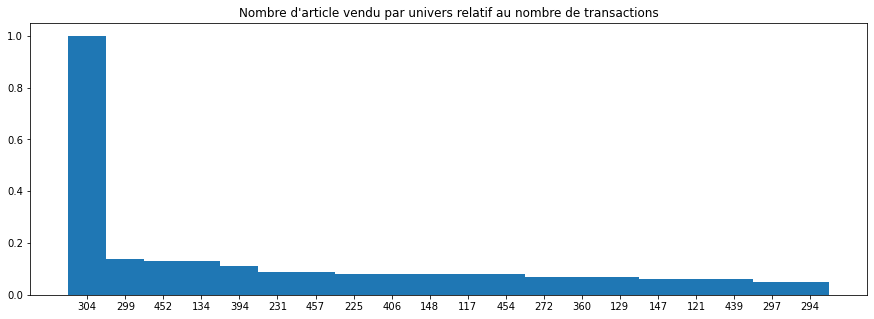

==============305===================
1350
Time Taken to load recurence: ~0secondes


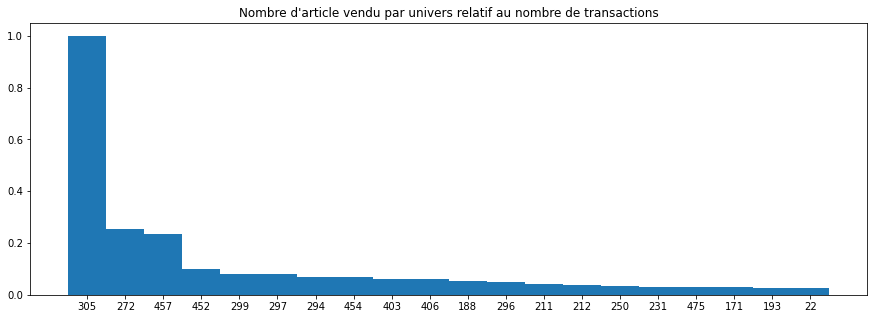

==============306===================
1024
Time Taken to load recurence: ~0secondes


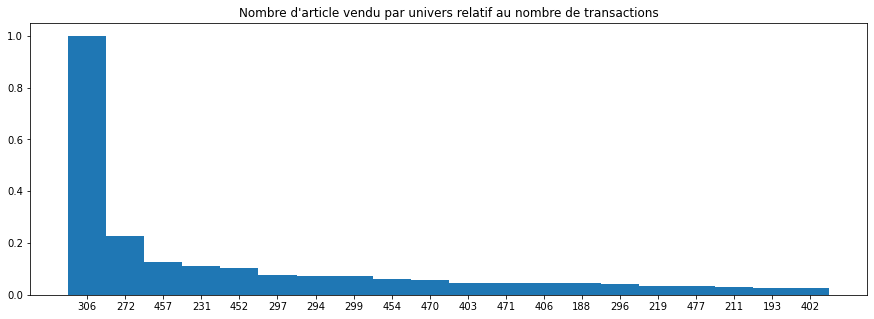

==============307===================
599
Time Taken to load recurence: ~0secondes


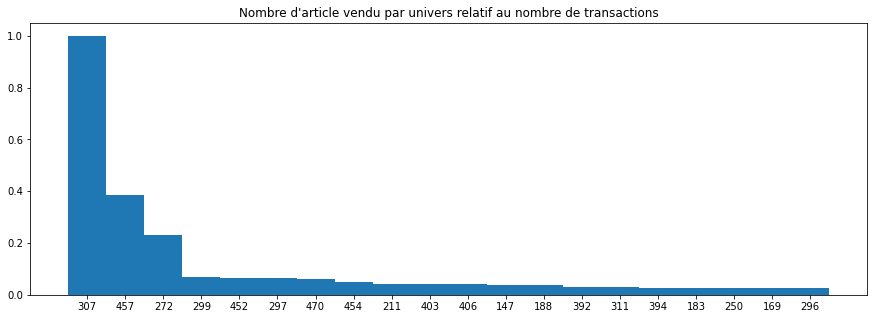

==============308===================
294
Time Taken to load recurence: ~0secondes


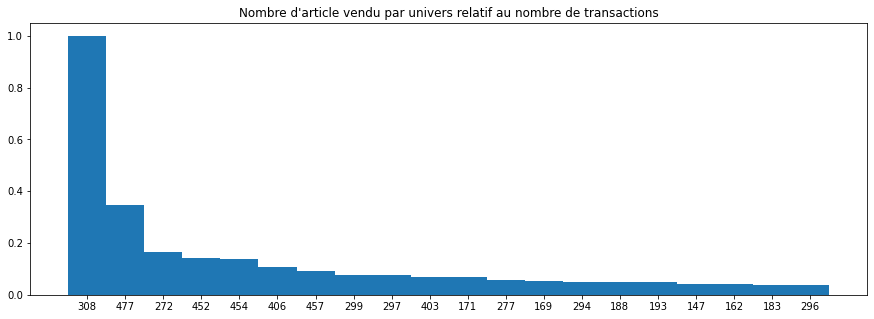

==============309===================
NOT ENOUGH DATA 
==============310===================
98
Time Taken to load recurence: ~0secondes


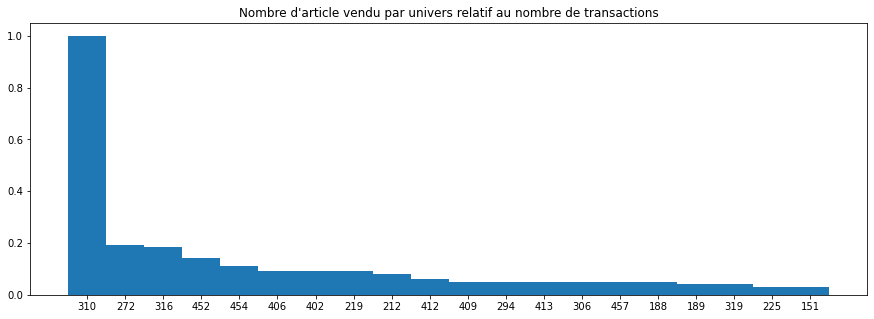

==============311===================
2331
Time Taken to load recurence: ~0secondes


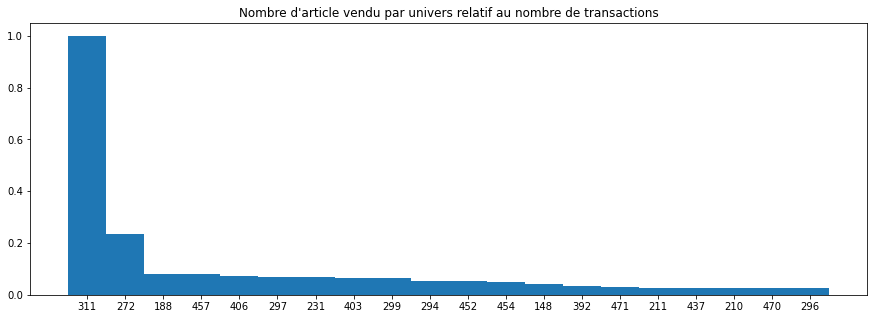

==============312===================
855
Time Taken to load recurence: ~0secondes


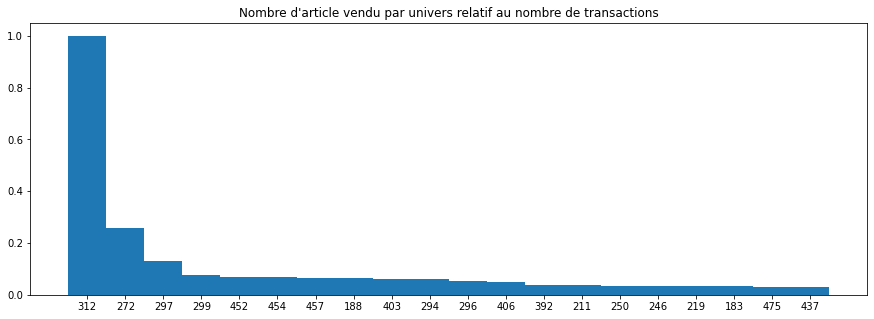

==============313===================
835
Time Taken to load recurence: ~0secondes


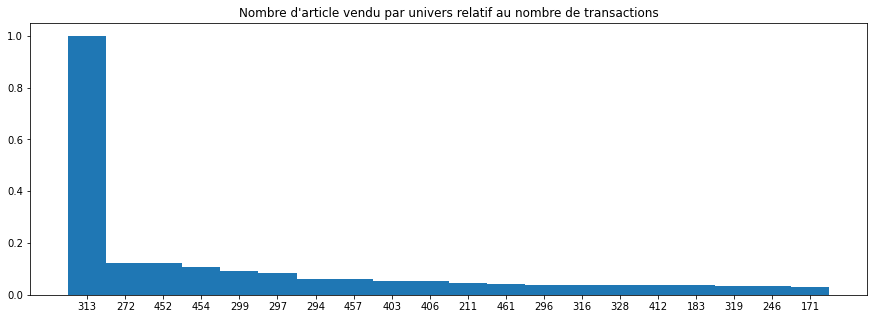

==============314===================
NOT ENOUGH DATA 
==============315===================
91
Time Taken to load recurence: ~0secondes


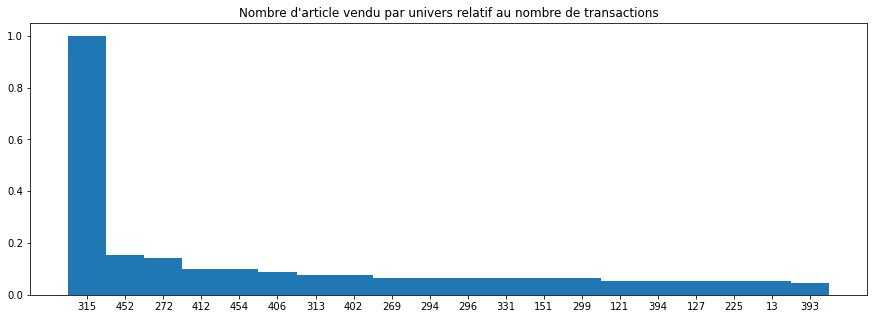

==============316===================
1994
Time Taken to load recurence: ~0secondes


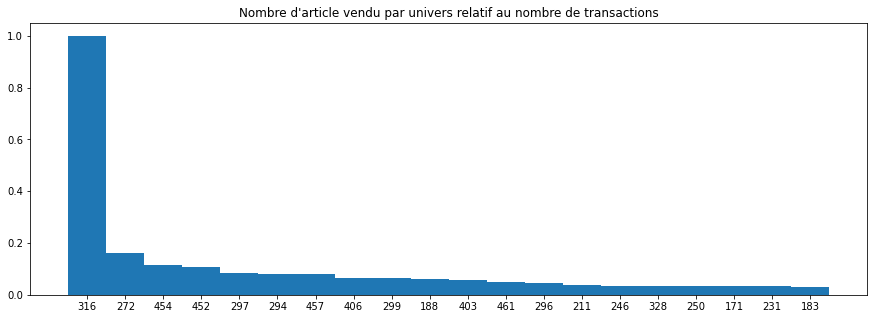

==============317===================
649
Time Taken to load recurence: ~0secondes


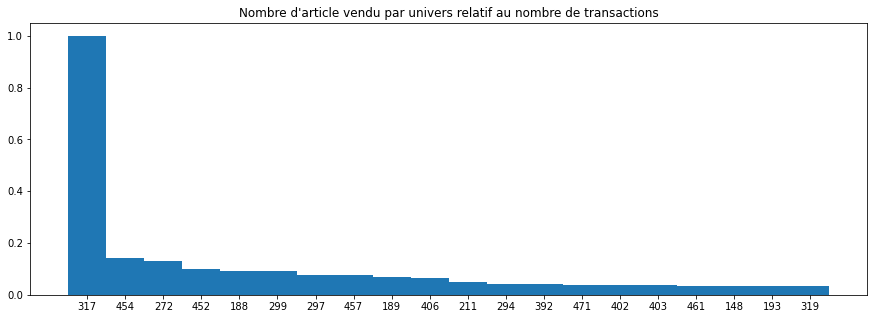

==============318===================
132
Time Taken to load recurence: ~0secondes


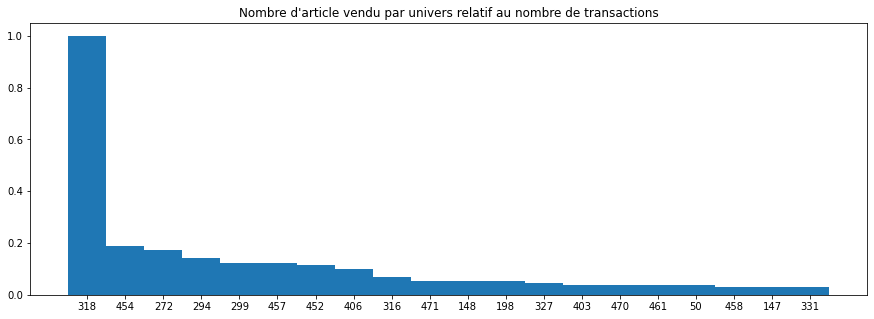

==============319===================
4273
Time Taken to load recurence: ~0secondes


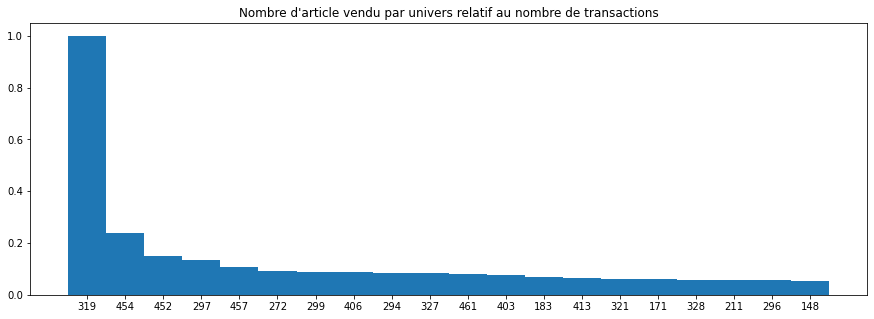

==============320===================
252
Time Taken to load recurence: ~0secondes


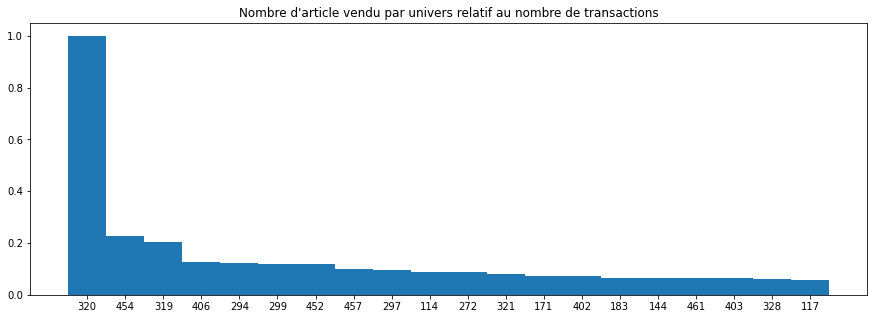

==============321===================
2834
Time Taken to load recurence: ~0secondes


==============322===================
156
Time Taken to load recurence: ~0secondes


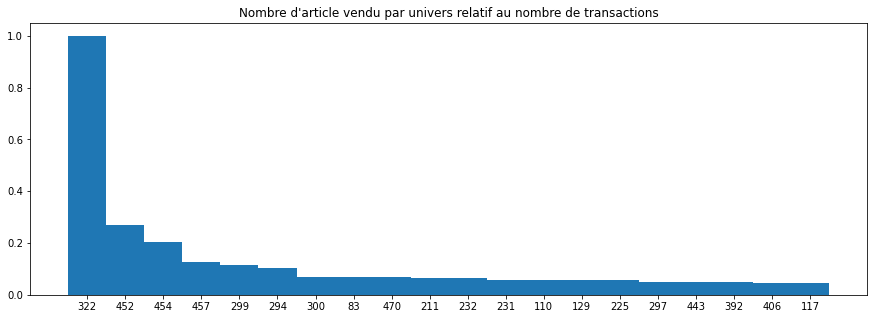

==============323===================
743
Time Taken to load recurence: ~0secondes


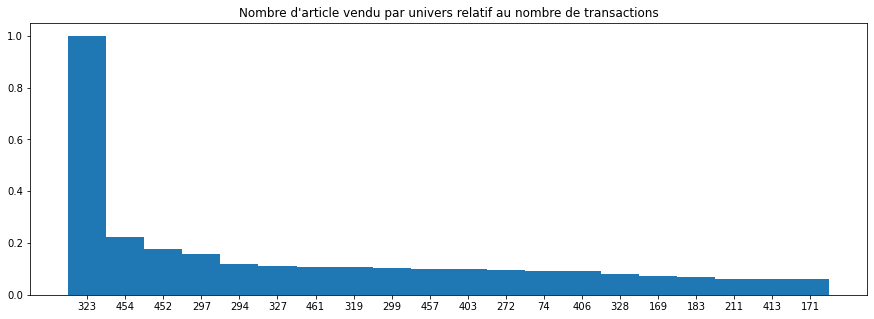

==============324===================
1495
Time Taken to load recurence: ~0secondes


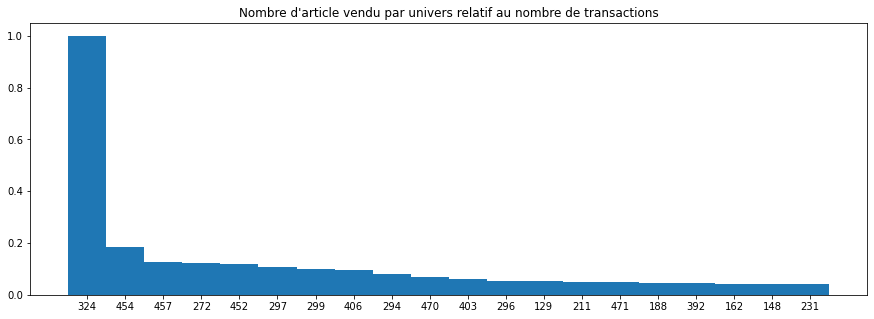

==============325===================
NOT ENOUGH DATA 
==============326===================
103
Time Taken to load recurence: ~0secondes


==============327===================
2188
Time Taken to load recurence: ~0secondes


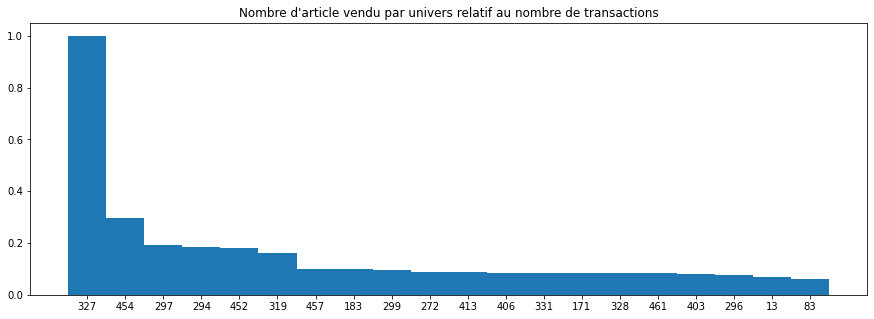

==============328===================
2922
Time Taken to load recurence: ~0secondes


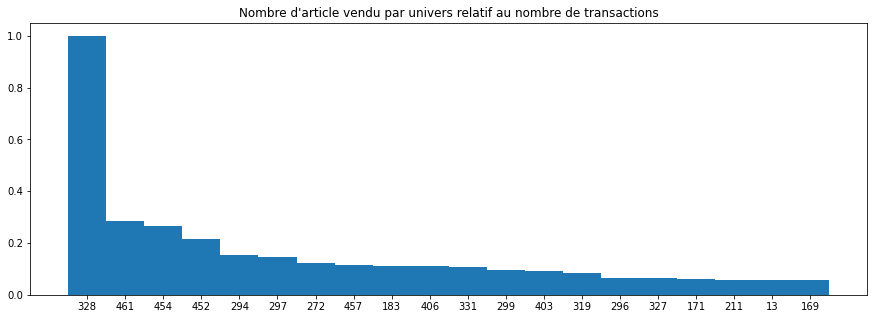

==============329===================
158
Time Taken to load recurence: ~0secondes


==============330===================
NOT ENOUGH DATA 
==============331===================
1749
Time Taken to load recurence: ~0secondes


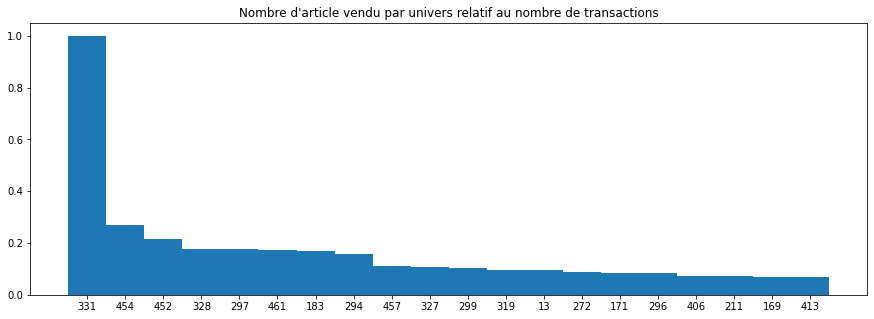

==============332===================
NOT ENOUGH DATA 
==============333===================
1194
Time Taken to load recurence: ~0secondes


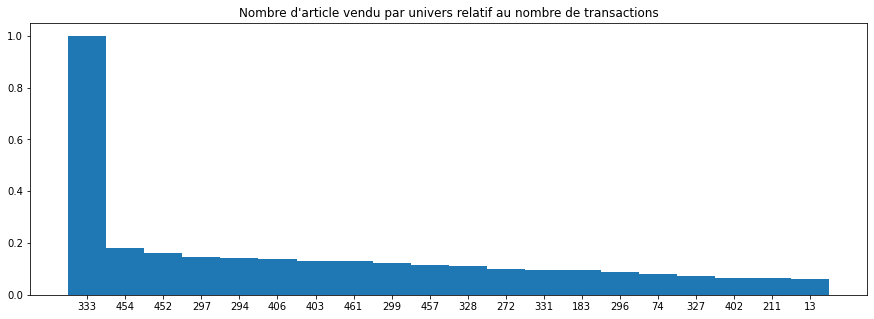

==============334===================
760
Time Taken to load recurence: ~0secondes


==============335===================
323
Time Taken to load recurence: ~0secondes


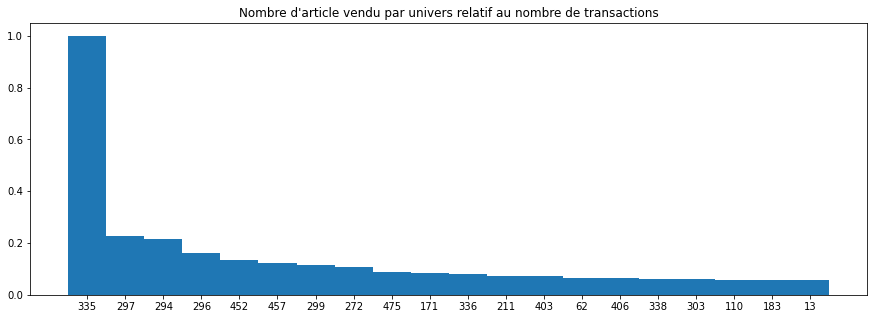

==============336===================
1034
Time Taken to load recurence: ~0secondes


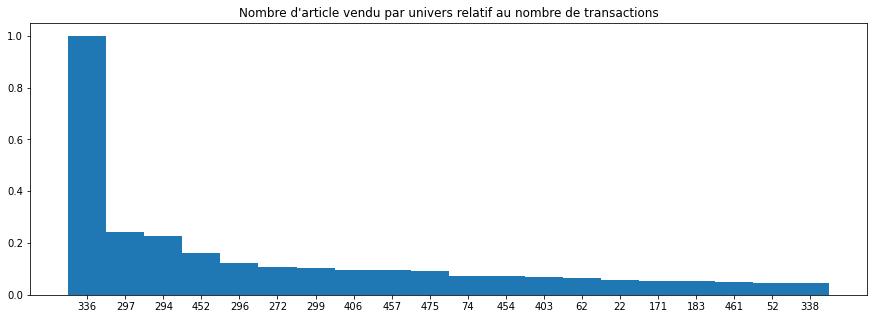

==============337===================
188
Time Taken to load recurence: ~0secondes


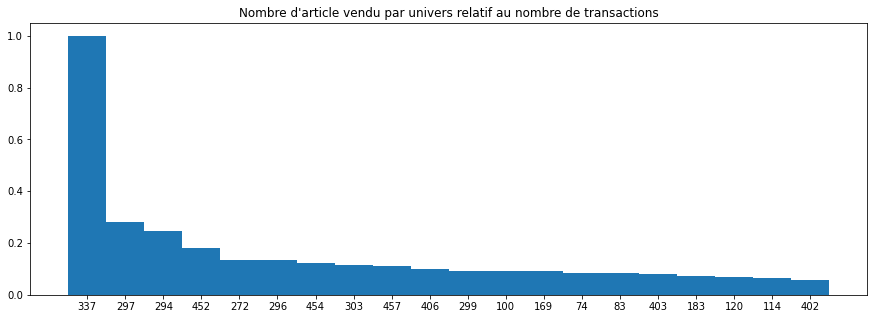

==============338===================
432
Time Taken to load recurence: ~0secondes


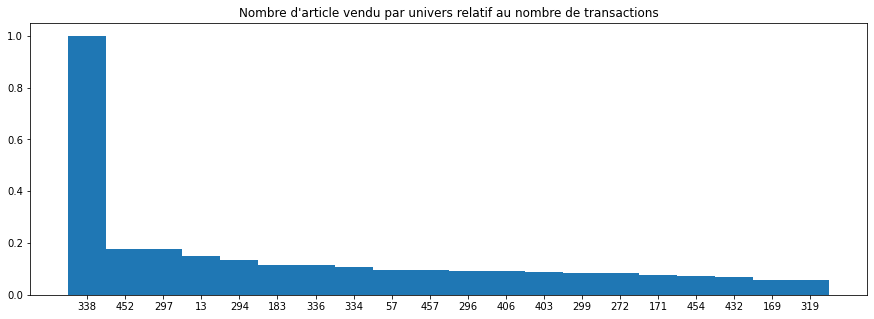

==============339===================
1728
Time Taken to load recurence: ~0secondes


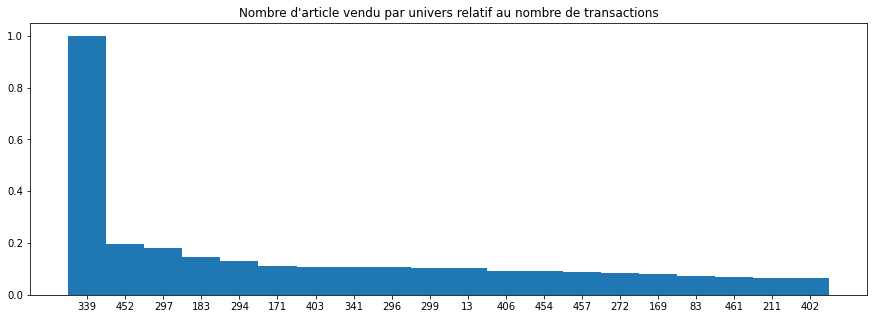

==============340===================
NOT ENOUGH DATA 
==============341===================
2077
Time Taken to load recurence: ~0secondes


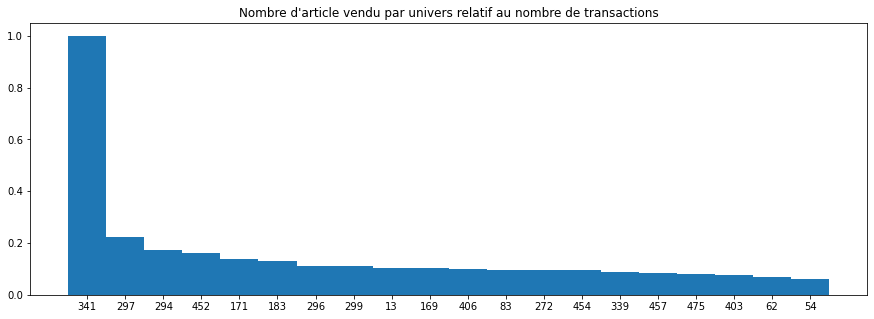

==============342===================
197
Time Taken to load recurence: ~0secondes


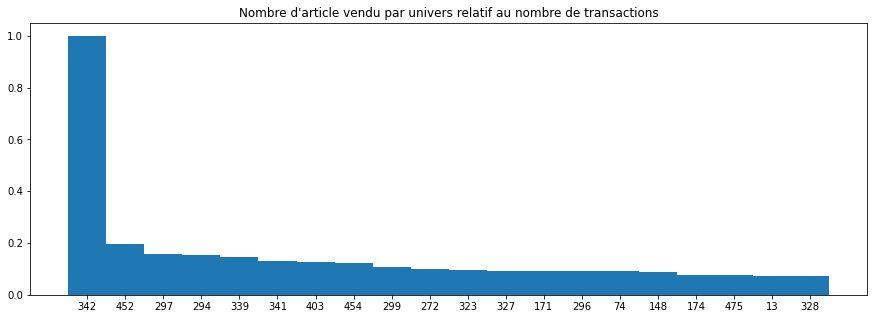

==============343===================
467
Time Taken to load recurence: ~0secondes


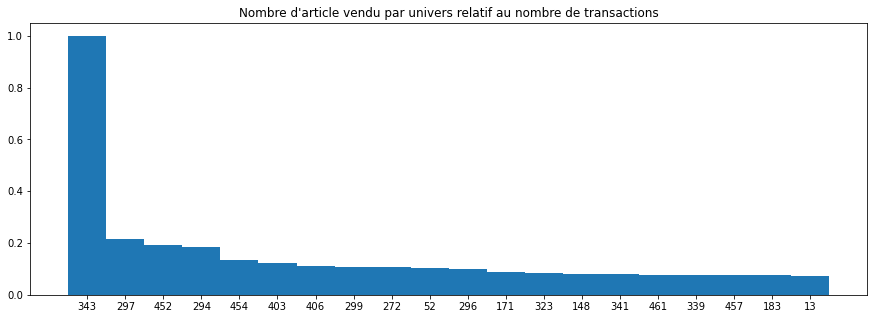

==============344===================
1017
Time Taken to load recurence: ~0secondes


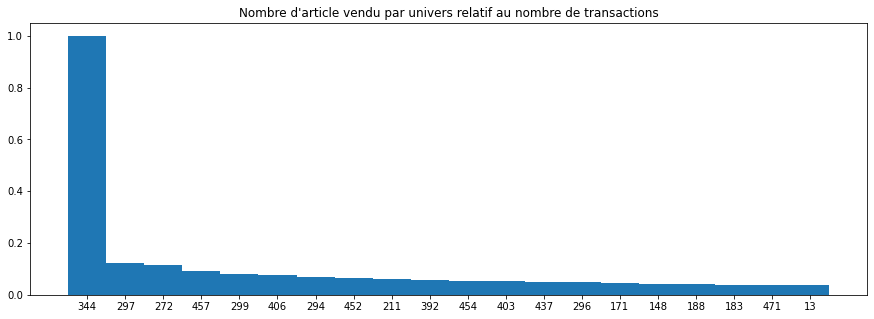

==============345===================
NOT ENOUGH DATA 
==============346===================
NOT ENOUGH DATA 
==============347===================
NOT ENOUGH DATA 
==============348===================
271
Time Taken to load recurence: ~0secondes


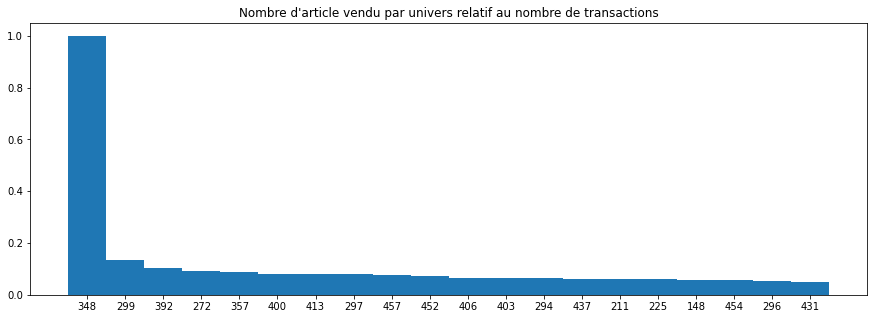

==============349===================
NOT ENOUGH DATA 
==============350===================
NOT ENOUGH DATA 
==============351===================
106
Time Taken to load recurence: ~0secondes


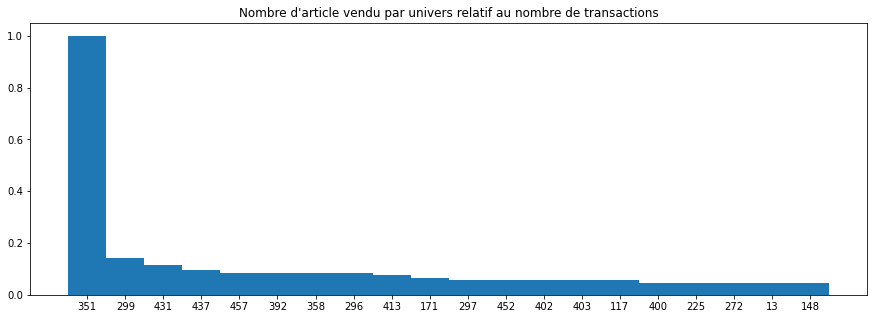

==============352===================
NOT ENOUGH DATA 
==============353===================
720
Time Taken to load recurence: ~0secondes


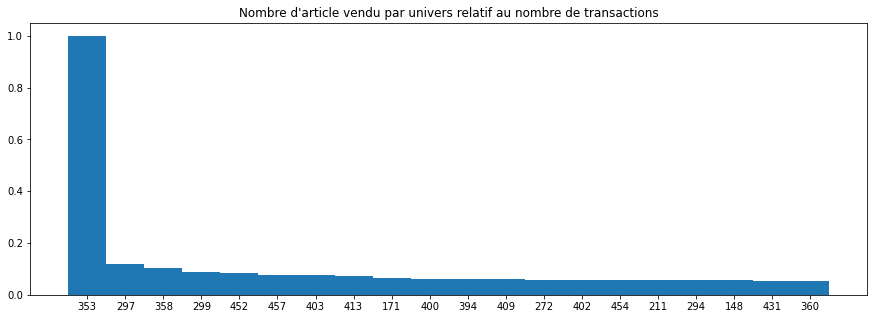

==============354===================
NOT ENOUGH DATA 
==============355===================
859
Time Taken to load recurence: ~0secondes


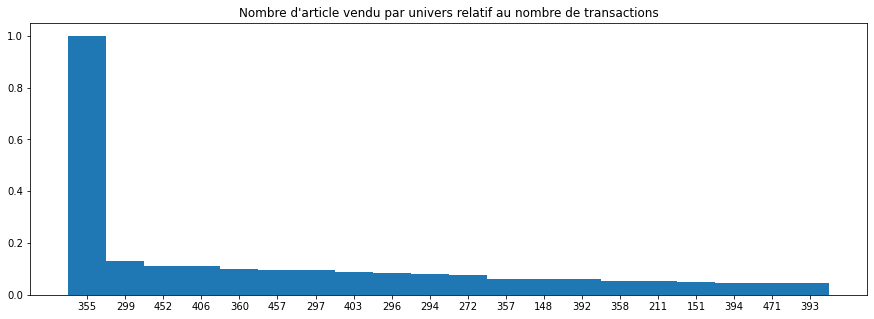

==============356===================
199
Time Taken to load recurence: ~0secondes


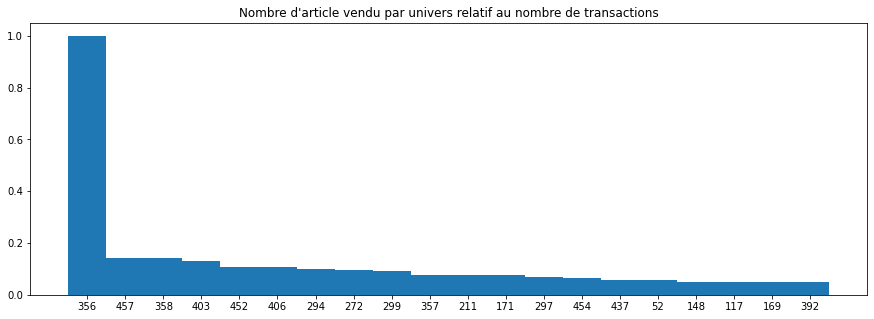

==============357===================
7709
Time Taken to load recurence: ~0secondes


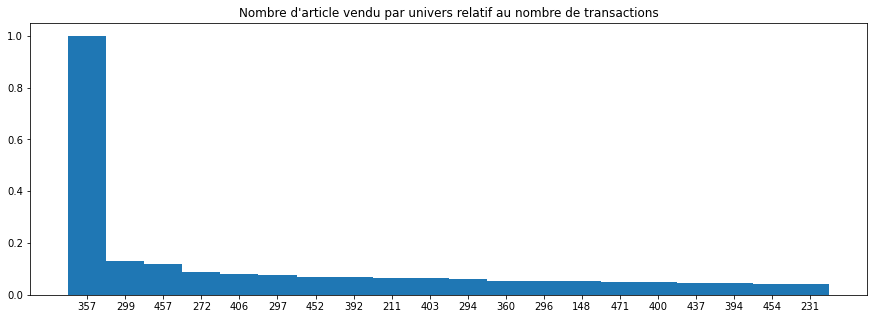

==============358===================
3136
Time Taken to load recurence: ~0secondes


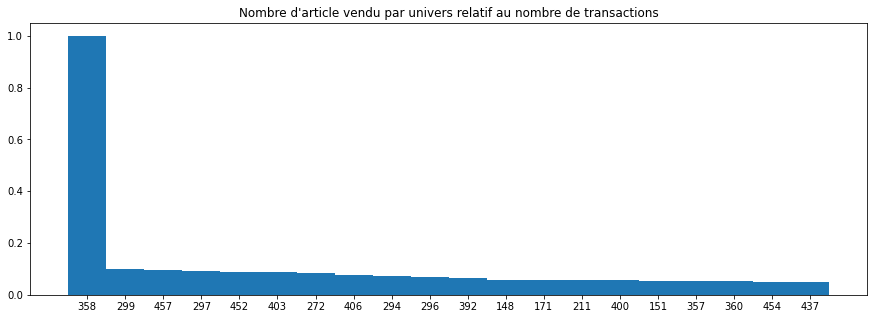

==============359===================
553
Time Taken to load recurence: ~0secondes


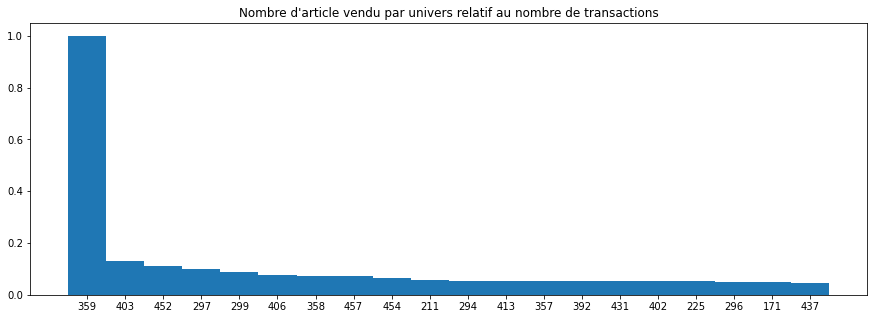

==============360===================
6568
Time Taken to load recurence: ~0secondes


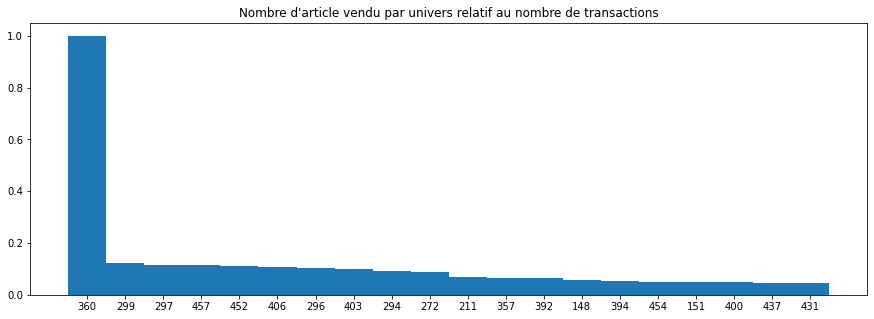

==============361===================
1226
Time Taken to load recurence: ~0secondes


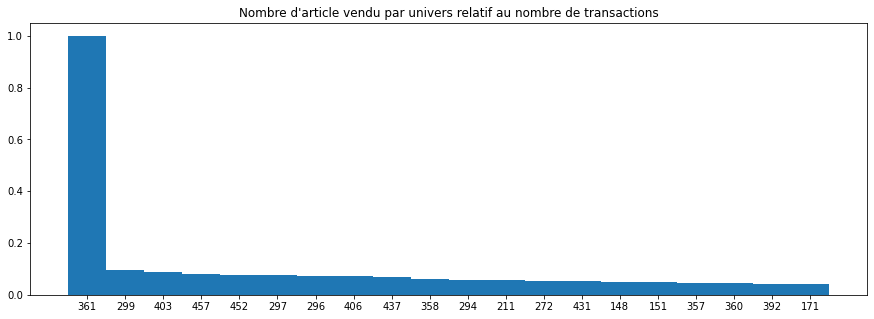

==============362===================
963
Time Taken to load recurence: ~0secondes


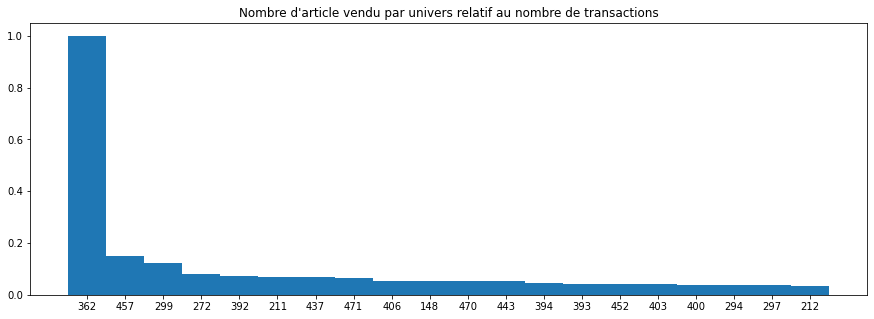

==============363===================
290
Time Taken to load recurence: ~0secondes


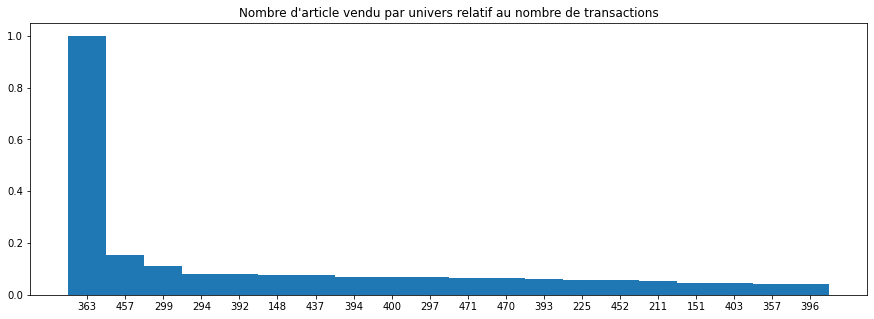

==============364===================
NOT ENOUGH DATA 
==============365===================
NOT ENOUGH DATA 
==============366===================
223
Time Taken to load recurence: ~0secondes


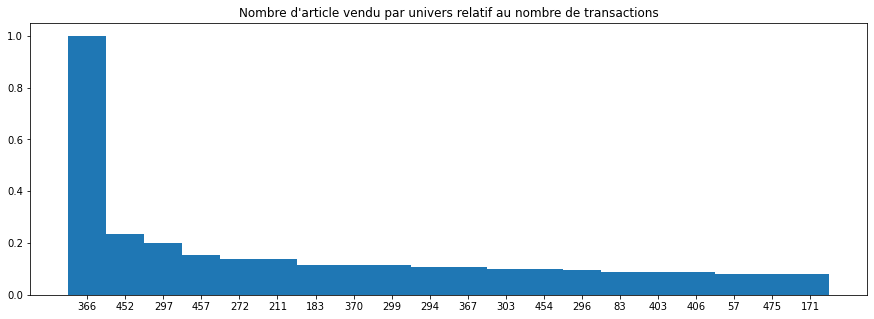

==============367===================
124
Time Taken to load recurence: ~0secondes


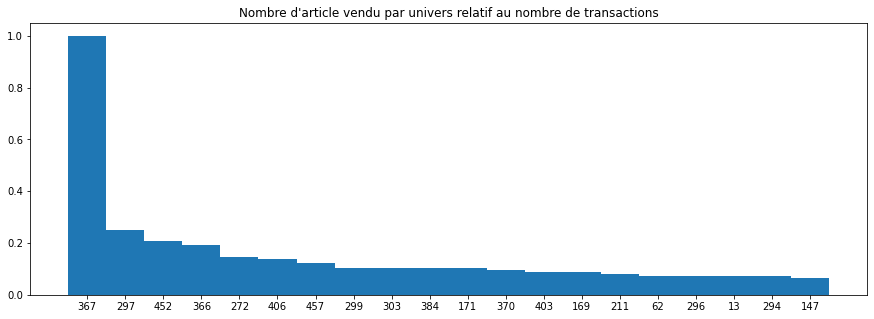

==============368===================
NOT ENOUGH DATA 
==============369===================
688
Time Taken to load recurence: ~0secondes


==============370===================
1714
Time Taken to load recurence: ~0secondes


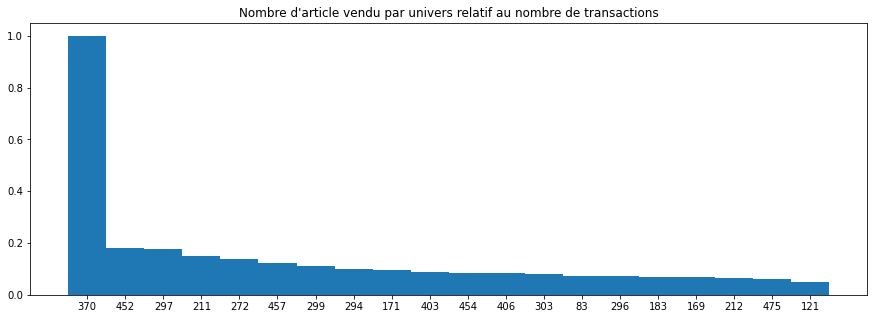

==============371===================
NOT ENOUGH DATA 
==============372===================
116
Time Taken to load recurence: ~0secondes


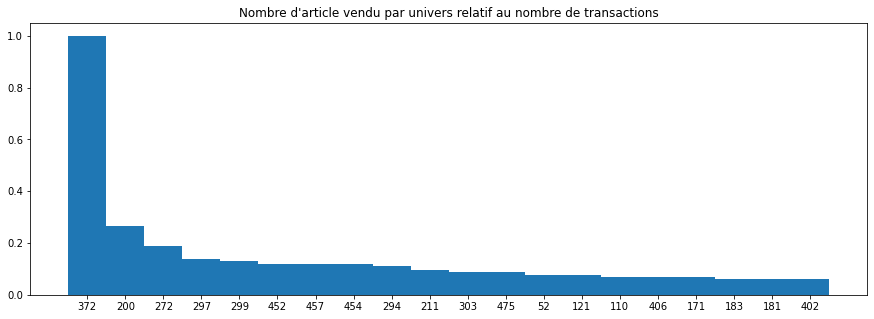

==============373===================
187
Time Taken to load recurence: ~0secondes


==============374===================
53
Time Taken to load recurence: ~0secondes


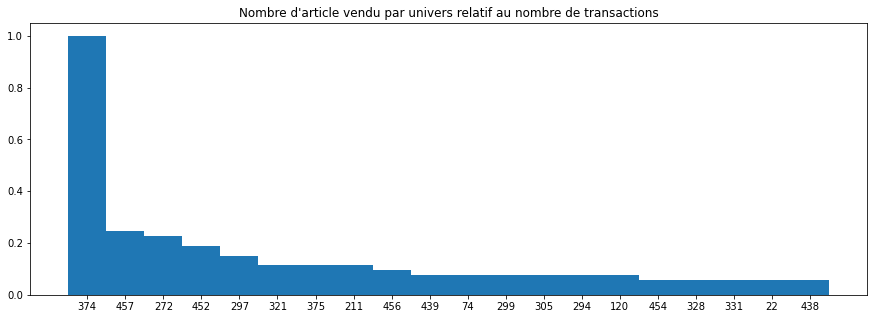

==============375===================
507
Time Taken to load recurence: ~0secondes


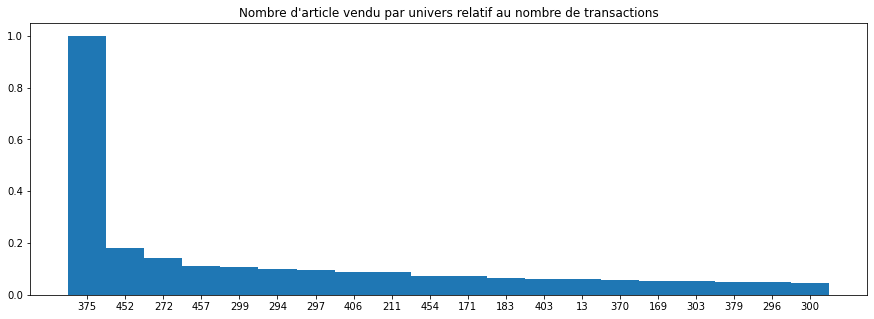

==============376===================
211
Time Taken to load recurence: ~0secondes


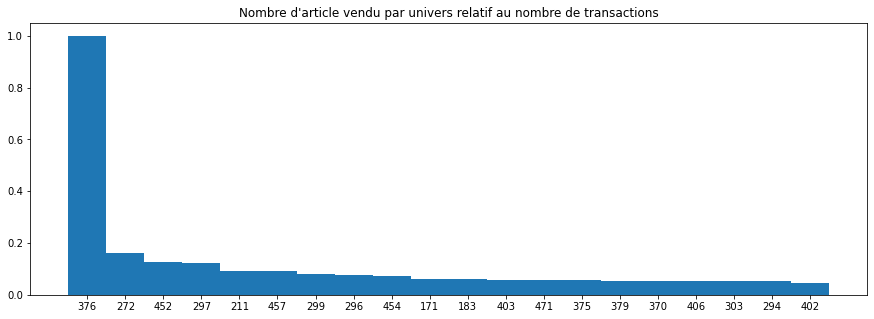

==============377===================
735
Time Taken to load recurence: ~0secondes


==============378===================
89
Time Taken to load recurence: ~0secondes


==============379===================
228
Time Taken to load recurence: ~0secondes


==============380===================
119
Time Taken to load recurence: ~0secondes


==============381===================
179
Time Taken to load recurence: ~0secondes


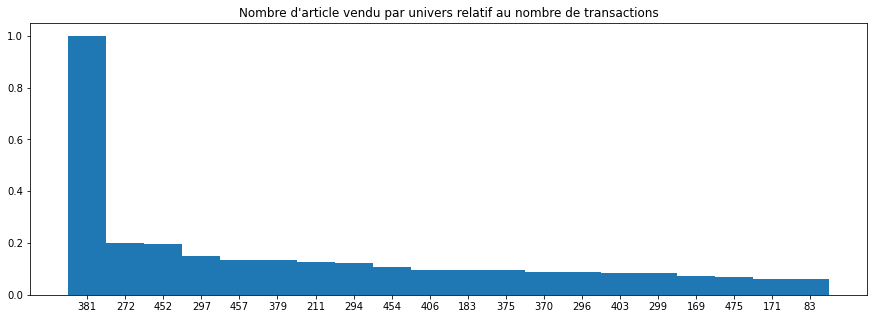

==============382===================
492
Time Taken to load recurence: ~0secondes


==============383===================
NOT ENOUGH DATA 
==============384===================
558
Time Taken to load recurence: ~0secondes


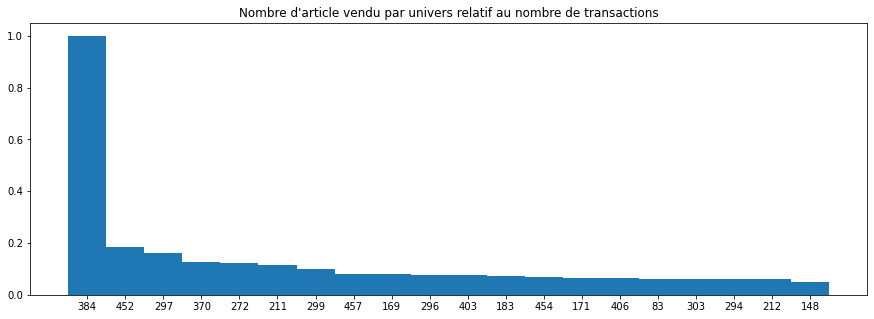

==============385===================
NOT ENOUGH DATA 
==============386===================
1356
Time Taken to load recurence: ~0secondes


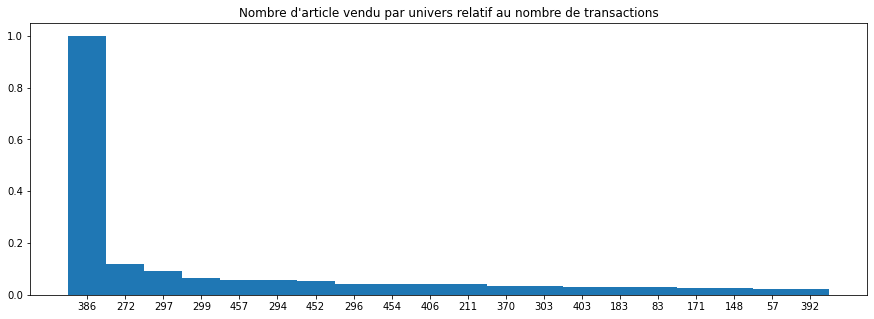

==============387===================
348
Time Taken to load recurence: ~0secondes


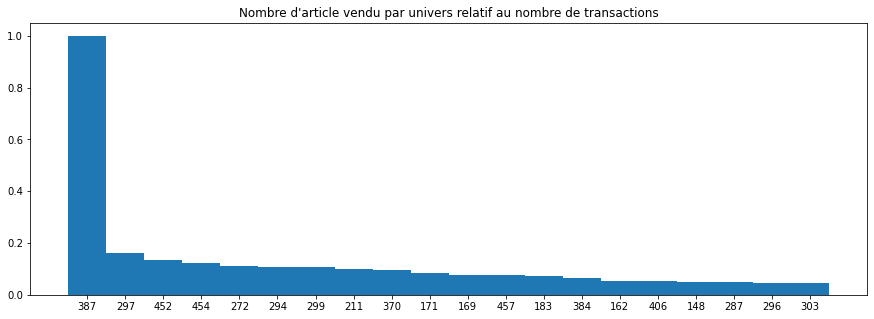

==============388===================
NOT ENOUGH DATA 
==============389===================
NOT ENOUGH DATA 
==============390===================
NOT ENOUGH DATA 
==============391===================
56
Time Taken to load recurence: ~0secondes


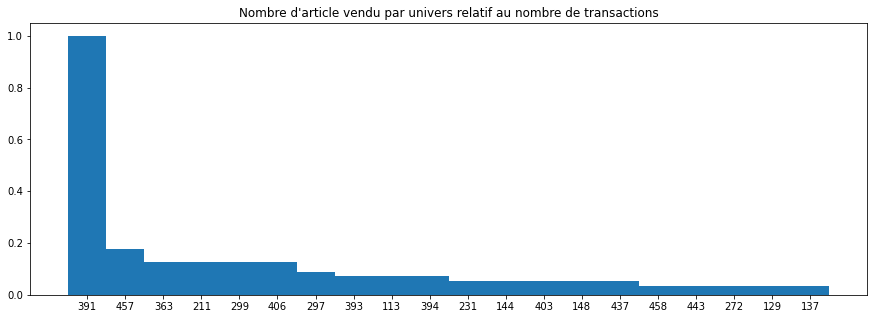

==============392===================
29130
Time Taken to load recurence: ~0secondes


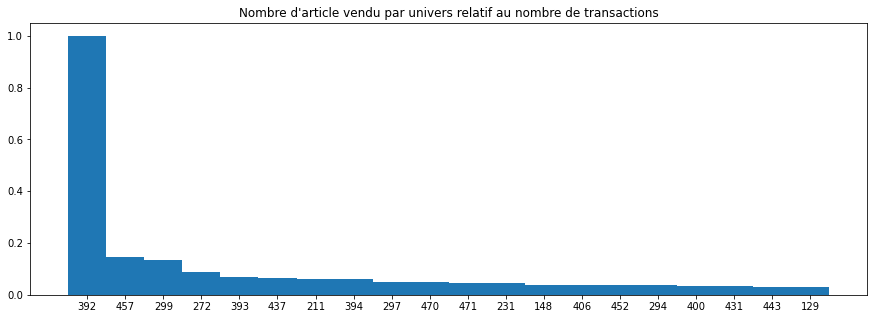

==============393===================
13107
Time Taken to load recurence: ~0secondes


==============394===================
12483
Time Taken to load recurence: ~0secondes


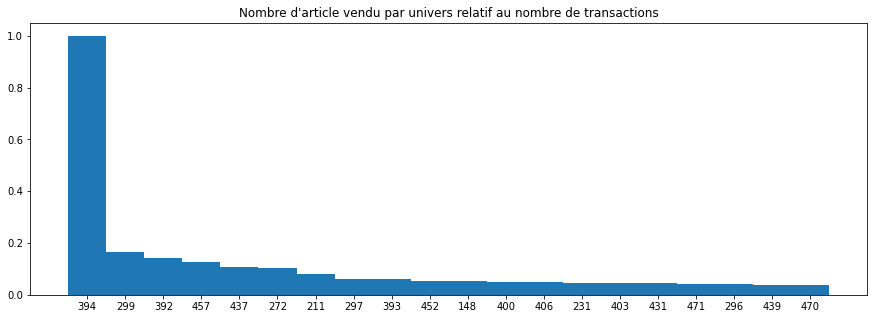

==============395===================
NOT ENOUGH DATA 
==============396===================
4413
Time Taken to load recurence: ~0secondes


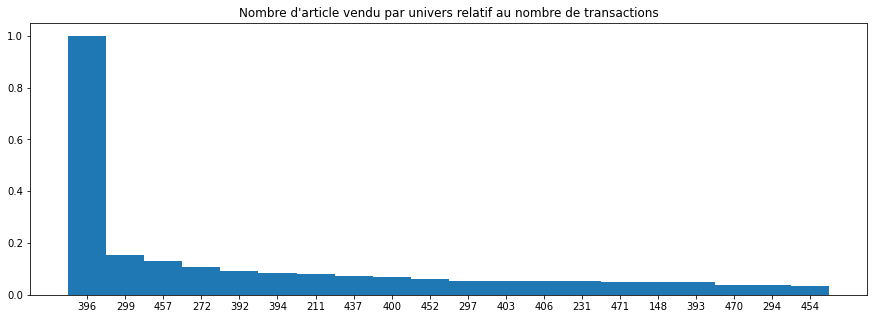

==============397===================
84
Time Taken to load recurence: ~0secondes


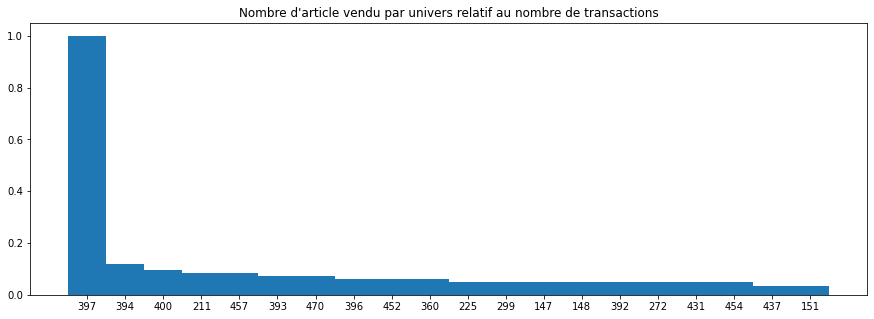

==============398===================
NOT ENOUGH DATA 
==============399===================
NOT ENOUGH DATA 
==============400===================
10202
Time Taken to load recurence: ~0secondes


==============401===================
NOT ENOUGH DATA 
==============402===================
9349
Time Taken to load recurence: ~0secondes


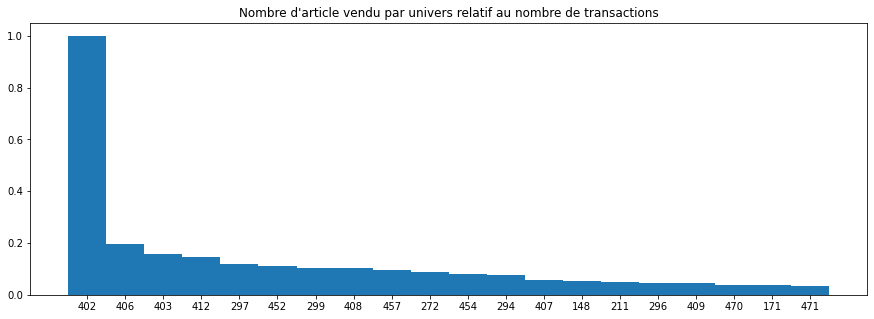

==============403===================
21345
Time Taken to load recurence: ~0secondes


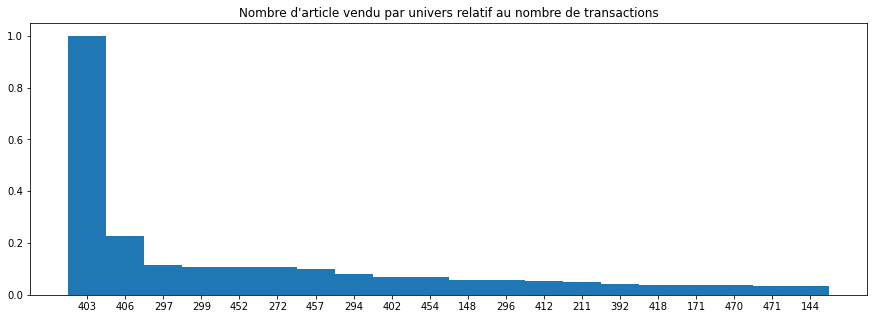

==============404===================
2542
Time Taken to load recurence: ~0secondes


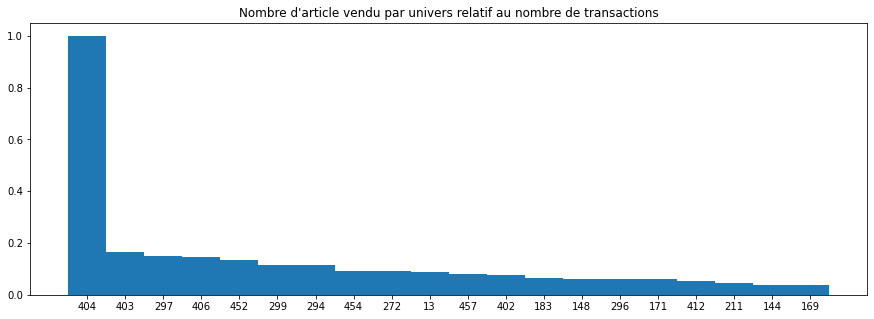

==============405===================
2970
Time Taken to load recurence: ~0secondes


==============406===================
26887
Time Taken to load recurence: ~0secondes


==============407===================
3219
Time Taken to load recurence: ~0secondes


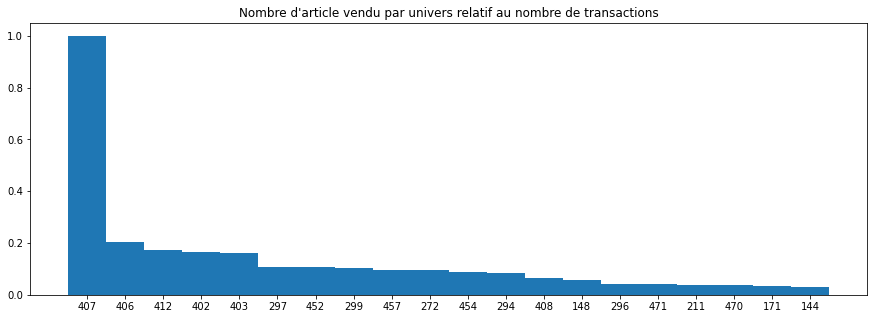

==============408===================
2825
Time Taken to load recurence: ~0secondes


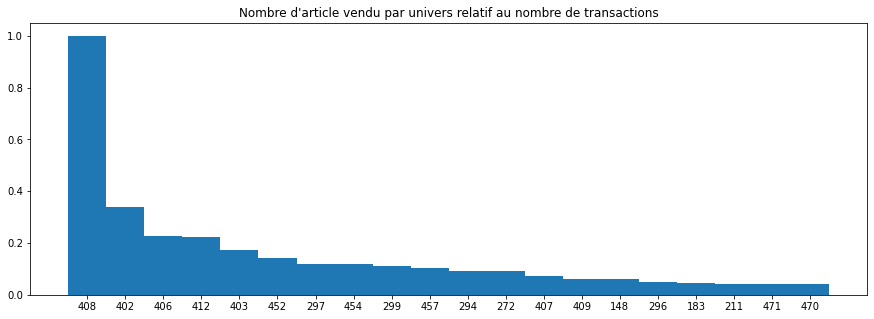

==============409===================
4114
Time Taken to load recurence: ~0secondes


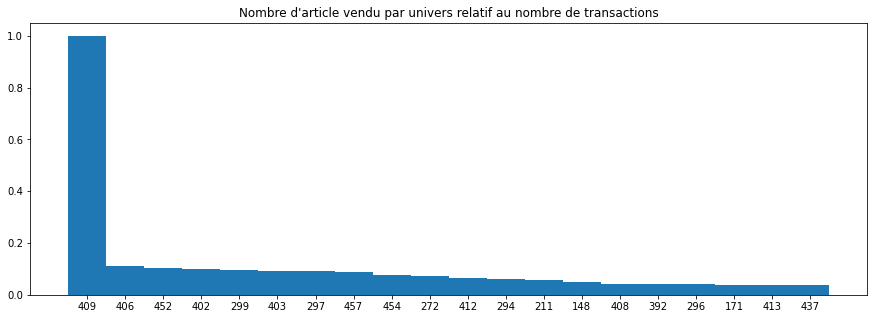

==============410===================
375
Time Taken to load recurence: ~0secondes


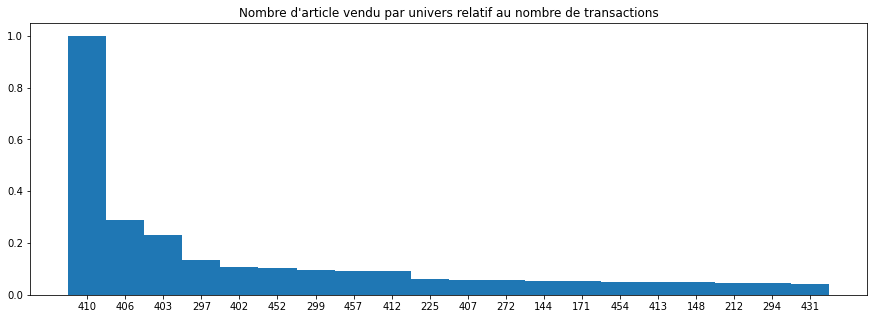

==============411===================
1061
Time Taken to load recurence: ~0secondes


==============412===================
7279
Time Taken to load recurence: ~0secondes


==============413===================
3648
Time Taken to load recurence: ~0secondes


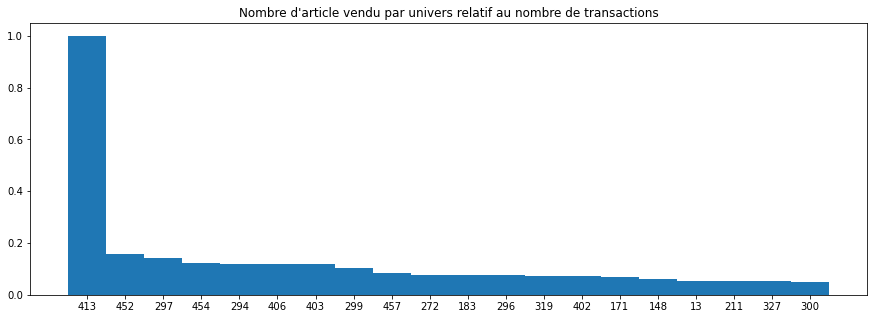

==============414===================
NOT ENOUGH DATA 
==============415===================
NOT ENOUGH DATA 
==============416===================
1766
Time Taken to load recurence: ~0secondes


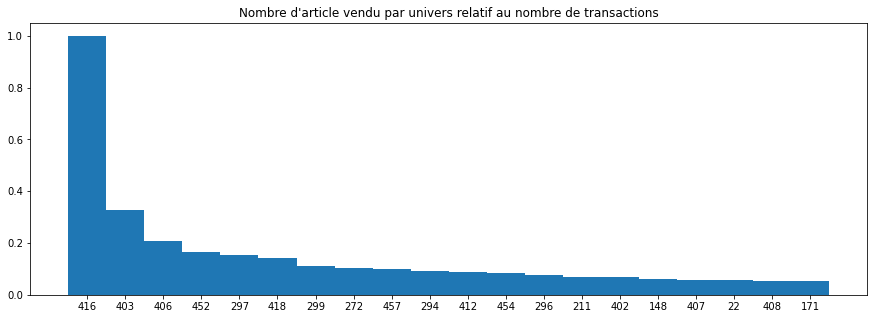

==============417===================
174
Time Taken to load recurence: ~0secondes


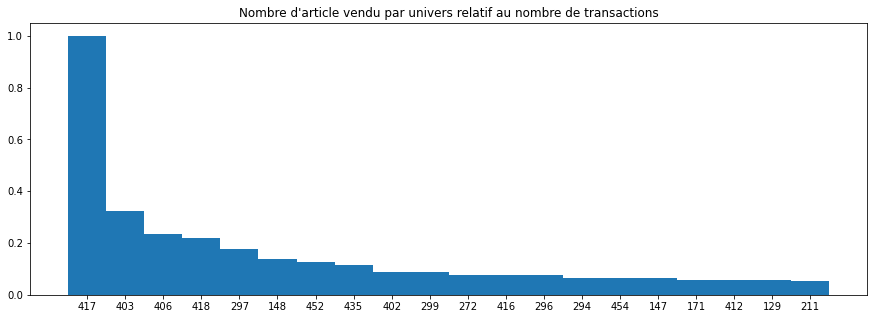

==============418===================
2227
Time Taken to load recurence: ~0secondes


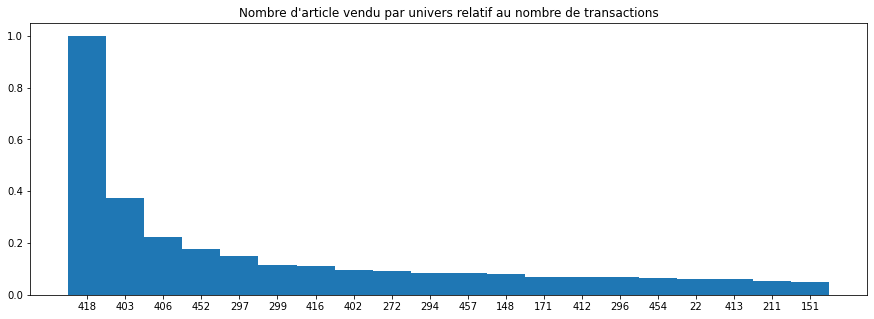

==============419===================
541
Time Taken to load recurence: ~0secondes


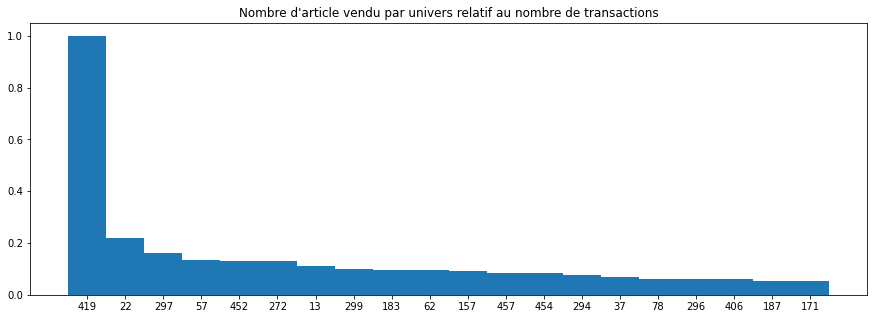

==============420===================
NOT ENOUGH DATA 
==============421===================
121
Time Taken to load recurence: ~0secondes


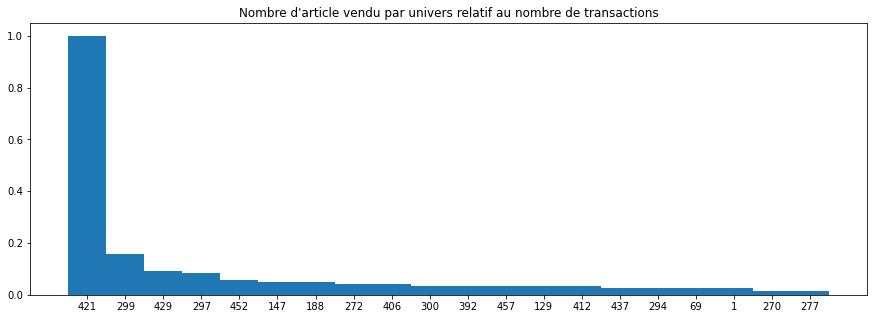

==============422===================
NOT ENOUGH DATA 
==============423===================
NOT ENOUGH DATA 
==============424===================
NOT ENOUGH DATA 
==============425===================
NOT ENOUGH DATA 
==============426===================
NOT ENOUGH DATA 
==============427===================
NOT ENOUGH DATA 
==============428===================
NOT ENOUGH DATA 
==============429===================
186
Time Taken to load recurence: ~0secondes


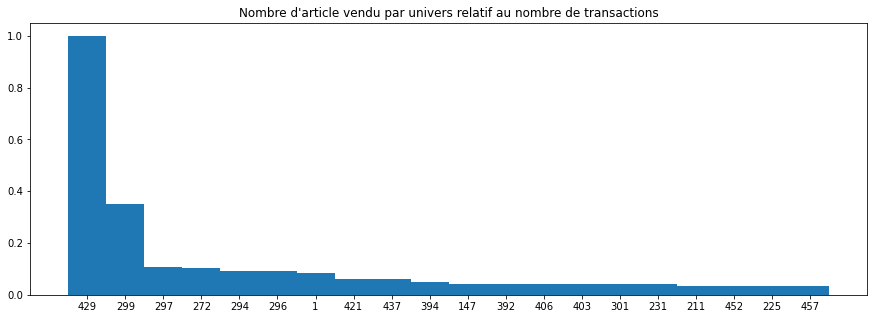

==============430===================
NOT ENOUGH DATA 
==============431===================
5325
Time Taken to load recurence: ~0secondes


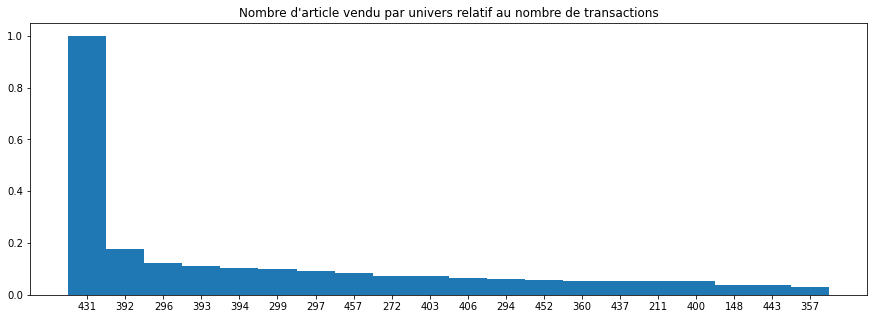

==============432===================
1891
Time Taken to load recurence: ~0secondes


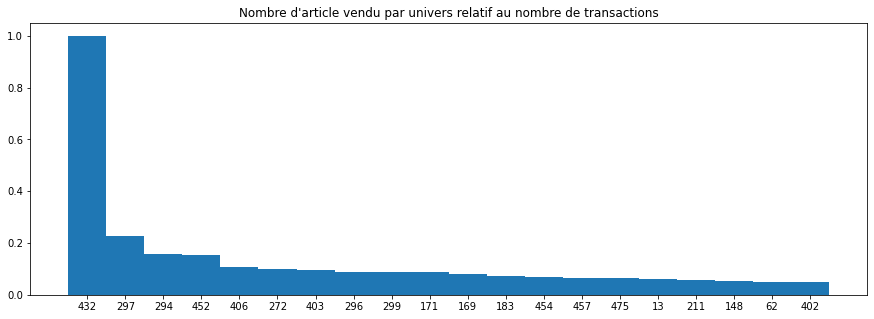

==============433===================
230
Time Taken to load recurence: ~0secondes


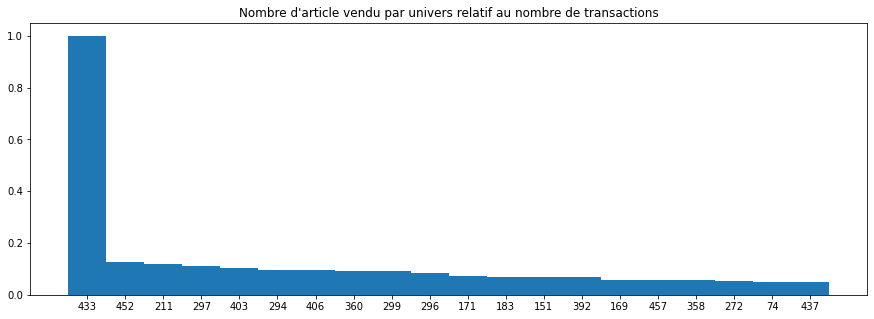

==============434===================
NOT ENOUGH DATA 
==============435===================
5467
Time Taken to load recurence: ~0secondes


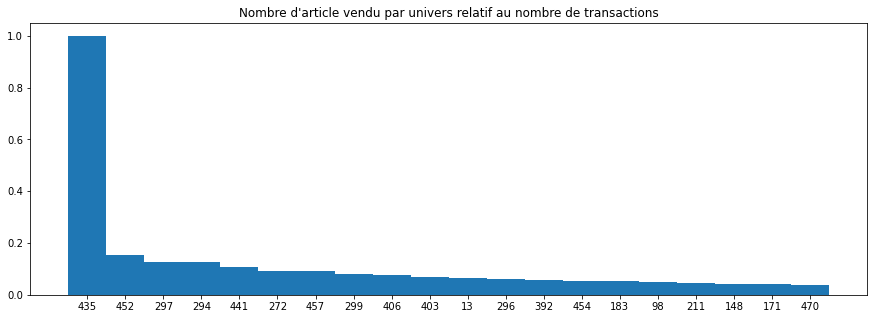

==============436===================
225
Time Taken to load recurence: ~0secondes


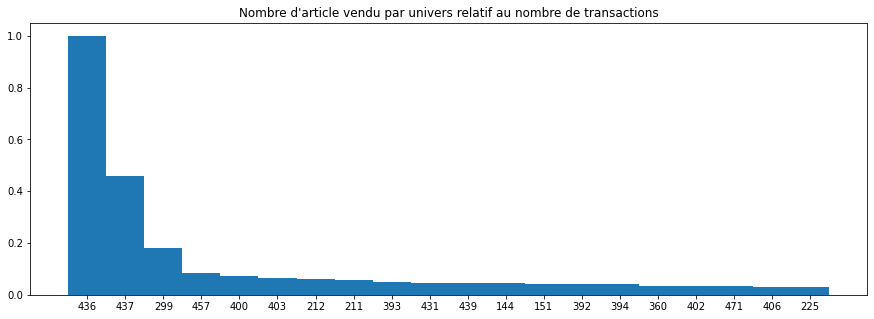

==============437===================
29504
Time Taken to load recurence: ~0secondes


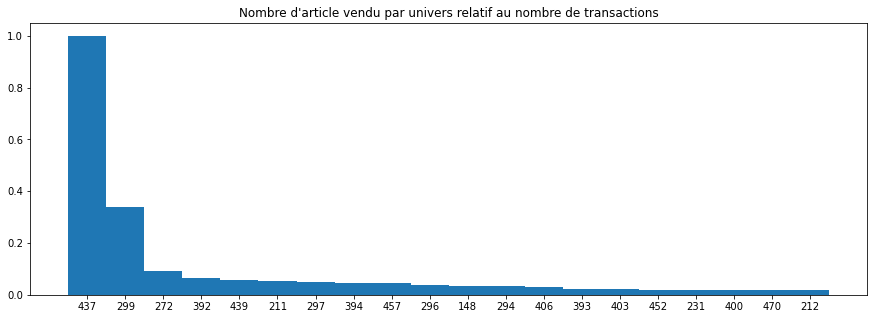

==============438===================
2656
Time Taken to load recurence: ~0secondes


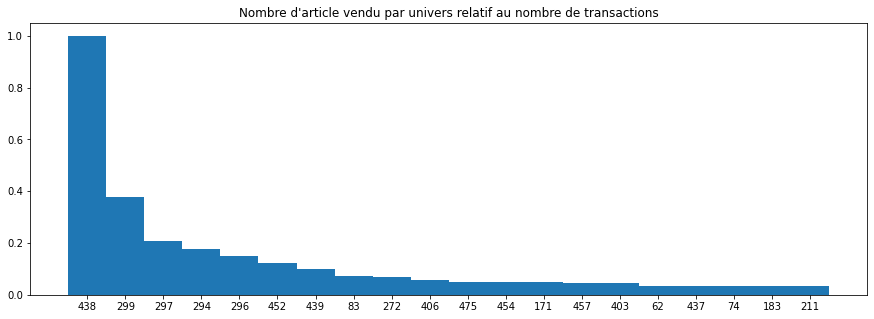

==============439===================
11502
Time Taken to load recurence: ~0secondes


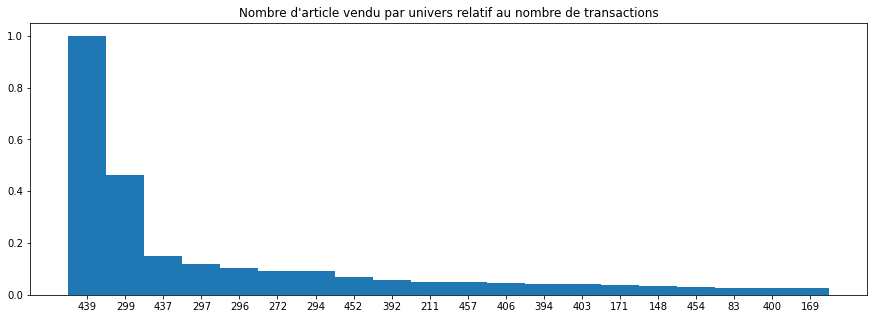

==============440===================
NOT ENOUGH DATA 
==============441===================
1436
Time Taken to load recurence: ~0secondes


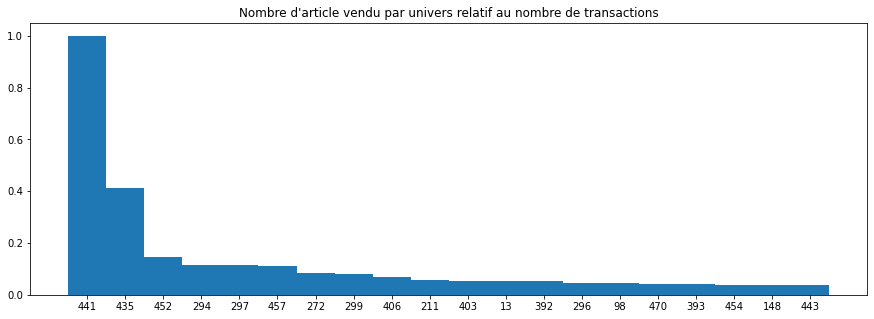

==============442===================
NOT ENOUGH DATA 
==============443===================
6427
Time Taken to load recurence: ~0secondes


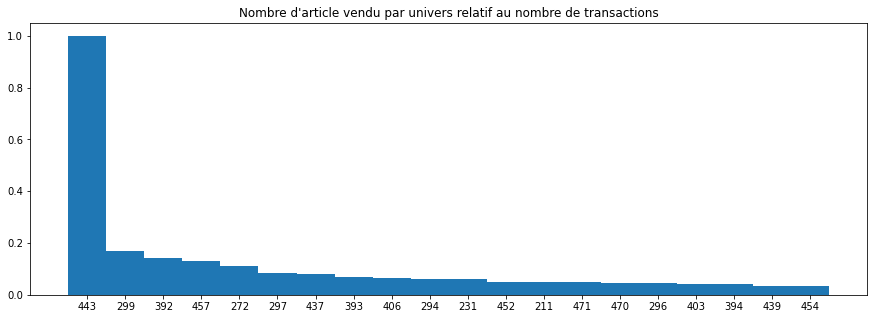

==============444===================
NOT ENOUGH DATA 
==============445===================
101
Time Taken to load recurence: ~0secondes


==============446===================
NOT ENOUGH DATA 
==============447===================
NOT ENOUGH DATA 
==============448===================
1029
Time Taken to load recurence: ~0secondes


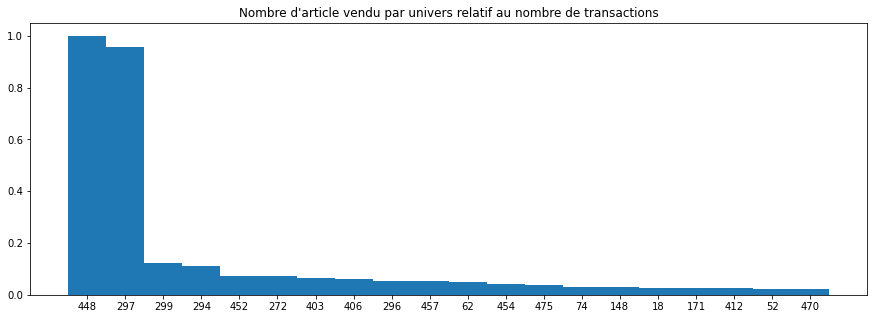

==============449===================
NOT ENOUGH DATA 
==============450===================
NOT ENOUGH DATA 
==============451===================
NOT ENOUGH DATA 
==============452===================
19350
Time Taken to load recurence: ~0secondes


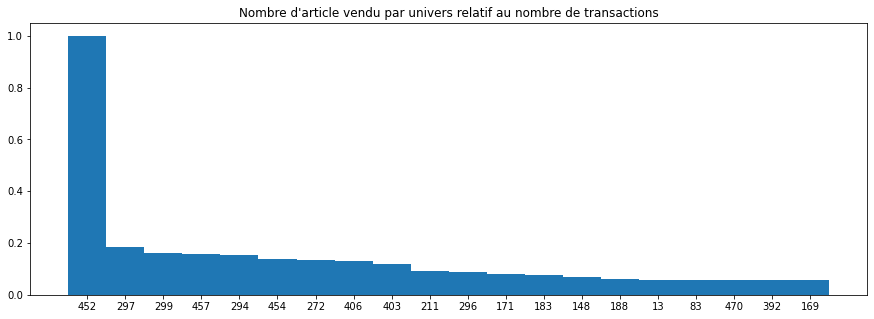

==============453===================
154
Time Taken to load recurence: ~0secondes


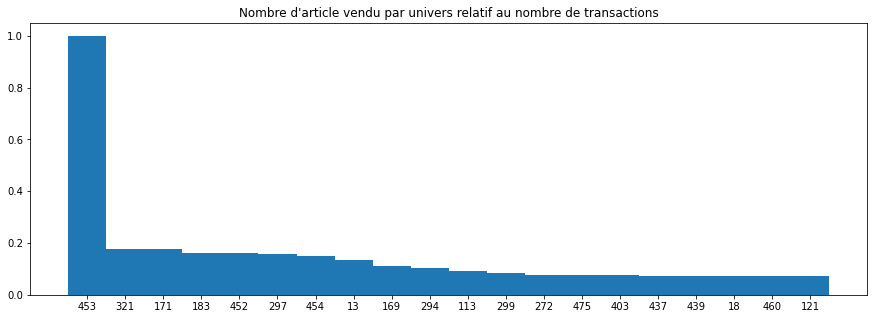

==============454===================
20352
Time Taken to load recurence: ~0secondes


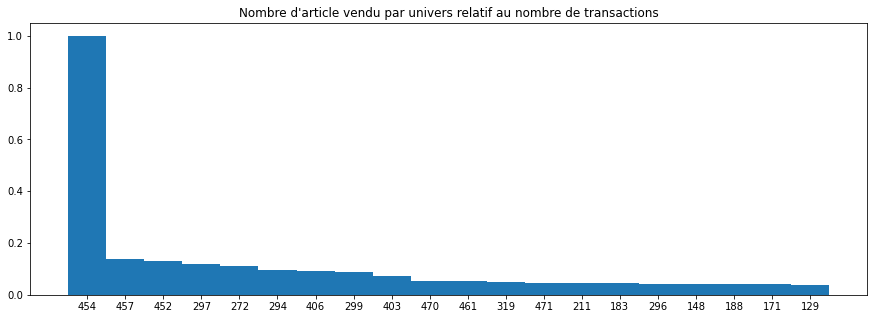

==============455===================
2381
Time Taken to load recurence: ~0secondes


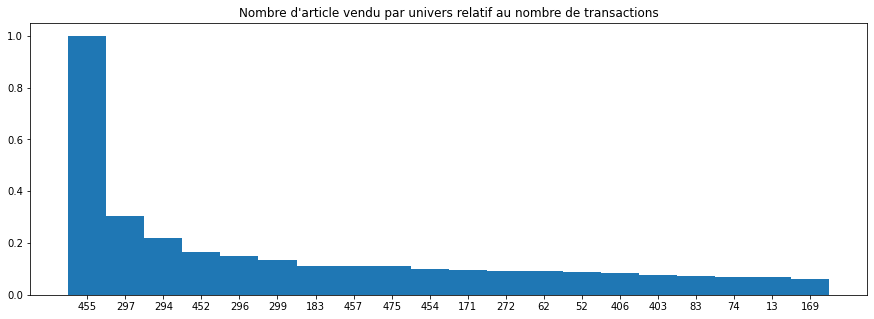

==============456===================
3803
Time Taken to load recurence: ~0secondes


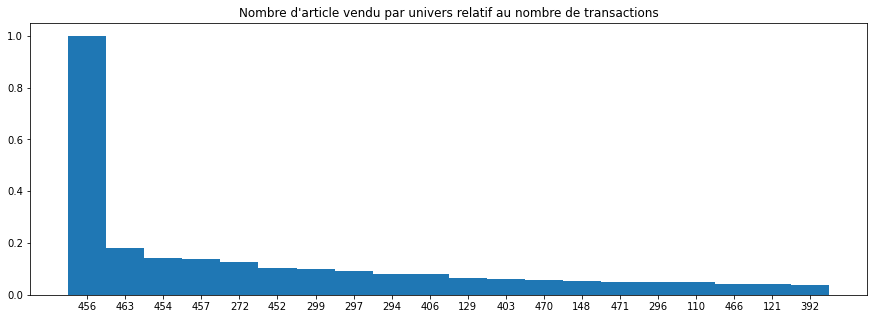

==============457===================
35145
Time Taken to load recurence: ~0secondes


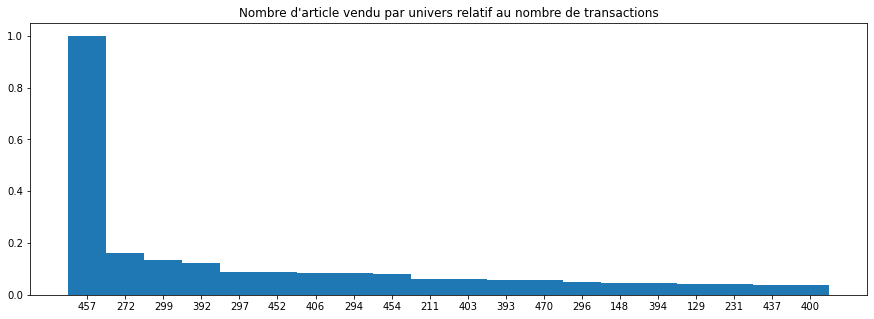

==============458===================
3794
Time Taken to load recurence: ~0secondes


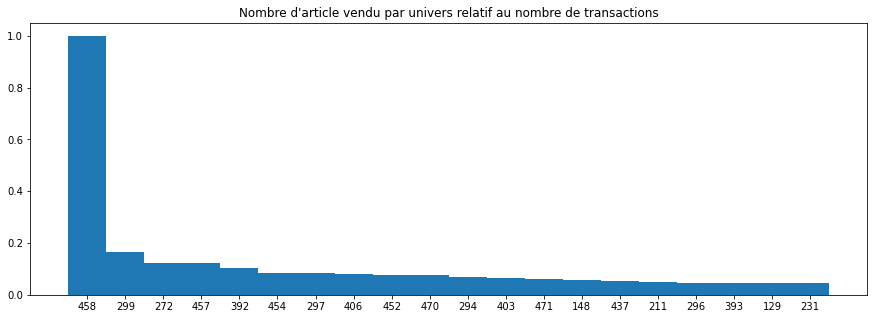

==============459===================
NOT ENOUGH DATA 
==============460===================
925
Time Taken to load recurence: ~0secondes


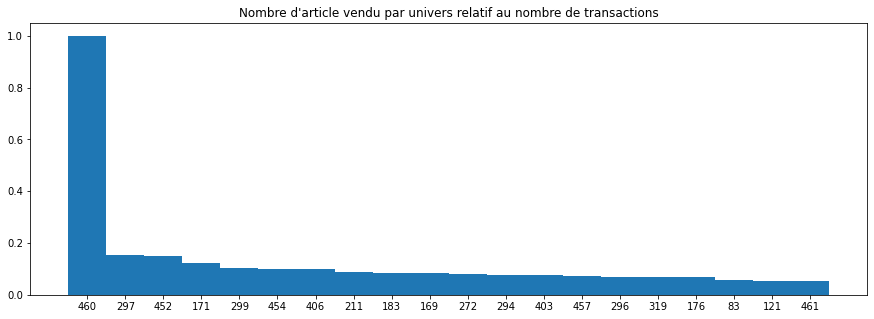

==============461===================
5936
Time Taken to load recurence: ~0secondes


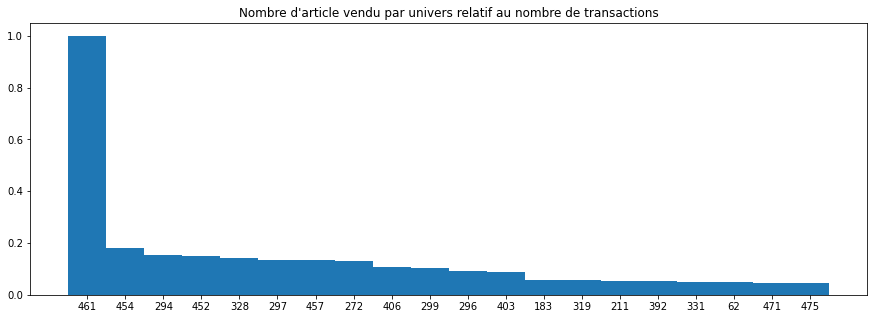

==============462===================
3203
Time Taken to load recurence: ~0secondes


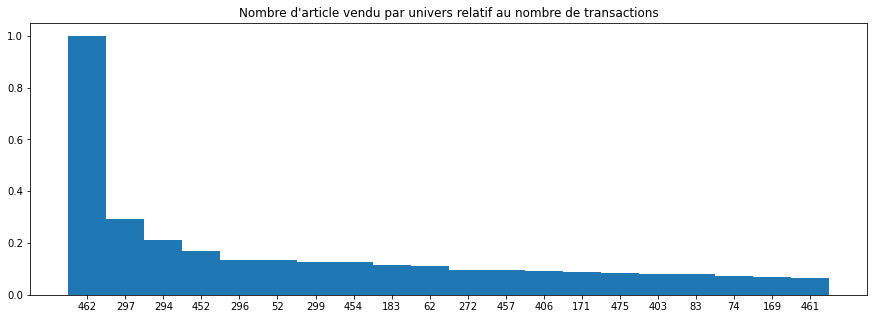

==============463===================
5939
Time Taken to load recurence: ~0secondes


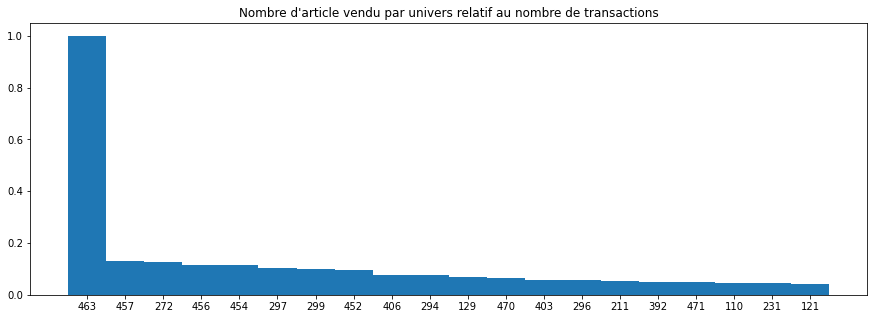

==============464===================
1140
Time Taken to load recurence: ~0secondes


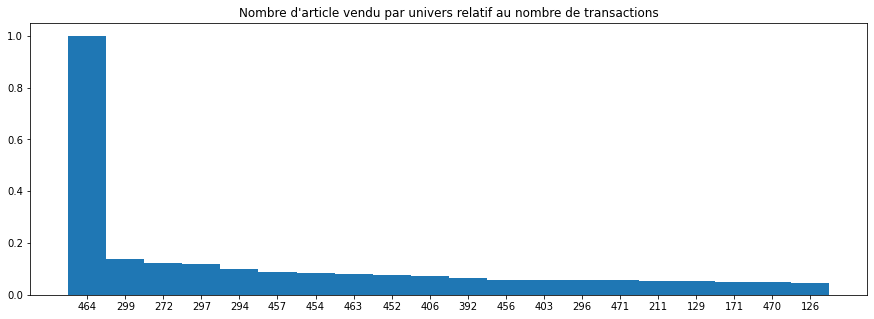

==============465===================
1367
Time Taken to load recurence: ~0secondes


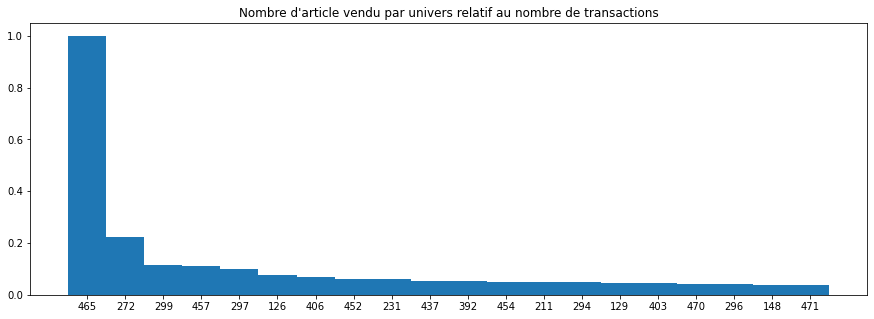

==============466===================
2157
Time Taken to load recurence: ~0secondes


==============467===================
434
Time Taken to load recurence: ~0secondes


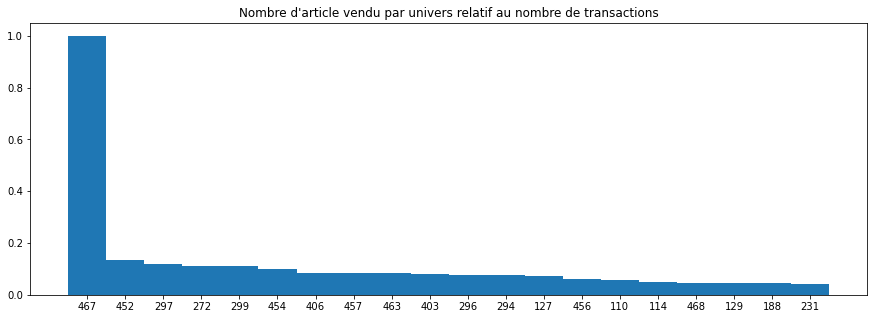

==============468===================
1118
Time Taken to load recurence: ~0secondes


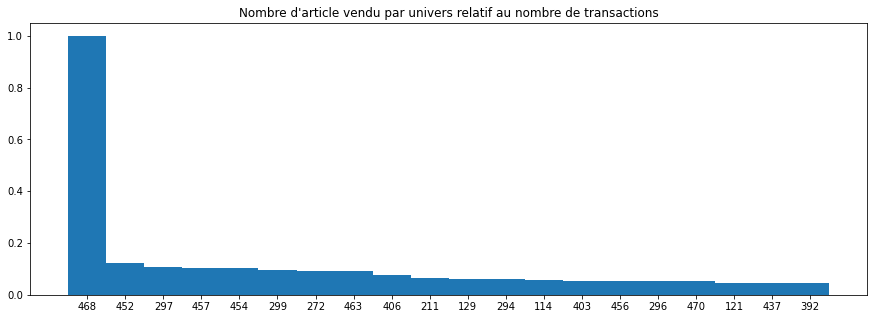

==============469===================
2229
Time Taken to load recurence: ~0secondes


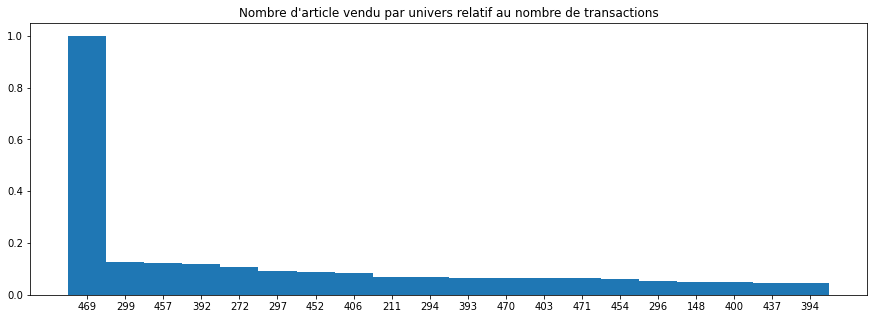

==============470===================
12017
Time Taken to load recurence: ~0secondes


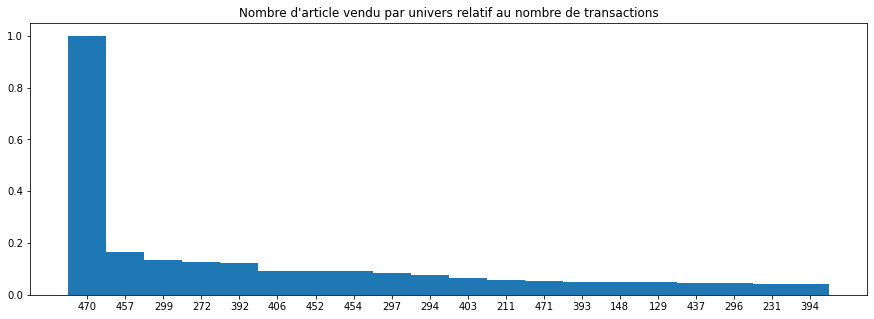

==============471===================
11647
Time Taken to load recurence: ~0secondes


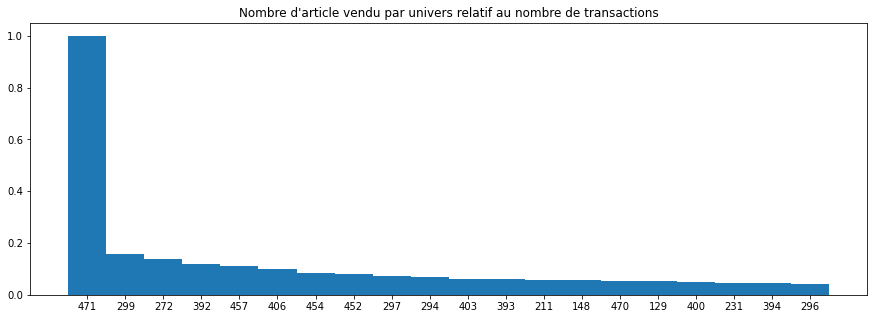

==============472===================
5430
Time Taken to load recurence: ~0secondes


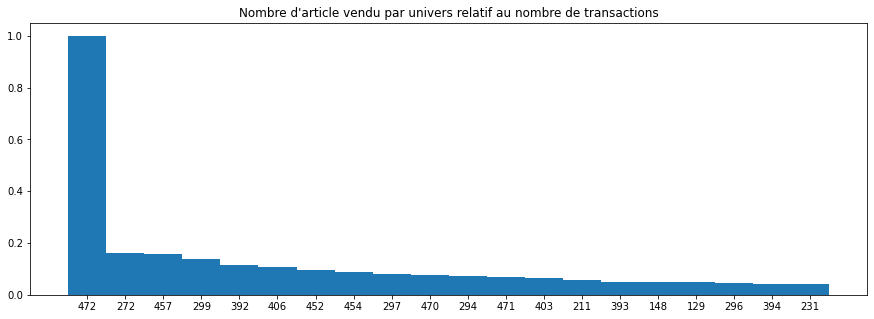

==============473===================
4528
Time Taken to load recurence: ~0secondes


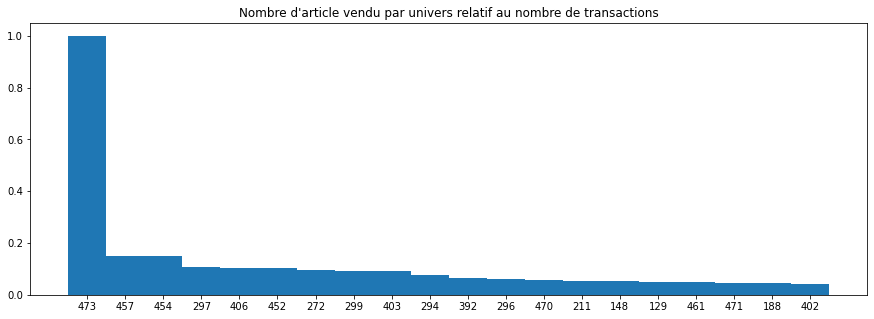

==============474===================
818
Time Taken to load recurence: ~0secondes


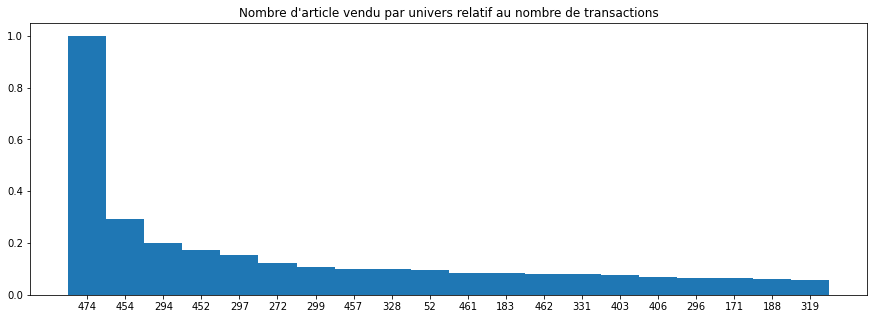

==============475===================
7020
Time Taken to load recurence: ~0secondes


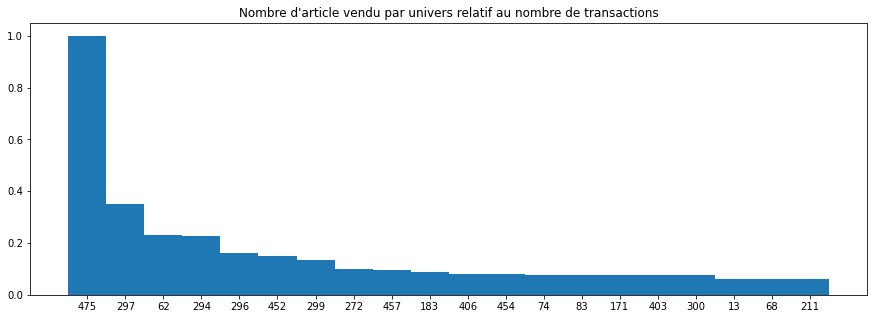

==============476===================
1696
Time Taken to load recurence: ~0secondes


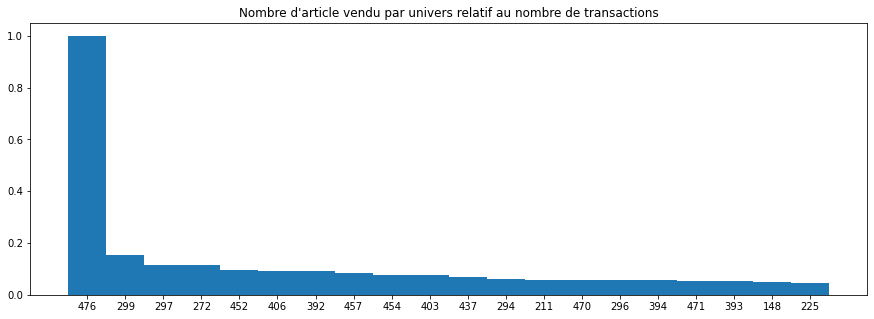

==============477===================
2413
Time Taken to load recurence: ~0secondes


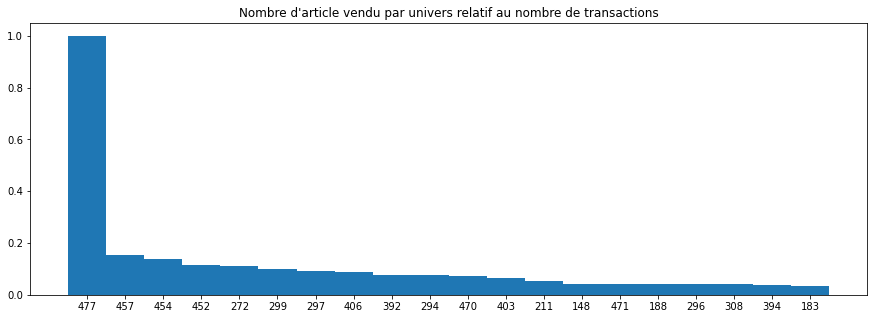

==============478===================
585
Time Taken to load recurence: ~0secondes


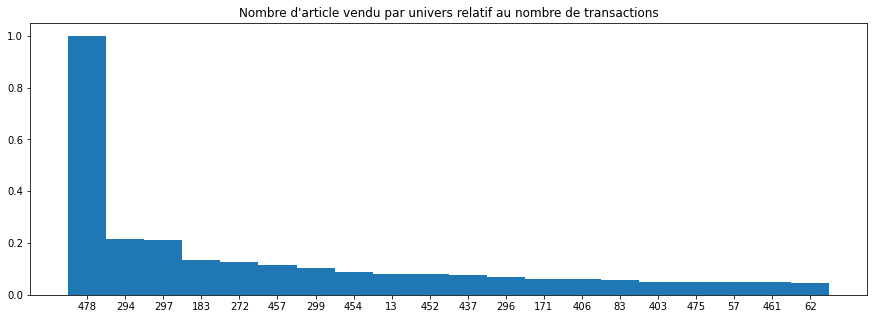

==============479===================
NOT ENOUGH DATA 
==============480===================
NOT ENOUGH DATA 
==============481===================
NOT ENOUGH DATA 
==============482===================
NOT ENOUGH DATA 
==============483===================
NOT ENOUGH DATA 
==============484===================
NOT ENOUGH DATA 
==============485===================
NOT ENOUGH DATA 
==============486===================
NOT ENOUGH DATA 
==============487===================
NOT ENOUGH DATA 
==============488===================
NOT ENOUGH DATA 
==============489===================
NOT ENOUGH DATA 
==============490===================
1223
Time Taken to load recurence: ~0secondes


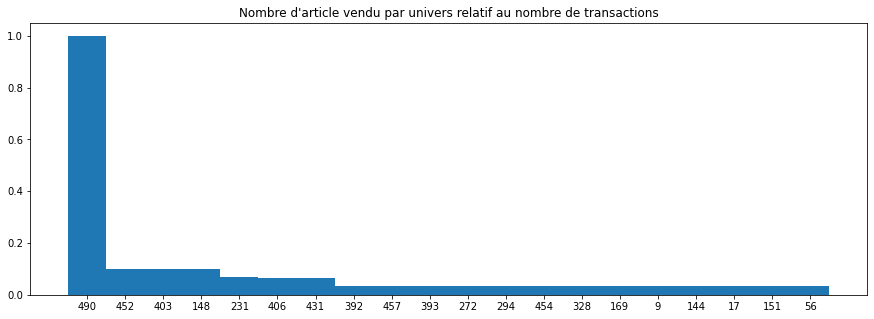

Time Taken to load all metrics: ~57secondes


In [76]:
# For all Universe, load the metrics 
start = time()

dico_metrics = {}
dico_rec_art = {}

for key in all_univ_key:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
    
    N = len(trans)
    if N <= 50:
        print("NOT ENOUGH DATA ")
        continue
    
    # Load recurence and #article per transactions
    nbr_article_sans_univ, nbr_article_univ = get_nbr_sans_univ(trans, [key])
    dico_rec_art[key], _ = load_recurence(trans)
    
    """
        8 metrics sont calculées :
            - "Proportion d'achat (%)" : Nombre de transactions contenant l'univers / nombre total de transactions
            - "Proportion d'achat seul": Nombre de fois que l'univers à été acheté seul / nombre de transactions contenant l'univers
            - "CA univ"       : CA totale produit par l'unif
            - "CA moyen univ" : "CA univ" / nombre de transaction contenant l'univers
            - "Nombre moyen article en plus" : Nombre d'article acheté qui ne sont pas dans l'univers dans les transactions contenant l'univers / nombre de transactions contenant l'univers
            - "CA en plus"       : CA totale des transactions contenant l'univers - "CA univ"
            - "CA moyen en plus" :"CA en plus" / nombre de transaction contenant l'univers
    """
    dico_metrics[key] = {"Proportion d'achat (%)": round(N*100/len(transactions),2),
                         "Proportion achat seul (%)": round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2),
                         "Nombre moyen d'univ":round(sum(nbr_article_univ)/N, 2),
                         "CA univ":round(CA_univ,2),
                         "CA moyen univ":round(CA_univ/N,2),
                         "Nombre moyen article en plus": round(sum(nbr_article_sans_univ)/N, 2),
                         "CA en plus": round(CA_without_univ,2),
                         "CA moyen en plus":round(CA_without_univ/N,2)}
    
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 

In [77]:
# Transform dico_metrics to dataframe
dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                 data  = dico_metrics.values())
# Sort dataframe by a speific column
dataframe_metrics=dataframe_metrics.sort_values(by=dataframe_metrics.columns[0], axis = 0, ascending=False)
print(dataframe_metrics.head(10))

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
272                   14.95                      30.96                 1.17   
299                   14.56                      14.86                 2.01   
297                   11.44                      17.95                 1.21   
294                    9.00                      17.96                 1.32   
457                    8.35                       8.74                 1.22   
437                    7.01                      26.57                 1.33   
392                    6.92                      21.71                 1.21   
406                    6.38                      11.94                 1.39   
296                    5.60                       9.57                 2.02   
403                    5.07                      11.16                 1.39   

       CA univ  CA moyen univ  Nombre moyen article en plus  CA en plus  \
272  583453.09           9.27                          

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

## Old but Gold